# Clast-tracker tutorial

_introduction here..._

1. Creating a ClastCollection
2. Principle and equations of the clast-tracker
3. Running a landscape evolution model with a clast-tracker

In [1]:
# Import necessary tools
import numpy as np
from landlab.item_collection.clast_collection_DR2 import ClastCollection
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, LinearDiffuser
from landlab.plot import imshow_grid
from matplotlib.pyplot import figure, plot, xlabel, ylabel, title, legend
import matplotlib.pyplot as plt


## 1. Creating a ClastCollection
Create a Raster grid, with a slope S towards the open south (bottom) boundary:

In [2]:
# Grid
dx = 1.
dy = 1.
grid = RasterModelGrid((5, 5), (dx, dy))

S=0.1
z = grid.node_y*S
_ = grid.add_field('node', 'topographic__elevation', z)
grid.set_closed_boundaries_at_grid_edges(bottom_is_closed=False,
                                                       left_is_closed=True,
                                                       right_is_closed=True,
                                                       top_is_closed=True)


Create a set of clasts: instantiate ClastCollection on the grid, specify initial position (x, y, elev, anywhere on or below the grid surface) and size of each clast.


In [3]:
# Clasts:
nb_clast = 100
initial_x = np.random.uniform(low=grid.x_of_node[0]+dx/2, high=grid.x_of_node[-1]-dx/2, size=nb_clast) 
initial_y = np.random.uniform(low=grid.y_of_node[0]+dy/2, high=grid.y_of_node[-1]-dy/2, size=nb_clast)
initial_rad = 0.5

CC = ClastCollection(grid,
                     clast_x=initial_x,
                     clast_y=initial_y,
                     clast_elev=np.ones(nb_clast),
                     clast_radius=np.ones(nb_clast)*initial_rad)

# clasts are randomly distributed within the core part of the grid. 

ClastCollection is a type of [DataRecord](https://github.com/landlab/tutorials/blob/next/data_record/DataRecord_tutorial.ipynb) that has a specific format and its own methods.
Thus, when instantiating ClastCollection, an xarray.Dataset is created that contains all information about clasts.

This dataset has two  dimensions, `item_id` and `time`, each variable has one or both of these as dimensions.

Each clast is assigned to the cell on (or below) which it currently stands, recorded in the variables `grid_element` (always cell) and `element_id`. These variable vary along both dimensions `item_id` and `time` (one value for each clast and for each time step). Additionally, the 3-d position of each clast is recorded for each clast, at each time step in the variables `clast__x`, `clast__y`, `clast__elev`.

The initial radius is recorded for each clast (`clast__initial_radius`, varies with `item_id`) and the evolution of the radius with time is recorded in the `clast__radius` variable (which has both dimensions `item_id` and `time`).

The variable `hop_length` records the distance travelled by each clast at each timestep, and the `total_travelled_dist` is the cumulative sum through time for each clast.

All other variables are used by the ClastCollection method `clast_solver_Exponential` to move the clast on the grid.

In [4]:
CC

<xarray.ClastCollection>
Dimensions:                  (item_id: 100, time: 1)
Coordinates:
  * time                     (time) float64 0.0
  * item_id                  (item_id) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables:
    grid_element             (item_id, time) object 'cell' 'cell' ... 'cell'
    element_id               (item_id, time) int64 6 6 2 4 4 7 8 ... 7 4 3 5 0 3
    clast__x                 (item_id, time) float64 0.7097 1.129 ... 0.6179
    clast__y                 (item_id, time) float64 2.667 3.309 ... 0.7125 1.79
    clast__elev              (item_id, time) float64 0.3 0.3 0.1 ... 0.2 0.1 0.2
    clast__node              (item_id) int64 16 16 8 12 12 17 ... 12 11 13 6 11
    clast__initial_radius    (item_id) float64 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5
    clast__radius            (item_id, time) float64 0.5 0.5 0.5 ... 0.5 0.5 0.5
    lambda_0                 (item_id) float64 nan nan nan nan ... nan nan nan
    lambda_mean              (item_id) float64 n

Note that we had set the initial elevation to be 1m for all clasts: as this is above the elevation of the topographic surface, the clasts are 'snapped' back to the topography (their elevation is set to the elevation of the cell they are in).

In [5]:
# First clast in the collection:
CC['clast__elev'][0].values[0] == grid.at_node['topographic__elevation'][CC['clast__node'][0]]


True

Create a plot of the grid's initial topography and initial clast positions

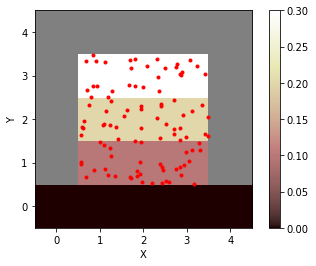

In [6]:
%matplotlib inline
imshow_grid(grid, grid.at_node['topographic__elevation'], color_for_closed='gray')
plot(CC['clast__x'], CC['clast__y'], 'or', markersize=3)



The grid is sloping to the south.

## 2. Principle and equations of the clast-tracker

`ClastCollection` has a method `clast_tracker` to move the clast on the surface of the grid.

We use a probabilistic approach to travel distances calculated at each time step to move the clasts over the landscape.

In practice, clasts are treated one after the other. The clasts are treated differently if they are on a hillslope or in a river (see [&sect; 2.1](#2.1-Hillslope-vs.-river)). The process to move a particular clast involves four steps:
- detachment ([&sect; 2.2](#2.2.-Detachment:-probability-of-disturbance))
- determination of travel azimuth ([&sect; 2.3](#2.3-Travel-direction/azimuth))
- determination of travel distance ([&sect; 2.4](#2.4-Travel-distance))
- deposition/burial ([&sect; 2.5](#2.5-Deposition/burial))



### 2.1 Hillslope vs. river

Particle travel speed is generally higher in a riverbed compared to a hillslope. To account for this, the rules for moving clasts must vary as a function of the location in the model domain. We define two characteristic regions within the model grid, 'hillslope' and 'river', with each cell belonging to only one category.    
A plot of the slope versus contributing drainage area typically displays a sharp transition between cells belonging to the hillslope, characterized by steeper slope and low contributing area, and cells belonging to the riverbed, with lower slopes and higher contributing area (see [Tucker and Bras, 1998](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/98WR01474)). We thus use the drainage area/slope ratio to assign each grid cell to a defined category and accordingly apply a different rule for moving clasts depending on the type of cell they are in (see details below). The threshold slope/area value to assign cells to each category is user-defined.


### 2.2. Detachment: probability of disturbance

At the begginning of a time step, the clast can be at the surface of the model topographt or buried under it.

On each cell, we define the probability of disturbance of the soil at a time _t_ as:

$$
\begin{equation}
f_{m}(t) = N_{a}.e^{-N_{a}t}\tag{Eq.1}
\end{equation}
$$

with $N_{a}$ the distrubance frequency $[T^{-1}]$.  

The probability for a clast to be mobilized during a time step _&Delta;t_ is:

$$
\begin{equation}
P_{m}(\Delta t) = (1 - e^{-N_{a} \Delta t}) . e^{- \frac{h}{h*}} \tag{Eq.2}
\end{equation}
$$


with $h$ the clast depth below the topographic surface $[L]$ and $h^{*}$ a characteristic depth $[L]$. 

The values of the disturbance frequency $N_{a}$ and of the characteristic depth $h^{*}$ are defined by the user.


**_should it depend on clast radius?_** For now, it doesn't but we acknowledge that it should.




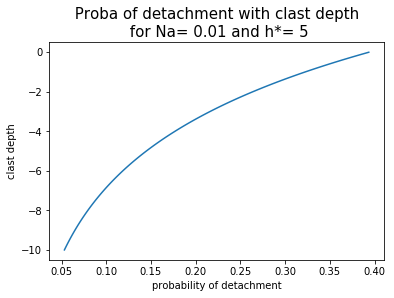

In [7]:
clast_depth = np.linspace(0,10,101)
disturb_fqcy=0.01
dt=50
h_star=5



proba_mobile = (1-np.exp(-disturb_fqcy * dt)) * np.exp(-clast_depth / h_star)

figure()
plot(proba_mobile, -clast_depth)
xlabel('probability of detachment')
ylabel('clast depth')
title(' Proba of detachment with clast depth \n for Na= %s and h*= %s' %(disturb_fqcy, h_star), size=15);

### 2.3 Travel direction/azimuth

#### 2.3.1 Direction of steepest slope: hillslope vs. river

First, the azimuth of the steepest slope is determined.  
On hillslope cells, the direction and dip of the steepest slope are calculated using the neighbor North/South and East/West cells (centered slope). (make a sketch)  
On river cells, the direction and dip of the steepest slope are calculated by a Flow Routing tool (e.g. FlowAccumulatorSteepest).

_**Explain why we use different methods: centered slope takes neighboring into account, more non-local. But we can't use centered slope on river cells because uneven river banks make a mess, so in rivers we use steepest slope**_


#### 2.3.2 Deviation from direction of steepest slope

Clasts can be allowed to deviate from the direction of the steepest slope to allow for lateral spreading. For each clast, at each position $x$, we define a maximum angle of deviation from the azimuth of the steepest slope as:


$$
\begin{equation}
\theta_{max}(clast, x) = \pi . exp(\frac{S}{\sqrt{\lambda_{0}}}) . cos(S)     \tag{Eq.3}
\end{equation}
$$


where $S$ is the local steepest slope and $\lambda_{0}$ is a characteristic length corresponding to the average distance between 'traps' or 'obstacles' (~roughness) on the surface that will stop the clast (also equals to the average particle motion on a horizontal surface, see below).  $\lambda_{0}$ depends on the clast size, and so does the maximum angle of deviation: larger clasts tend to deviate less from the azimuth of the steepest slope. 

This capability can be turned on/off by the user if they want spreading or not.

If the spreading option is on, the maximum angle of deviation is calculated for each clast and an angle is picked randomly in the interval $ [-\theta_{max}, \theta_{max}]$ (uniform distribution).

This is a heuristic approach designed  to be replaced once data is available.

_(clast spreading only on hillslopes for now)_


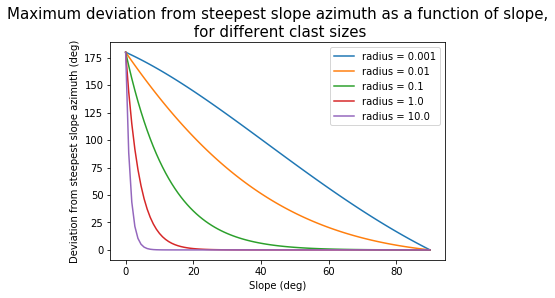

In [8]:
# Max angle

kappa = 0.0001 # diffusion coefficient
disturbance_fqcy = 0.01 # Na

slope = np.linspace(0, np.pi/2, 100)

radi = [0.001, 0.01, 0.1, 1., 10.]

for i in radi:
    lambda_0 = kappa / (2 * i * disturbance_fqcy)

    max_deviation = np.pi * np.exp(-slope/np.sqrt(lambda_0)) * np.cos(slope)
    
    plot(slope * 180/np.pi, max_deviation * 180/np.pi, label="radius = %s" %i)
    xlabel('Slope (deg)')
    ylabel('Deviation from steepest slope azimuth (deg)')
    legend(loc='upper right')
    title('Maximum deviation from steepest slope azimuth as a function of slope,\n for different clast sizes', size=15)
    
  

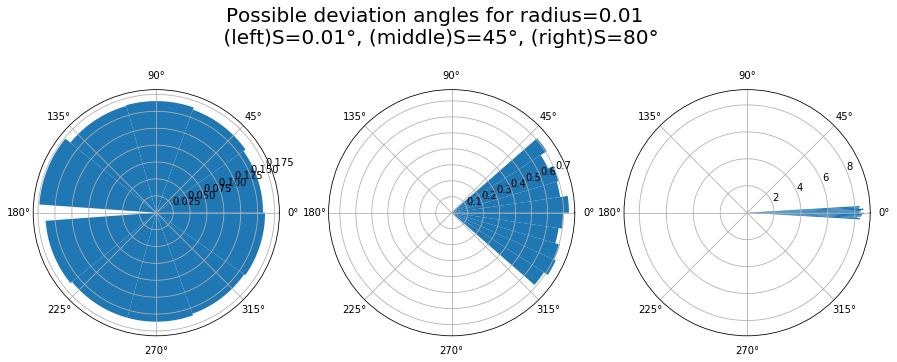

In [9]:
# Fixed radius, angles for different slopes

kappa = 0.0001 # diffusion coefficient
disturbance_fqcy = 0.01 # Na

slope = np.linspace(0, np.pi/2, 100)

radius = 0.01

lambda_0 = kappa / (2 * radius * disturbance_fqcy)

max_deviation = np.pi * np.exp(slope/(-np.sqrt(lambda_0))) * np.cos(slope)
   
# for radius = 0.01, plot angles for S=.01 deg, S=45 deg and S = 80 deg
draw_dev = np.random.uniform(low=-max_deviation[1],
                             high=max_deviation[1],
                            size=10000)
draw_dev2 = np.random.uniform(low=-max_deviation[50],
                                                  high=max_deviation[50],
                                                  size=10000)
draw_dev3 = np.random.uniform(low=-max_deviation[-10],
                                                  high=max_deviation[-10],
                                                  size=10000)
#radial plots
fig, ax = plt.subplots(1,3, subplot_kw=dict(polar=True), figsize=(15,6))
ax[0].hist(draw_dev, density=True)
ax[1].hist(draw_dev2, density=True)
ax[2].hist(draw_dev3, density=True)

fig.suptitle('Possible deviation angles for radius=0.01 \n (left)S=0.01°, (middle)S=45°, (right)S=80°', size=20);

Left: slope = 0.01° --> clasts can go (almost) any direction  
Middle: slope = 45° --> clasts preferentially go toward azimuth of steepest slope, +/- 40°  
Right, slope = 80° --> clasts are mostly restricted to the direction of steepest slope, +/- a few degrees


## 2.4 Travel distance
[Furbish and Haff. 2010](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2009JF001576) and [Furbish and Roering 2013](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/jgrf.20071) provided a nonlocal formulation of the sediment flux involving a convolution of upslope and downslope surface geometry. Once motion is initiated, the distribution of particle travel distances is determined by the disentrainment (deposition) process.

The disentrainment rate $P_{r}(r;x')$ (= rate of deposition, $[L^{-1}]$) at a distance $r$ from the starting point $x’$ is be defined as ([Furbish and Haff. 2010](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2009JF001576)):



$$
\begin{equation}
P_{r}(r;x') = \frac{1}{\lambda_{0}} . \frac{S_{c} - S(x')}{S_{c} + S(x')} \tag{Eq.4}
\end{equation}
$$

with $ 0 \leq S(x') < S_{c}$


where $S_{c}$ is the critical slope (corresponding to critical slope introduced by Roering et al., 1999 , and friction angle introduced by Gabet, 2003 , for dry gravel). It corresponds to the magnitude of a slope beyond which particles in motion are not stopped, they continue moving downslope indefinitely.  
The characteristic length scale $\lambda_{0}$ characterizes the average particle motions on a horizontal surface ($S=0$) (defined below).  
$P_{r}(r;x')dr$ represents the probability that a particle will be disentrained (stop moving) within the interval $[r, r+dr]$, given that it travelled at least as far as $r$; it is thus a conditional probability.
Note that this formulation does not explicitly involve sediment momentum, but implicitly involves a friction-like behavior (e.g., Gabet, 2003) inasmuch as the dispersal length scale decreases with decreasing steepness.    
When $S(x') \rightarrow S_{c}$, $P_{r}(r;x') \rightarrow 0$ and the clast is not stopped. This results in clasts travelling long distances when the slope is steep.  

The probability distribution of the travel distribution can be expressed in terms of the disentrainment rate as follows:

$$
\begin{equation}
f_{r}(r;x') = P_{r}(r;x') . e^{-\int_0^r \! P_{r}(w;x') \, \mathrm{d}w} \tag{Eq.5}
\end{equation}
$$

The shape of the probability distribution depends on the local slope and must thus be evaluated in each point of the model, at each timestep (spatially and temporally variable).

The travel distance $r$ also depends on the characteristics of each clast and its mechanical properties as it interacts with the landscape surface. This is expressed in the formulation of the characteristic length $\lambda_{0}$, which we define as:
$$
\begin{equation} 
\lambda_{0} = \frac{\kappa}{2R.N_{a}} \tag{Eq.6}
\end{equation}
$$

where $\kappa$ is the diffusion coefficient $[L^{2}T^{-1}]$, $R$ is the clast radius $[L]$ and $N_{a}$ the distrubance frequency $[T^{-1}]$.

Evaluating Eq.5 thus yields the probability for a clast to travel a distance $\lambda$:

$$
\begin{equation}
f_{r}(\lambda) = \frac{1}{\overline{\lambda}} . e^{-\frac{1}{\overline{\lambda}}} \tag{Eq.7}
\end{equation}
$$  

with:
$$
\begin{equation}
\overline{\lambda} = \lambda_{0} . \frac{S_{c} + S}{S_{c} - S} \tag{Eq.8}
\end{equation}
$$

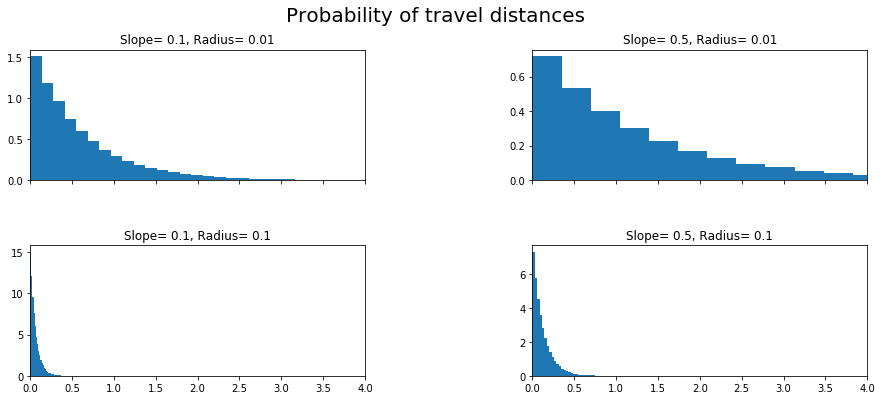

In [10]:
kappa = 0.0001 # diffusion coefficient
disturbance_fqcy = 0.01 # Na
criticial_slope = 1.2 # Sc


# Case 1 
radius_1 = 0.01 # clast radius in meters
slope_1 = 0.1

lambda_0_1 = kappa / (2 * radius_1 * disturbance_fqcy)
lambda_mean_1 = lambda_0_1 * ((criticial_slope + slope_1) / (criticial_slope - slope_1))
travel_distances_1 = np.random.exponential(scale=lambda_mean_1, size=100000)

# Case 2 
radius_2 = 0.01 # clast radius in meters
slope_2 = 0.5

lambda_0_2 = kappa / (2 * radius_2 * disturbance_fqcy)
lambda_mean_2 = lambda_0_2 * ((criticial_slope + slope_2) / (criticial_slope - slope_2))
travel_distances_2 = np.random.exponential(scale=lambda_mean_2, size=100000)

# Case 3
radius_3 = 0.1 # clast radius in meters
slope_3 = 0.1

lambda_0_3 = kappa / (2 * radius_3 * disturbance_fqcy)
lambda_mean_3 = lambda_0_3 * ((criticial_slope + slope_3) / (criticial_slope - slope_3))
travel_distances_3 = np.random.exponential(scale=lambda_mean_3, size=100000)

# Case 4
radius_4 = 0.1 # clast radius in meters
slope_4 = 0.5

lambda_0_4 = kappa / (2 * radius_4 * disturbance_fqcy)
lambda_mean_4 = lambda_0_4 * ((criticial_slope + slope_4) / (criticial_slope - slope_4))
travel_distances_4 = np.random.exponential(scale=lambda_mean_4, size=100000)


# Plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,6), sharex=True)
ax0, ax1, ax2, ax3 = axes.flatten()
fig.suptitle('Probability of travel distances', size=20)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

ax0.hist(travel_distances_1, 50, density=True, histtype='bar')
ax0.set_title('Slope= %s, Radius= %s' %(slope_1, radius_1))
ax0.set_xlim(0,4)

ax1.hist(travel_distances_2, 50, density=True, histtype='bar')
ax1.set_title('Slope= %s, Radius= %s' %(slope_2, radius_2))

ax2.hist(travel_distances_3, 50, density=True, histtype='bar')
ax2.set_title('Slope= %s, Radius= %s' %(slope_3, radius_3))

ax3.hist(travel_distances_4, 50, density=True, histtype='bar')
ax3.set_title('Slope= %s, Radius= %s' %(slope_4, radius_4));


#ax3.set_visible(False)

Left to right: increasing slope  
Top to bottom: increasing radius

If the travel distance randomly drawn from the probability distribution is **smaller** than the distance for the clast to exit the current cell (in the direction of the selected azimuth, see [&sect; 2.3](#2.3-Travel-direction/azimuth)), then the clast travels within the current cell, in the selected direction, of a distance equal to the drawn travel distance.

If the travel distance randomly drawn from the probability distribution is **larger** than the distance to exit the cell, then the clast is moved in the selected direction until it exits the current cell and enters a new cell. There, both the direction of travel and the remaining travel distance must be re-evaluated with regard to the conditions in the new cell (slope, etc.):
- the direction of travel is re-calculated (see [&sect; 2.3](#2.3-Travel-direction/azimuth)),
- the remaining travel distance $\lambda$ is rescaled to the characteristics of the new cell:

$$
\begin{equation}
\lambda_{new} = \lambda_{old} . \frac{\overline{\lambda_{new}}}{\overline{\lambda_{old}}} \tag{Eq.9}
\end{equation}
$$

## 2.5 Deposition/burial

For now, clasts are simply deposited at the surface.

This means that once a clast has been mobilized, it will (almost certainly) move at every subsequent time step.

Below is an attempt at defining a probability distribution for the burial depth: should include h*. In a future version, should also include clast radius (detachment proba does not include it at the moment, deposition should be consistent with that).

If we implement this, the clasts tend to be buried and not picked up again, so this needs refining.

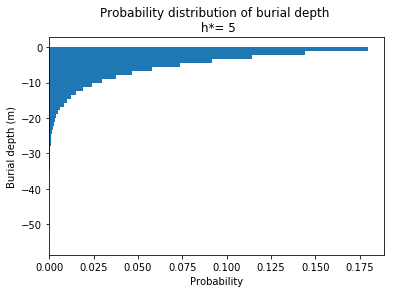

In [11]:
h_star = 5

z_burial = np.random.exponential(scale=(h_star), size=100000)

n, bins, patches = plt.hist(-z_burial, 50, density=1, orientation='horizontal')

plt.xlabel('Probability')
plt.ylabel('Burial depth (m)')
plt.title('Probability distribution of burial depth \n h*= %s' %h_star);



_**This is not implemented yet as I don't know the shape this should have, the above is just an example**_

# 3. Running a landscape evolution model with a clast-tracker

We will creat a grid sloping to the south, open on the south boundary, closed everywhere else.
We will add two Landlab components:
- FlowAccumulator, to route flow over the surface, using the FlowDirectorSteepest option
- LinearDiffuser, to perform linear diffusion on the surface

With this setting, a set of 100 clasts is initially positioned at the center of the grid, buried below the topographic surface. Diffusion on the surface will progressively bring them closer to the surface until they can be picked up and transported.

_**lots of things are printing for now, I use it to check/debug, ultimately they won't show. For now, when the next block is done running, scroll all the way down where the output is printed to see the figure**_

CLAST 0
not phantom
clast depth=0.370597748691
detached
[128 142 126 112 143 141 111 113]
max_dev=2.71502716898
draw_dev=[-0.20320941]
slope_we_with_dev=-0.0201813737601
neighborhood
ssdip= 0.0996686524912
SW-C
change_x = -1.27900264032
change_y = -0.858908004869
move_to
dist_to_travel:
0.4276223697927248
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
clast depth=0.355997071342
detached
[128 142 126 112 143 141 111 113]
max_dev=2.71502716898
draw_dev=[-2.71213385]
slope_we_with_dev=-0.0416378808231
neighborhood
ssdip= 0.0996686524912
NW-C
change_x = -0.259099196399
change_y = 0.201755371597
move_to
dist_to_travel:
0.1820901647034862
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
clast depth=0.311800268864
detached
[128 142 126 112 143 141 111 113]
max_dev=2.71502716898
draw_dev=[-0.87144352]
slope_we_with_dev=-0.0765258959469
neighborhood
ssdip= 0.0996686524912
SW-R
change_x = -0.238262671308
change_y = -0.228854040551
move_to
dist_to_travel:
0.4028618

[143 157 141 127 158 156 126 128]
max_dev=2.71502716898
draw_dev=[-2.15001164]
slope_we_with_dev=-0.0836892421747
ssdip= 0.0996686524912
NW-R
change_x = -0.428417936486
change_y = 0.474978845586
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.012589438436054284)
Coordinates:
    item_id  int64 1
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
clast depth=0.0
detached
[127 141 125 111 142 140 110 112]
max_dev=2.71502716898
draw_dev=[ 0.2709381]
slope_we_with_dev=0.0267635436415
neighborhood
ssdip= 0.0996686524912
SE-R
change_x = 0.0158241906072
change_y = -0.00433921655062
move_to
dist_to_travel:
0.3119215671340683
moving
MOVE OUT OF CELL
from node: 126
current x: 6.484175809492757
current y: 8.058766681999364
going to node: 127
applying changex 0.015824190607243153
applying changey -0.004339216550618666
new x: 6.5000000001
new y: 8.054427465448745
hop length: <xarray.DataArray 'hop_length' ()>
array(0.01649018334446287)
Coordinates:


applying changey 2.469370943504548e-10
new x: 6.5000000001
new y: 7.794781637317725
hop length: <xarray.DataArray 'hop_length' ()>
array(0.6642179753952677)
Coordinates:
    item_id  int64 6
    time     float64 100.0
new node: 127
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.8036966970256578)
Coordinates:
    item_id  int64 6
[128 142 126 112 143 141 111 113]
max_dev=2.71502716898
draw_dev=[-1.35750107]
slope_we_with_dev=-0.0977338676344
ssdip= 0.0996686524912
SW-R
change_x = -2.00000008274e-10
change_y = -2.4824149378e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.8036966970256578)
Coordinates:
    item_id  int64 6
moving
MOVE OUT OF CELL
from node: 127
current x: 6.5000000001
current y: 7.794781637317725
going to node: 126
applying changex -2.0000000827403712e-10
applying changey -2.4824149378025224e-10
new x: 6.4999999999
new y: 7.794781637069484
hop length: <xarray.DataArray 'hop_length' ()>
array(0.664217975

applying changex 1.8999931417575323e-10
applying changey 2.0000000827403712e-10
new x: 6.623336214923763
new y: 8.5000000001
hop length: <xarray.DataArray 'hop_length' ()>
array(0.0494386173948751)
Coordinates:
    item_id  int64 5
    time     float64 150.0
new node: 142
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.37011683096734166)
Coordinates:
    item_id  int64 5
[143 157 141 127 158 156 126 128]
max_dev=2.71502716898
draw_dev=[-1.86421671]
slope_we_with_dev=-0.0957260206315
ssdip= 0.0996686524912
NW-R
change_x = -0.123336215024
change_y = 0.175144875443
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.37011683096734166)
Coordinates:
    item_id  int64 5
moving
MOVE OUT OF CELL
from node: 142
current x: 6.623336214923763
current y: 8.5000000001
going to node: 141
applying changex -0.12333621502376334
applying changey 0.17514487544331112
new x: 6.4999999999
new y: 8.67514487554331
hop length: <xarray.DataArray 'hop_

    time     float64 200.0
new node: 127
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(1.127306157869439)
Coordinates:
    item_id  int64 5
[128 142 126 112 143 141 111 113]
max_dev=2.71502716898
draw_dev=[ 0.86739324]
slope_we_with_dev=0.0762645436053
ssdip= 0.0996686524912
SE-R
change_x = 0.630267769949
change_y = -0.602220461202
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(1.1273061579285637)
Coordinates:
    item_id  int64 5
moving
MOVE OUT OF CELL
from node: 127
current x: 6.8697322301511
current y: 8.4999999999
going to node: 128
applying changex 0.6302677699489001
applying changey -0.6022204612019997
new x: 7.5000000001
new y: 7.897779538698
hop length: <xarray.DataArray 'hop_length' ()>
array(1.174824952654851)
Coordinates:
    item_id  int64 5
    time     float64 200.0
new node: 128
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.2512319516337925)
Coordinates:
    item_id  int64 5
[1

[129 143 127 113 144 142 112 114]
max_dev=2.71502716898
draw_dev=[ 1.00357139]
slope_we_with_dev=0.0843395243954
neighborhood
ssdip= 0.099668652491
SE-R
change_x = 0.77202943838
change_y = -0.867207111709
move_to
dist_to_travel:
0.6496885752586983
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
clast depth=0.0
detached
[128 142 126 112 143 141 111 113]
max_dev=2.71502716898
draw_dev=[-2.30030298]
slope_we_with_dev=-0.0745503311402
neighborhood
ssdip= 0.099668652491
NW-R
change_x = -0.0547649084275
change_y = 0.050560727101
move_to
dist_to_travel:
0.14681238023465504
moving
MOVE OUT OF CELL
from node: 127
current x: 6.554764908327472
current y: 8.028654893987664
going to node: 126
applying changex -0.054764908427472385
applying changey 0.05056072710095098
new x: 6.4999999999
new y: 8.079215621088615
hop length: <xarray.DataArray 'hop_length' ()>
array(0.07490753061773271)
Coordinates:
    item_id  int64 6
    time     float64 250.0
new node: 126
distance left to travel <

moved
elevation updated
CLAST 1
not phantom
clast depth=-1.55431223448e-15
detached
[127 141 125 111 142 140 110 112]
max_dev=2.71502716898
draw_dev=[-1.16818278]
slope_we_with_dev=-0.0920040085014
neighborhood
ssdip= 0.0996686524902
SW-R
change_x = -0.605195259631
change_y = -0.79484706721
move_to
dist_to_travel:
0.6484151581565805
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
clast depth=-1.55431223448e-15
detached
[129 143 127 113 144 142 112 114]
max_dev=2.71502716898
draw_dev=[-1.91487794]
slope_we_with_dev=-0.0941385651096
neighborhood
ssdip= 0.0996686524902
NW-R
change_x = -0.0380025230915
change_y = 0.0521860348697
move_to
dist_to_travel:
0.25616727214987395
moving
MOVE OUT OF CELL
from node: 128
current x: 7.5380025229914756
current y: 7.6118982374082975
going to node: 127
applying changex -0.03800252309147555
applying changey 0.0521860348696814
new x: 7.4999999999
new y: 7.664084272277979
hop length: <xarray.DataArray 'hop_length' ()>
array(0.064878731004115

current x: 6.960857864905864
current y: 8.671900220810628
going to node: 127
applying changex -0.11282518558484601
applying changey -0.1719002209106275
new x: 6.848032679321018
new y: 8.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(0.20664462376743037)
Coordinates:
    item_id  int64 8
    time     float64 300.0
new node: 127
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.47513717893520097)
Coordinates:
    item_id  int64 8
[128 142 126 112 143 141 111 113]
max_dev=2.71502716898
draw_dev=[ 0.86384729]
slope_we_with_dev=0.0760347067048
ssdip= 0.0996686524902
SE-R
change_x = 0.651967320779
change_y = -0.620094119393
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.47513717930304383)
Coordinates:
    item_id  int64 8
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
clast depth=-1.55431223448e-15
detached
[129 143 127 113 144 142 112 114]
max_dev=2.71502716898
draw_dev=[-2.66093045]
slope_we_w

[129 143 127 113 144 142 112 114]
max_dev=2.71502716899
draw_dev=[ 1.24673207]
slope_we_with_dev=0.0947949101196
neighborhood
ssdip= 0.099668652488
SE-R
change_x = 0.785673339819
change_y = -1.09392326854
move_to
dist_to_travel:
0.7296353920237558
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
clast depth=0.0
detached
[112 126 110  96 127 125  95  97]
max_dev=2.71502716898
draw_dev=[ 0.66937709]
slope_we_with_dev=0.0620497614836
neighborhood
ssdip= 0.0996686524911
SE-C
change_x = 0.690828484
change_y = -0.692474380189
move_to
dist_to_travel:
0.44200125890447217
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
clast depth=-3.21964677141e-14
detached
[127 141 125 111 142 140 110 112]
max_dev=2.71502716901
draw_dev=[-0.02406344]
slope_we_with_dev=-0.00240611215389
neighborhood
ssdip= 0.0996686524827
SW-C
change_x = -0.620693733374
change_y = -0.398796693857
move_to
dist_to_travel:
0.6292403763670363
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not ph

[112 126 110  96 127 125  95  97]
max_dev=2.71502716898
draw_dev=[-1.0743768]
slope_we_with_dev=-0.0879293503093
neighborhood
ssdip= 0.0996686524911
SW-R
change_x = -0.277008320407
change_y = -0.334605359082
move_to
dist_to_travel:
1.3114023932704995
moving
MOVE OUT OF CELL
from node: 111
current x: 5.77700832030671
current y: 6.847573523979205
going to node: 110
applying changex -0.2770083204067104
applying changey -0.3346053590820418
new x: 5.4999999999
new y: 6.5129681648971625
hop length: <xarray.DataArray 'hop_length' ()>
array(0.436556181332914)
Coordinates:
    item_id  int64 0
    time     float64 450.0
new node: 110
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.8748462120790861)
Coordinates:
    item_id  int64 0
[111 125 109  95 126 124  94  96]
max_dev=2.71502716898
draw_dev=[-0.99789867]
slope_we_with_dev=-0.0840333771908
ssdip= 0.0996686524911
SW-C
change_x = -0.00781002534611
change_y = -0.0129681649972
distance left to travel RESCALED <xarray

moved
elevation updated
CLAST 3
not phantom
clast depth=-8.51541059887e-14
detached
[128 142 126 112 143 141 111 113]
max_dev=2.71502716906
draw_dev=[ 1.66358089]
slope_we_with_dev=0.0995698599072
neighborhood
ssdip= 0.0996686524722
NE-R
change_x = 0.361335267059
change_y = 0.557457627641
move_to
dist_to_travel:
0.4111131060781939
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
clast depth=-2.10992334715e-11
detached
[142 156 140 126 157 155 125 127]
max_dev=2.71502718445
draw_dev=[ 0.12776496]
slope_we_with_dev=0.0127417635135
neighborhood
ssdip= 0.0996686487269
SE-R
change_x = 0.0451699263627
change_y = -0.00578679615372
move_to
dist_to_travel:
0.9781600148348134
moving
MOVE OUT OF CELL
from node: 141
current x: 6.454830073737336
current y: 9.35805114737235
going to node: 142
applying changex 0.04516992636266436
applying changey -0.005786796153718539
new x: 6.5000000001
new y: 9.352264351218633
hop length: <xarray.DataArray 'hop_length' ()>
array(0.04576622497355077)


moved
elevation updated
CLAST 7
not phantom
clast depth=-2.22044604925e-16
detached
[113 127 111  97 128 126  96  98]
max_dev=2.71502716898
draw_dev=[-0.31493163]
slope_we_with_dev=-0.0309751467162
neighborhood
ssdip= 0.0996686524911
SW-C
change_x = -0.258295915271
change_y = -0.184391501543
move_to
dist_to_travel:
0.0312136425816867
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
clast depth=-8.51541059887e-14
detached
[129 143 127 113 144 142 112 114]
max_dev=2.71502716906
draw_dev=[ 0.08957977]
slope_we_with_dev=0.0089460015176
neighborhood
ssdip= 0.0996686524722
SE-C
change_x = 0.835993918656
change_y = -0.541531723848
move_to
dist_to_travel:
0.9698326961111338
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
clast depth=-2.22044604925e-16
detached
[115 129 113  99 130 128  98 100]
max_dev=2.71502716898
draw_dev=[ 1.2055146]
slope_we_with_dev=0.0934023162167
neighborhood
ssdip= 0.0996686524911
SE-R
change_x = 0.889043010855
change_y = -1.20215642085
m

change_x = -0.230592735685
change_y = -0.154860310775
move_to
dist_to_travel:
0.8699861025002338
moving
MOVE OUT OF CELL
from node: 112
current x: 7.296868171439347
current y: 6.654860310675411
going to node: 97
applying changex -0.2305927356850646
applying changey -0.15486031077541096
new x: 7.0662754357542825
new y: 6.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(0.2791527769165449)
Coordinates:
    item_id  int64 7
    time     float64 500.0
new node: 97
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.5908333257231493)
Coordinates:
    item_id  int64 7
[ 98 112  96  82 113 111  81  83]
max_dev=2.71502716898
draw_dev=[-1.99335539]
slope_we_with_dev=-0.0912042467444
ssdip= 0.0996686524912
NW-C
change_x = -1.43474510233e-10
change_y = 2.00000008274e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.5908333257233066)
Coordinates:
    item_id  int64 7
moving
MOVE OUT OF CELL
from node: 97
current x: 7.066

    item_id  int64 2
[128 142 126 112 143 141 111 113]
max_dev=2.71502716926
draw_dev=[-1.04871082]
slope_we_with_dev=-0.0866781045756
ssdip= 0.0996686524228
SW-C
change_x = -1.54460135763e-10
change_y = -2.00000008274e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.10311135509679124)
Coordinates:
    item_id  int64 2
moving
MOVE OUT OF CELL
from node: 127
current x: 7.264139600066202
current y: 7.5000000001
going to node: 112
applying changex -1.544601357627786e-10
applying changey -2.0000000827403712e-10
new x: 7.264139599911742
new y: 7.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(0.6302561819800087)
Coordinates:
    item_id  int64 2
    time     float64 550.0
new node: 112
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.10311135498235538)
Coordinates:
    item_id  int64 2
[113 127 111  97 128 126  96  98]
max_dev=2.71502716898
draw_dev=[ 2.09226524]
slope_we_with_dev=0.0867088370303
ssdip= 0.099

CLAST 0
not phantom
clast depth=0.0
detached
[ 96 110  94  80 111 109  79  81]
max_dev=2.71502716898
draw_dev=[ 0.56258498]
slope_we_with_dev=0.053337456218
neighborhood
ssdip= 0.0996686524912
SE-C
change_x = 0.676165654789
change_y = -0.59895113139
move_to
dist_to_travel:
0.48468529348667044
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
clast depth=-3.44169137634e-15
detached
[111 125 109  95 126 124  94  96]
max_dev=2.71502716898
draw_dev=[-0.99197022]
slope_we_with_dev=-0.083710539452
neighborhood
ssdip= 0.0996686524905
SW-R
change_x = -0.758550217963
change_y = -0.841350457746
move_to
dist_to_travel:
0.79817017484432
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
clast depth=-6.83120227052e-13
detached
[128 142 126 112 143 141 111 113]
max_dev=2.71502716946
draw_dev=[-0.52720667]
slope_we_with_dev=-0.0503121270019
neighborhood
ssdip= 0.0996686523749
SW-C
change_x = -0.0015949589019
change_y = -0.00136145738631
move_to
dist_to_travel:
0.35934309924

slope_we_with_dev=-0.0585605883511
ssdip= 0.0996686524905
SW-C
change_x = -2.05170951071e-10
change_y = -2.00000008274e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(1.2537919946187146)
Coordinates:
    item_id  int64 5
moving
MOVE OUT OF CELL
from node: 114
current x: 9.228662434101832
current y: 6.5000000001
going to node: 99
applying changex -2.0517095107104852e-10
applying changey -2.0000000827403712e-10
new x: 9.22866243389666
new y: 6.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(0.02227894402871251)
Coordinates:
    item_id  int64 5
    time     float64 600.0
new node: 99
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(1.253791994472867)
Coordinates:
    item_id  int64 5
[100 114  98  84 115 113  83  85]
max_dev=2.71502716898
draw_dev=[-1.20406389]
slope_we_with_dev=-0.0933503968296
ssdip= 0.0996686524912
SW-R
change_x = -0.728662433997
change_y = -0.984221875034
distance left to travel RESCALED 

ssdip= 0.0996686524905
NW-R
change_x = -1.0
change_y = 1.45326036968
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.2789316632598047)
Coordinates:
    item_id  int64 8
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
clast depth=-6.83120227052e-13
detached
[130 144 128 114 145 143 113 115]
max_dev=2.71502716946
draw_dev=[-1.84763034]
slope_we_with_dev=-0.0961925556453
neighborhood
ssdip= 0.0996686523749
NW-R
change_x = -0.98889850797
change_y = 1.41830566583
move_to
dist_to_travel:
3.8830147152054146
moving
MOVE OUT OF CELL
from node: 129
current x: 9.488898507869692
current y: 7.596499369217704
going to node: 128
applying changex -0.9888985079696919
applying changey 1.418305665831262
new x: 8.4999999999
new y: 9.014805035048965
hop length: <xarray.DataArray 'hop_length' ()>
array(1.7376439027981185)
Coordinates:
    item_id  int64 9
    time     float64 600.0
new node: 143
distance left to travel <xarray.DataArray 'distance__to_trav

draw_dev=[-1.99217327]
slope_we_with_dev=-0.0912526611654
ssdip= 0.0996686524912
NW-C
change_x = -0.0212992071134
change_y = 0.0491372661544
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.9610372205961939)
Coordinates:
    item_id  int64 5
moving
MOVE OUT OF CELL
from node: 83
current x: 8.4999999999
current y: 5.45086273394564
going to node: 98
applying changex -0.021299207113413886
applying changey 0.049137266154359864
new x: 8.478700792786587
new y: 5.5000000001
hop length: <xarray.DataArray 'hop_length' ()>
array(0.1728493170377723)
Coordinates:
    item_id  int64 5
    time     float64 650.0
new node: 98
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.9072152138884895)
Coordinates:
    item_id  int64 5
[ 99 113  97  83 114 112  82  84]
max_dev=2.71502716898
draw_dev=[ 2.33803865]
slope_we_with_dev=0.0719827655921
ssdip= 0.0996686524912
NE-R
change_x = 0.0212992073134
change_y = 0.0186743574789
distance left to trave

[127 141 125 111 142 140 110 112]
max_dev=2.71502717017
draw_dev=[ 1.22147988]
slope_we_with_dev=0.0939606878355
neighborhood
ssdip= 0.0996686522017
SE-R
change_x = 0.306713181603
change_y = -0.419615821826
move_to
dist_to_travel:
0.10845915132396577
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
clast depth=-1.25455201783e-14
detached
[112 126 110  96 127 125  95  97]
max_dev=2.71502716899
draw_dev=[-1.39703596]
slope_we_with_dev=-0.0984941612261
neighborhood
ssdip= 0.099668652489
SW-C
change_x = -0.0176220261504
change_y = -0.100910248559
move_to
dist_to_travel:
2.0935846603681716
moving
MOVE OUT OF CELL
from node: 111
current x: 6.470379128848577
current y: 6.600910248458903
going to node: 96
applying changex -0.017622026150422177
applying changey -0.10091024855890306
new x: 6.452757102698154
new y: 6.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(0.10294827929868373)
Coordinates:
    item_id  int64 8
    time     float64 700.0
new node: 96
distance

[ 97 111  95  81 112 110  80  82]
max_dev=2.71502716898
draw_dev=[-0.85373186]
slope_we_with_dev=-0.0753738133683
ssdip= 0.0996686524911
SW-R
change_x = -2.00000008274e-10
change_y = -1.93860332601e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.23609132447772316)
Coordinates:
    item_id  int64 0
moving
MOVE OUT OF CELL
from node: 96
current x: 5.5000000001
current y: 5.574276942346964
going to node: 95
applying changex -2.0000000827403712e-10
applying changey -1.938603326011624e-10
new x: 5.4999999999
new y: 5.574276942153104
hop length: <xarray.DataArray 'hop_length' ()>
array(0.19831942664110655)
Coordinates:
    item_id  int64 0
    time     float64 750.0
new node: 95
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.23609132433989044)
Coordinates:
    item_id  int64 0
[ 96 110  94  80 111 109  79  81]
max_dev=2.71502716898
draw_dev=[ 1.54418265]
slope_we_with_dev=0.0999645877033
ssdip= 0.0996686524911
SE-R
change_

detached
[ 97 111  95  81 112 110  80  82]
max_dev=2.71502716898
draw_dev=[ 0.5792213]
slope_we_with_dev=0.0547372413957
neighborhood
ssdip= 0.0996686524911
SE-C
change_x = 0.13307308326
change_y = -0.120029074804
move_to
dist_to_travel:
1.1645243659237106
moving
MOVE OUT OF CELL
from node: 96
current x: 5.730421316985275
current y: 5.620029074703781
going to node: 81
applying changex 0.1330730832601367
applying changey -0.12002907480378065
new x: 5.863494400245412
new y: 5.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(0.18010157836475693)
Coordinates:
    item_id  int64 0
    time     float64 800.0
new node: 81
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.984422787700892)
Coordinates:
    item_id  int64 0
[82 96 80 66 97 95 65 67]
max_dev=2.71502716898
draw_dev=[ 0.94749662]
slope_we_with_dev=0.0811956782599
ssdip= 0.0996686524912
SE-R
change_x = 0.636505599855
change_y = -0.671245840887
distance left to travel RESCALED <xarray.DataArra

[129 143 127 113 144 142 112 114]
max_dev=2.71502717258
draw_dev=[-1.44918378]
slope_we_with_dev=-0.0992614294255
ssdip= 0.0996686516162
SW-C
change_x = -1.12191165529e-10
change_y = -2.00000008274e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.10240654208340562)
Coordinates:
    item_id  int64 3
moving
MOVE OUT OF CELL
from node: 128
current x: 8.198012342054026
current y: 7.5000000001
going to node: 113
applying changex -1.1219116552926677e-10
applying changey -2.0000000827403712e-10
new x: 8.198012341941835
new y: 7.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(0.31077906301358427)
Coordinates:
    item_id  int64 3
    time     float64 850.0
new node: 113
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.10240654198216279)
Coordinates:
    item_id  int64 3
[114 128 112  98 129 127  97  99]
max_dev=2.71502716902
draw_dev=[-0.25984922]
slope_we_with_dev=-0.0256934839635
ssdip= 0.0996686524824
SW-C
ch

elevation updated
CLAST 7
not phantom
clast depth=-6.17017548166e-12
detached
[126 140 124 110 141 139 109 111]
max_dev=2.71502717258
draw_dev=[-1.3357334]
slope_we_with_dev=-0.0972499677902
neighborhood
ssdip= 0.0996686516162
SW-R
change_x = -0.566919352212
change_y = -0.831700151942
move_to
dist_to_travel:
1.7684717483563706
moving
MOVE OUT OF CELL
from node: 125
current x: 5.066919352112213
current y: 8.210230881282781
going to node: 124
applying changex -0.5669193522122127
applying changey -0.8317001519420292
new x: 4.4999999999
new y: 7.378530729340752
hop length: <xarray.DataArray 'hop_length' ()>
array(1.0115601422656828)
Coordinates:
    item_id  int64 7
    time     float64 850.0
new node: 109
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.756911606230334)
Coordinates:
    item_id  int64 7
[110 124 108  94 125 123  93  95]
max_dev=2.71502716902
draw_dev=[-1.21461005]
slope_we_with_dev=-0.0937233491749
ssdip= 0.0996686524824
SW-R
change_x = -1.0
cha

[116 130 114 100 131 129  99 101]
max_dev=2.71502716903
draw_dev=[-1.51549181]
slope_we_with_dev=-0.0998471094828
ssdip= 0.0996686524781
SW-R
change_x = -0.0625108025326
change_y = -0.0970281967412
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.8481349601567345)
Coordinates:
    item_id  int64 5
moving
MOVE OUT OF CELL
from node: 115
current x: 9.56251080243257
current y: 7.4999999999
going to node: 114
applying changex -0.06251080253256978
applying changey -0.09702819674117164
new x: 9.4999999999
new y: 7.402971803158828
hop length: <xarray.DataArray 'hop_length' ()>
array(1.6942153348753386)
Coordinates:
    item_id  int64 5
    time     float64 900.0
new node: 114
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.7321380115856255)
Coordinates:
    item_id  int64 5
[115 129 113  99 130 128  98 100]
max_dev=2.71502716903
draw_dev=[ 1.49826058]
slope_we_with_dev=0.0997370435742
ssdip= 0.0996686524781
SE-R
change_x = 2.0000

[114 128 112  98 129 127  97  99]
max_dev=2.71502716906
draw_dev=[ 0.54970686]
slope_we_with_dev=0.0522437300614
ssdip= 0.0996686524722
SE-C
change_x = 0.367881757374
change_y = -0.321434756526
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.24163233325534683)
Coordinates:
    item_id  int64 3
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
clast depth=-8.4326534644e-10
detached
[141 155 139 125 156 154 124 126]
max_dev=2.71502761306
draw_dev=[-0.25458337]
slope_we_with_dev=-0.0251841951504
neighborhood
ssdip= 0.0996685444711
SW-C
change_x = -0.823982274201
change_y = -0.56738703847
move_to
dist_to_travel:
0.2898249514882141
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
clast depth=-1.29785071579e-13
detached
[116 130 114 100 131 129  99 101]
max_dev=2.71502716906
draw_dev=[ 2.69014714]
slope_we_with_dev=0.0436266691869
neighborhood
ssdip= 0.0996686524722
NE-C
change_x = 0.647655873136
change_y = 0.514140811957
move

[132 146 130 116 147 145 115 117]
max_dev=2.71502717564
draw_dev=[-1.11603691]
slope_we_with_dev=-0.0898366715872
ssdip= 0.0996686508712
SW-C
change_x = -1.46986001525e-10
change_y = -2.00000008274e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.38890162195179173)
Coordinates:
    item_id  int64 5
moving
MOVE OUT OF CELL
from node: 131
current x: 10.582799791578028
current y: 7.5000000001
going to node: 116
applying changex -1.4698600152540464e-10
applying changey -2.0000000827403712e-10
new x: 10.582799791431041
new y: 7.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(1.2160814986473776)
Coordinates:
    item_id  int64 5
    time     float64 950.0
new node: 116
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.3889016218407523)
Coordinates:
    item_id  int64 5
[117 131 115 101 132 130 100 102]
max_dev=2.71502716906
draw_dev=[ 2.39266859]
slope_we_with_dev=0.0680851113453
ssdip= 0.0996686524722
NE-C
cha

change_x = -0.798568062274
change_y = -0.594506384468
move_to
dist_to_travel:
1.047675675265496
moving
MOVE OUT OF CELL
from node: 173
current x: 8.255334873786987
current y: 11.09450638436842
going to node: 158
applying changex -0.7985680622738774
applying changey -0.5945063844684206
new x: 7.45676681151311
new y: 10.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(1.000510551006309)
Coordinates:
    item_id  int64 9
    time     float64 950.0
new node: 157
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.047165124399810354)
Coordinates:
    item_id  int64 9
[158 172 156 142 173 171 141 143]
max_dev=2.7150494904
draw_dev=[-1.61713249]
slope_we_with_dev=-0.0998871892892
ssdip= 0.0996632229941
NW-C
change_x = -1.04635274535e-10
change_y = 2.00000008274e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.04718024816728254)
Coordinates:
    item_id  int64 9
moving
MOVE OUT OF CELL
from node: 157
current x: 7.45

max_dev=2.71502717779
draw_dev=[ 1.9737372]
slope_we_with_dev=0.0919911761702
ssdip= 0.0996686503472
NE-R
change_x = 2.00000008274e-10
change_y = 2.31302347058e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.516017907354259)
Coordinates:
    item_id  int64 4
moving
MOVE OUT OF CELL
from node: 124
current x: 4.4999999999
current y: 7.920908591389587
going to node: 125
applying changex 2.0000000827403712e-10
applying changey 2.3130234705810273e-10
new x: 4.5000000001
new y: 7.920908591620889
hop length: <xarray.DataArray 'hop_length' ()>
array(1.220974502418445)
Coordinates:
    item_id  int64 4
    time     float64 1e+03
new node: 125
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.5160179071883895)
Coordinates:
    item_id  int64 4
[126 140 124 110 141 139 109 111]
max_dev=2.71502717779
draw_dev=[ 1.69497278]
slope_we_with_dev=0.0992299984327
ssdip= 0.0996686503472
NE-R
change_x = 1.0
change_y = 1.53134329985
distance

SW-R
change_x = -2.00000008274e-10
change_y = -1.59045753067e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.3486261350480372)
Coordinates:
    item_id  int64 8
moving
MOVE OUT OF CELL
from node: 130
current x: 9.5000000001
current y: 7.589878502209324
going to node: 129
applying changex -2.0000000827403712e-10
applying changey -1.5904575306666694e-10
new x: 9.4999999999
new y: 7.5898785020502775
hop length: <xarray.DataArray 'hop_length' ()>
array(0.3420029560368398)
Coordinates:
    item_id  int64 8
    time     float64 1e+03
new node: 129
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.348626134931327)
Coordinates:
    item_id  int64 8
[130 144 128 114 145 143 113 115]
max_dev=2.71502717779
draw_dev=[ 1.73797036]
slope_we_with_dev=0.0986058913796
ssdip= 0.0996686503472
NE-R
change_x = 2.00000008274e-10
change_y = 2.51066433292e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.

change_x = 1.28944152996e-10
change_y = -2.00000008274e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(1.5140069015858646)
Coordinates:
    item_id  int64 3
moving
MOVE OUT OF CELL
from node: 112
current x: 7.37667924672916
current y: 6.5000000001
going to node: 97
applying changex 1.2894415299584415e-10
applying changey -2.0000000827403712e-10
new x: 7.376679246858104
new y: 6.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(0.005818273131494739)
Coordinates:
    item_id  int64 3
    time     float64 1.1e+03
new node: 97
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(1.5140069014812407)
Coordinates:
    item_id  int64 3
[ 98 112  96  82 113 111  81  83]
max_dev=2.71502716898
draw_dev=[-2.55854038]
slope_we_with_dev=-0.0550574495636
ssdip= 0.0996686524906
NW-C
change_x = -2.10399656836e-10
change_y = 2.00000008274e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(1.5140

[158 172 156 142 173 171 141 143]
max_dev=2.71506199776
draw_dev=[-0.68973206]
slope_we_with_dev=-0.0636276066357
neighborhood
ssdip= 0.099660180696
SW-R
change_x = -0.298605091324
change_y = -0.220626070265
move_to
dist_to_travel:
0.884817499036369
moving
MOVE OUT OF CELL
from node: 157
current x: 6.798605091224304
current y: 9.866628501244437
going to node: 156
applying changex -0.2986050913243039
applying changey -0.22062607026505
new x: 6.4999999999
new y: 9.646002430979387
hop length: <xarray.DataArray 'hop_length' ()>
array(0.3731206724408458)
Coordinates:
    item_id  int64 9
    time     float64 1.1e+03
new node: 156
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.5116968267360735)
Coordinates:
    item_id  int64 9
[157 171 155 141 172 170 140 142]
max_dev=2.71506199776
draw_dev=[ 0.68282798]
slope_we_with_dev=0.0630935477117
ssdip= 0.099660180696
SE-R
change_x = 2.00000008274e-10
change_y = -1.73063136133e-10
distance left to travel RESCALED <xarray

[125 139 123 109 140 138 108 110]
max_dev=2.71502718769
draw_dev=[ 0.47296101]
slope_we_with_dev=0.0455524218142
neighborhood
ssdip= 0.0996686479404
SE-C
change_x = 0.0139410659506
change_y = -0.0112868184631
move_to
dist_to_travel:
0.8038310646559494
moving
MOVE OUT OF CELL
from node: 124
current x: 3.6842052528892055
current y: 7.51128681836314
going to node: 109
applying changex 0.013941065950560787
applying changey -0.01128681846314005
new x: 3.6981463188397665
new y: 7.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(0.018026731441683458)
Coordinates:
    item_id  int64 7
    time     float64 1.15e+03
new node: 109
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.7858043333556125)
Coordinates:
    item_id  int64 7
[110 124 108  94 125 123  93  95]
max_dev=2.71502716926
draw_dev=[ 0.54942049]
slope_we_with_dev=0.0522193094828
ssdip= 0.0996686524228
SE-C
change_x = 1.14484456396
change_y = -1.0
distance left to travel RESCALED <xarray.DataAr

draw_dev=[-0.255772]
slope_we_with_dev=-0.0252991755939
ssdip= 0.099668412427
SW-C
change_x = -1.45130782175
change_y = -1.0
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(1.107410667672586)
Coordinates:
    item_id  int64 9
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
clast depth=-5.55111512313e-17
detached
[66 80 64 50 81 79 49 51]
max_dev=2.71502716898
draw_dev=[ 0.87273123]
slope_we_with_dev=0.0766087253089
neighborhood
ssdip= 0.0996686524912
SE-R
change_x = 0.371831972862
change_y = -0.357741493549
move_to
dist_to_travel:
0.3855481279726257
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
clast depth=-6.7357230904e-13
detached
[110 124 108  94 125 123  93  95]
max_dev=2.71502716935
draw_dev=[ 1.98700194]
slope_we_with_dev=0.0914629563193
neighborhood
ssdip= 0.0996686524007
NE-C
change_x = 0.147439039673
change_y = 0.34459424785
move_to
dist_to_travel:
0.21437167997550988
moving
MOVE IN CELL
moved
elevation updat

slope_we_with_dev=-0.0419432966414
ssdip= 0.0996683142251
NW-C
change_x = -0.605316777629
change_y = 0.472716297321
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.22293101671471569)
Coordinates:
    item_id  int64 4
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
clast depth=-8.8995477654e-13
detached
[117 131 115 101 132 130 100 102]
max_dev=2.71502716946
draw_dev=[ 2.45076162]
slope_we_with_dev=0.0637177895939
neighborhood
ssdip= 0.0996686523731
NE-C
change_x = 0.486408646693
change_y = 0.500904833261
move_to
dist_to_travel:
0.10382068979147362
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
clast depth=-1.15463194561e-14
detached
[ 97 111  95  81 112 110  80  82]
max_dev=2.71502716899
draw_dev=[ 1.64452723]
slope_we_with_dev=0.0997283108087
neighborhood
ssdip= 0.0996686524896
NE-R
change_x = 0.284321263926
change_y = 0.440169164551
move_to
dist_to_travel:
1.046133348793866
moving
MOVE OUT OF CELL
from node: 96
cur

[113 127 111  97 128 126  96  98]
max_dev=2.71502716961
draw_dev=[ 1.28465511]
slope_we_with_dev=0.0959340164685
neighborhood
ssdip= 0.0996686523389
SE-R
change_x = 0.563639841657
change_y = -0.803949575891
move_to
dist_to_travel:
0.009711465131874722
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
clast depth=-1.58761892521e-14
detached
[ 98 112  96  82 113 111  81  83]
max_dev=2.71502716899
draw_dev=[ 2.70867956]
slope_we_with_dev=0.0419516928844
neighborhood
ssdip= 0.099668652489
NE-C
change_x = 0.784752288119
change_y = 0.612892909177
move_to
dist_to_travel:
0.12293490931938618
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
clast depth=-3.27582772019e-09
detached
[140 154 138 124 155 153 123 125]
max_dev=2.71502880124
draw_dev=[-2.36296611]
slope_we_with_dev=-0.0702299531022
neighborhood
ssdip= 0.0996682554564
NW-C
change_x = -0.234118448864
change_y = 0.271347054384
move_to
dist_to_travel:
0.1438721694447658
moving
MOVE IN CELL
moved
elevation upda

move_to
dist_to_travel:
0.1966044892717398
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
clast depth=-1.90381044263e-12
detached
[113 127 111  97 128 126  96  98]
max_dev=2.71502716999
draw_dev=[-0.23414982]
slope_we_with_dev=-0.0232016084307
neighborhood
ssdip= 0.0996686522458
SW-C
change_x = -0.0758830061504
change_y = -0.0517012372632
move_to
dist_to_travel:
0.1714183804267852
moving
MOVE OUT OF CELL
from node: 112
current x: 7.310290016222408
current y: 6.551701237163234
going to node: 97
applying changex -0.07588300615040894
applying changey -0.05170123726323438
new x: 7.234407010071998
new y: 6.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(0.09227979758389232)
Coordinates:
    item_id  int64 2
    time     float64 1.4e+03
new node: 97
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.0791385829825335)
Coordinates:
    item_id  int64 2
[ 98 112  96  82 113 111  81  83]
max_dev=2.715027169
draw_dev=[ 1.79311059]
slope_we

[154 168 152 138 169 167 137 139]
max_dev=2.71509860197
draw_dev=[ 1.03828018]
slope_we_with_dev=0.086138115152
neighborhood
ssdip= 0.0996512771106
SE-R
change_x = 0.0951175364031
change_y = -0.11082734627
move_to
dist_to_travel:
0.44785537250203744
moving
MOVE OUT OF CELL
from node: 153
current x: 3.4048824636969033
current y: 9.877045892953962
going to node: 154
applying changex 0.09511753640309671
applying changey -0.11082734626973147
new x: 3.5000000001
new y: 9.76621854668423
hop length: <xarray.DataArray 'hop_length' ()>
array(0.1467762651747219)
Coordinates:
    item_id  int64 9
    time     float64 1.4e+03
new node: 154
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.30107910746903027)
Coordinates:
    item_id  int64 9
[155 169 153 139 170 168 138 140]
max_dev=2.71509860197
draw_dev=[ 1.95866246]
slope_we_with_dev=0.0925555768794
ssdip= 0.0996512771106
NE-R
change_x = 1.0
change_y = 1.32896198237
distance left to travel RESCALED <xarray.DataArray 'di

not phantom
clast depth=-4.96269692007e-14
detached
[ 96 110  94  80 111 109  79  81]
max_dev=2.71502716901
draw_dev=[-1.5884911]
slope_we_with_dev=-0.0999843451489
neighborhood
ssdip= 0.0996686524846
NW-R
change_x = -0.596360755611
change_y = 0.928457121157
move_to
dist_to_travel:
0.47997298629166457
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
clast depth=-5.93695470563e-09
detached
[126 140 124 110 141 139 109 111]
max_dev=2.71502724422
draw_dev=[ 1.564505]
slope_we_with_dev=0.0999980024808
neighborhood
ssdip= 0.0996686341893
SE-R
change_x = 0.429867078643
change_y = -0.669449168058
move_to
dist_to_travel:
0.824837641983361
moving
MOVE OUT OF CELL
from node: 125
current x: 5.070132921457275
current y: 8.399726892160729
going to node: 126
applying changex 0.429867078642725
applying changey -0.6694491680576123
new x: 5.5000000001
new y: 7.730277724103116
hop length: <xarray.DataArray 'hop_length' ()>
array(0.7995482290099863)
Coordinates:
    item_id  int64 4
    ti

applying changex 0.4230677007589332
applying changey -0.5612293818528453
new x: 9.5000000001
new y: 7.938770618047155
hop length: <xarray.DataArray 'hop_length' ()>
array(1.0247154955034192)
Coordinates:
    item_id  int64 8
    time     float64 1.5e+03
new node: 130
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.10276583920371996)
Coordinates:
    item_id  int64 8
[131 145 129 115 146 144 114 116]
max_dev=2.71502724422
draw_dev=[ 1.06439128]
slope_we_with_dev=0.0874493675812
ssdip= 0.0996686341893
SE-C
change_x = 0.231245041838
change_y = -0.438770618147
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.10276583920371996)
Coordinates:
    item_id  int64 8
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
clast depth=-1.82379387814e-07
detached
[155 169 153 139 170 168 138 140]
max_dev=2.7151146316
draw_dev=[ 2.41013812]
slope_we_with_dev=0.0667809287232
neighborhood
ssdip= 0.099647378095
NE-R
change_x = 0.32

change_x = -0.781037643182
change_y = 0.75228416344
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(1.1296902911646365)
Coordinates:
    item_id  int64 5
moving
MOVE OUT OF CELL
from node: 130
current x: 10.4999999999
current y: 7.747715836660086
going to node: 145
applying changex -0.7810376431817715
applying changey 0.7522841634399144
new x: 9.718962356718228
new y: 8.5000000001
hop length: <xarray.DataArray 'hop_length' ()>
array(1.9869387798924993)
Coordinates:
    item_id  int64 5
    time     float64 1.55e+03
new node: 145
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.039868851753359635)
Coordinates:
    item_id  int64 5
[146 160 144 130 161 159 129 131]
max_dev=2.71503048887
draw_dev=[ 0.01629299]
slope_we_with_dev=0.00162921338592
ssdip= 0.0996678449545
SE-C
change_x = 2.55695328591e-10
change_y = -2.00000008274e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.03986879864247

moved
elevation updated
CLAST 0
not phantom
clast depth=-1.22124532709e-15
detached
[84 98 82 68 99 97 67 69]
max_dev=2.71502716898
draw_dev=[-2.48570318]
slope_we_with_dev=-0.0609864393761
neighborhood
ssdip= 0.099668652491
NW-R
change_x = -0.51463966692
change_y = 0.35958750127
move_to
dist_to_travel:
0.8452525515842432
moving
MOVE OUT OF CELL
from node: 83
current x: 8.014639666819953
current y: 4.5574391148550495
going to node: 82
applying changex -0.5146396669199529
applying changey 0.3595875012695287
new x: 7.4999999999
new y: 4.917026616124578
hop length: <xarray.DataArray 'hop_length' ()>
array(0.6309506552933419)
Coordinates:
    item_id  int64 0
    time     float64 1.6e+03
new node: 82
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.21430189643084396)
Coordinates:
    item_id  int64 0
[83 97 81 67 98 96 66 68]
max_dev=2.71502716898
draw_dev=[ 1.62067944]
slope_we_with_dev=0.0998756095717
ssdip= 0.099668652491
NE-R
change_x = 2.00000008274e-10
chan

slope_we_with_dev=-0.0998175746529
ssdip= 0.0996686524778
SW-C
change_x = -1.06044878765e-10
change_y = -2.00000008274e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.4706773786420007)
Coordinates:
    item_id  int64 1
moving
MOVE OUT OF CELL
from node: 94
current x: 3.9754197798897826
current y: 5.5000000001
going to node: 79
applying changex -1.0604487876519249e-10
applying changey -2.0000000827403712e-10
new x: 3.9754197797837376
new y: 5.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(0.1901325316758592)
Coordinates:
    item_id  int64 1
    time     float64 1.65e+03
new node: 79
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.4706773785413185)
Coordinates:
    item_id  int64 1
[80 94 78 64 95 93 63 65]
max_dev=2.71502716898
draw_dev=[ 2.02797765]
slope_we_with_dev=0.0897300282961
ssdip= 0.0996686524909
NE-C
change_x = 1.47251726039e-10
change_y = 2.00000008274e-10
distance left to travel RESCALED 

new x: 5.5000000001
new y: 6.873713585650447
hop length: <xarray.DataArray 'hop_length' ()>
array(0.14235182659649867)
Coordinates:
    item_id  int64 4
    time     float64 1.65e+03
new node: 111
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.30789629202349694)
Coordinates:
    item_id  int64 4
[112 126 110  96 127 125  95  97]
max_dev=2.71502717183
draw_dev=[-0.07940116]
slope_we_with_dev=-0.00793177502716
ssdip= 0.0996686517973
SW-R
change_x = -2.00000008274e-10
change_y = -1.07948451447e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.30789629202349694)
Coordinates:
    item_id  int64 4
moving
MOVE OUT OF CELL
from node: 111
current x: 5.5000000001
current y: 6.873713585650447
going to node: 110
applying changex -2.0000000827403712e-10
applying changey -1.07948451446767e-10
new x: 5.4999999999
new y: 6.8737135855424984
hop length: <xarray.DataArray 'hop_length' ()>
array(0.14235182682490488)
Coordinates:
    item_

[ 95 109  93  79 110 108  78  80]
max_dev=2.71502716905
draw_dev=[-0.45503451]
slope_we_with_dev=-0.0439493311694
neighborhood
ssdip= 0.0996686524744
SW-C
change_x = -0.448484009447
change_y = -0.35717889693
move_to
dist_to_travel:
0.42084625166703915
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
clast depth=-9.87487980275e-09
detached
[142 156 140 126 157 155 125 127]
max_dev=2.71503196319
draw_dev=[ 1.11804486]
slope_we_with_dev=0.0899236310093
neighborhood
ssdip= 0.0996674863378
SE-C
change_x = 0.00110635200235
change_y = -0.0023657253976
move_to
dist_to_travel:
0.7516201989735172
moving
MOVE OUT OF CELL
from node: 141
current x: 5.962536663860014
current y: 8.502365725297595
going to node: 126
applying changex 0.0011063520023467369
applying changey -0.002365725397595489
new x: 5.963643015862361
new y: 8.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(0.002624666934553067)
Coordinates:
    item_id  int64 2
    time     float64 1.7e+03
new node: 126


current x: 4.4999999999
current y: 5.210388526196402
going to node: 80
applying changex 2.0000000827403712e-10
applying changey -2.4731203751422914e-10
new x: 4.5000000001
new y: 5.21038852594909
hop length: <xarray.DataArray 'hop_length' ()>
array(0.3680014120102846)
Coordinates:
    item_id  int64 3
    time     float64 1.75e+03
new node: 80
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.3531312904123576)
Coordinates:
    item_id  int64 3
[81 95 79 65 96 94 64 66]
max_dev=2.71502716898
draw_dev=[-1.13898515]
slope_we_with_dev=-0.0908209232819
ssdip= 0.0996686524908
SW-R
change_x = -2.00000008274e-10
change_y = -2.28162637554e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.3531312904123576)
Coordinates:
    item_id  int64 3
moving
MOVE OUT OF CELL
from node: 80
current x: 4.5000000001
current y: 5.21038852594909
going to node: 79
applying changex -2.0000000827403712e-10
applying changey -2.281626375537161e-10
new x:

new node: 153
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(1.4880548362363897)
Coordinates:
    item_id  int64 9
[154 168 152 138 169 167 137 139]
max_dev=2.71517552521
draw_dev=[-0.00040362]
slope_we_with_dev=-4.03467890366e-05
ssdip= 0.0996325665661
SW-C
change_x = -0.616083131029
change_y = -0.395582500142
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(1.4880548362363892)
Coordinates:
    item_id  int64 9
moving
MOVE OUT OF CELL
from node: 153
current x: 3.4999999999
current y: 9.895582500042053
going to node: 138
applying changex -0.6160831310294872
applying changey -0.3955825001420532
new x: 2.8839168688705126
new y: 9.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(1.632697334098201)
Coordinates:
    item_id  int64 9
    time     float64 1.8e+03
new node: 138
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.7522556304393531)
Coordinates:
    item_id  int64 9
[139 153 137 12

current y: 4.901028556331424
going to node: 80
applying changex 0.05547644008395824
applying changey -0.05345737632983024
new x: 4.5000000001
new y: 4.8475711800015935
hop length: <xarray.DataArray 'hop_length' ()>
array(0.07742531726342476)
Coordinates:
    item_id  int64 3
    time     float64 1.85e+03
new node: 80
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.11357440526929971)
Coordinates:
    item_id  int64 3
[81 95 79 65 96 94 64 66]
max_dev=2.71502716898
draw_dev=[-2.44132602]
slope_we_with_dev=-0.064442159755
ssdip= 0.0996686524906
NW-R
change_x = -2.00000008274e-10
change_y = 1.75143931988e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.11357440526929971)
Coordinates:
    item_id  int64 3
moving
MOVE OUT OF CELL
from node: 80
current x: 4.5000000001
current y: 4.8475711800015935
going to node: 79
applying changex -2.0000000827403712e-10
applying changey 1.7514393198846168e-10
new x: 4.4999999999
new y: 4.84

    item_id  int64 8
moving
MOVE OUT OF CELL
from node: 130
current x: 10.4999999999
current y: 7.841736240779436
going to node: 131
applying changex 2.0000000827403712e-10
applying changey 2.4279335013413445e-10
new x: 10.5000000001
new y: 7.84173624102223
hop length: <xarray.DataArray 'hop_length' ()>
array(0.48939839316391626)
Coordinates:
    item_id  int64 8
    time     float64 1.85e+03
new node: 131
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.3418529615102036)
Coordinates:
    item_id  int64 8
[132 146 130 116 147 145 115 117]
max_dev=2.71502738761
draw_dev=[-2.31774125]
slope_we_with_dev=-0.0733767518559
ssdip= 0.0996685993115
NW-R
change_x = -2.00000008274e-10
change_y = 1.901726143e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.3418529615102036)
Coordinates:
    item_id  int64 8
moving
MOVE OUT OF CELL
from node: 131
current x: 10.5000000001
current y: 7.84173624102223
going to node: 130
applying change

ssdip= 0.0996668460515
NE-C
change_x = 1.10505220345
change_y = 0.917195277852
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.21148182052051992)
Coordinates:
    item_id  int64 5
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
clast depth=-3.03979064142e-13
detached
[112 126 110  96 127 125  95  97]
max_dev=2.71502717582
draw_dev=[ 0.46278088]
slope_we_with_dev=0.0446438190564
neighborhood
ssdip= 0.099668650827
SE-C
change_x = 0.0540912615362
change_y = -0.0433831998364
move_to
dist_to_travel:
0.7470245401749522
moving
MOVE OUT OF CELL
from node: 111
current x: 6.177575531238487
current y: 6.543383199736376
going to node: 96
applying changex 0.05409126153618327
applying changey -0.04338319983637628
new x: 6.2316667927746705
new y: 6.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(0.06968533753257344)
Coordinates:
    item_id  int64 6
    time     float64 1.9e+03
new node: 96
distance left to travel <xarray.DataArray 

new x: 10.113464015952939
new y: 8.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(0.8967584506589008)
Coordinates:
    item_id  int64 5
    time     float64 1.95e+03
new node: 130
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.8507633282815413)
Coordinates:
    item_id  int64 5
[131 145 129 115 146 144 114 116]
max_dev=2.71502745357
draw_dev=[ 2.52592074]
slope_we_with_dev=0.0577506788099
ssdip= 0.0996685832673
NE-C
change_x = 2.06397794419e-10
change_y = 2.00000008274e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.850766111740651)
Coordinates:
    item_id  int64 5
moving
MOVE OUT OF CELL
from node: 130
current x: 10.113464015952939
current y: 8.4999999999
going to node: 145
applying changex 2.06397794419081e-10
applying changey 2.0000000827403712e-10
new x: 10.113464016159337
new y: 8.5000000001
hop length: <xarray.DataArray 'hop_length' ()>
array(0.8967584509477365)
Coordinates:
    item_id  int64

ssdip= 0.0996232854229
NW-R
change_x = -0.213757411377
change_y = 0.269632434672
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.16432930401260823)
Coordinates:
    item_id  int64 9
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
clast depth=-1.66533453694e-16
detached
[69 83 67 53 84 82 52 54]
max_dev=2.71502716898
draw_dev=[ 0.86969168]
slope_we_with_dev=0.0764130085287
neighborhood
ssdip= 0.0996686524911
SE-R
change_x = 0.284499498751
change_y = -0.272648249966
move_to
dist_to_travel:
0.1603627198759496
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
clast depth=-4.45754544387e-13
detached
[79 93 77 63 94 92 62 64]
max_dev=2.71502716898
draw_dev=[ 1.04611962]
slope_we_with_dev=0.0865485936611
neighborhood
ssdip= 0.09966865249
SE-R
change_x = 0.922081262591
change_y = -1.08300866255
move_to
dist_to_travel:
0.47601544357959935
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
clast depth=-6.60647647699e

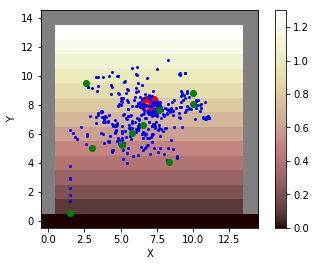

In [12]:
# Create a grid:
dx = 1.
dy=1.
grid = RasterModelGrid((15, 15), (dx, dy))

S=0.1
z = grid.node_y*S
grid.add_field('node', 'topographic__elevation', z)
grid.set_closed_boundaries_at_grid_edges(bottom_is_closed=False, left_is_closed=True, right_is_closed=True, top_is_closed=True)


# Flow Director
fa = FlowAccumulator(grid,'topographic__elevation', flow_director='FlowDirectorSteepest')

# Linear diffuser
kappa = 0.0001
ld = LinearDiffuser(grid, linear_diffusivity=kappa)


# Clasts:
nb_clast = 10
initial_x = np.random.uniform(low=grid.x_of_node[127]-grid.dx/2, high=grid.x_of_node[127]+grid.dx/2, size=nb_clast) 
initial_y = np.random.uniform(low=grid.y_of_node[127]-grid.dy/2, high=grid.y_of_node[127]+grid.dy/2, size=nb_clast)
initial_elevation = np.ones(nb_clast)*grid.at_node['topographic__elevation'][127] - np.random.rand(nb_clast)/2
# random position within central cell, at or below surface
initial_rad = np.ones(nb_clast)*0.01

CC = ClastCollection(grid,
                     clast_x=initial_x,
                     clast_y=initial_y,
                     clast_elev=initial_elevation,
                     clast_radius=initial_rad)

# Init Figures:
figure(0)
imshow_grid(grid, grid.at_node['topographic__elevation'], color_for_closed='gray')
plot(CC['clast__x'], CC['clast__y'], 'or')


### RUN ##############
Si=1.2 # critical slope
disturbance_fqcy=0.01
d_star=5.

dt=50 # time step size, in years
runtime=2000 # total run time, in years

#uplift_rate = 0.0001
mean_trav_dist=[0]
std_trav_dist=[0]
# Analytical solution:
analytical_mean_trav_dist=[]
analytical_std_trav_dist=[]


for t in range(0,runtime,dt):
    #print(t)
    fa.run_one_step()
    ld.run_one_step(dt)
    CC.clast_solver_Exponential(dt=dt,
                                Si=Si,
                                kappa=kappa,
                                uplift=None,
                                hillslope_river__threshold=1e4,
                                lateral_spreading='on',
                                disturbance_fqcy=disturbance_fqcy,
                                d_star=d_star)
    figure(0)
    plot(CC['clast__x'][:,-1], CC['clast__y'][:,-1], 'ob', markersize=2)
    mean_trav_dist.append(np.mean(CC['total_travelled_dist'].values))
    std_trav_dist.append(np.std(CC['total_travelled_dist'].values))

    analytical_mean_trav_dist.append(t/dt*np.mean(CC['lambda_0'].values)*(Si + S)/(Si - S))
    analytical_std_trav_dist.append(np.sqrt(2*t/dt)*np.mean(CC['lambda_0'].values)*(Si+S)/(Si-S))

figure(0)
plot(CC['clast__x'][:,-1], CC['clast__y'][:,-1], 'og')


The clasts are initially positioned randomly in the central cell (red dots), they move globally towards the south (blue dots are intermediate positions during the run, green dots are final positions). 

If the 'lateral_spreading' option is on, they can move laterally and even upslope (the steeper the slope and the larger the clast, the less this happens). Once they reach the south boundary cells, they exit the grid and are not moved anymore.


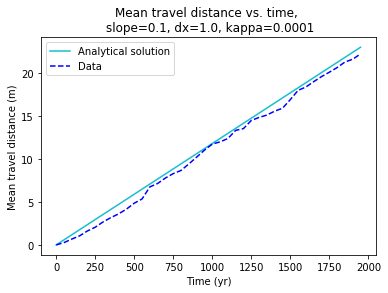

In [13]:
# Check mean travel distance versus analytical solution:
figure(300)
plot(range(0,runtime,dt), analytical_mean_trav_dist, 'tab:cyan', label="Analytical solution")
plot(range(0,runtime,dt), mean_trav_dist[0:-1], '--b', label="Data")
xlabel('Time (yr)')
ylabel('Mean travel distance (m)')
legend(loc='upper left')
title("Mean travel distance vs. time, \n slope=%s, dx=%s, kappa=%s" % (S, dx, kappa));

_**Note: What should be the analytical solution if we add burial?**_

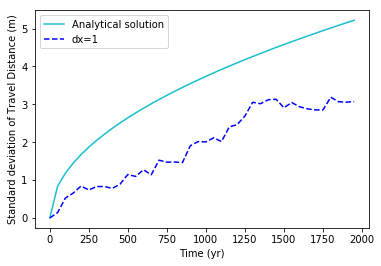

In [14]:
figure(3000)
plot(range(0,runtime,dt), analytical_std_trav_dist, 'tab:cyan', label="Analytical solution")
plot(range(0,runtime,dt), std_trav_dist[0:-1], '--b', label="dx=1")
xlabel('Time (yr)')
ylabel('Standard deviation of Travel Distance (m)')
legend(loc='upper left');

# Misc. tests:
## Insensitivity do dx
Following plot to show that mean travel distance does not depend on grid cell size:

CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29925
change_x = 0.0
change_y = -0.521907693687
move_to
dist_to_travel:
0.00905011272033835
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29925
change_x = 0.0
change_y = -0.521907693687
move_to
dist_to_travel:
0.020442334606019512
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29925
change_x = 0.0
change_y = -0.521907693687
move_to
dist_to_travel:
0.010875295256505532
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29925
change_x = 0.0
change_y = -0.521907693687
move_to
dist_to_travel:
0.0027496977611899927
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29925
change_x = 0.0
change_y = -0.52

MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29925
change_x = 0.0
change_y = -0.521907693687
move_to
dist_to_travel:
0.015715539682907013
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29925
change_x = 0.0
change_y = -0.521907693687
move_to
dist_to_travel:
0.0009101701975330215
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29925
change_x = 0.0
change_y = -0.521907693687
move_to
dist_to_travel:
0.0018841238096747835
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29925
change_x = 0.0
change_y = -0.521907693687
move_to
dist_to_travel:
0.0077927590865985675
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going S

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29925
change_x = 0.0
change_y = -0.521907693687
move_to
dist_to_travel:
0.00075632263404116
moving
MOVE IN CELL
moved
elevation updated
CLAST 80
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29925
change_x = 0.0
change_y = -0.521907693687
move_to
dist_to_travel:
0.0034332893553767115
moving
MOVE IN CELL
moved
elevation updated
CLAST 81
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29925
change_x = 0.0
change_y = -0.521907693687
move_to
dist_to_travel:
0.010737965332705676
moving
MOVE IN CELL
moved
elevation updated
CLAST 82
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29925
change_x = 0.0
change_y = -0.521907693687
move_to
dist_to_travel:
0.010559364363594522
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29925
change_x = 0.0
change_y = -0.521907693687
move_to
dist_t

dist_to_travel:
0.006850213967431988
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850374999999996
change_x = 0.0
change_y = -0.513432747626
move_to
dist_to_travel:
0.011800429416169883
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850374999999996
change_x = 0.0
change_y = -0.494965118909
move_to
dist_to_travel:
0.004052344999948656
moving
MOVE IN CELL
moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850374999999996
change_x = 0.0
change_y = -0.502719803275
move_to
dist_to_travel:
0.02365993992824833
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850374999999996
change_x = 0.0
change_y = -0.5144951298
move_to
dist_to_travel:
0.003172810334525544
moving
MOVE IN CELL
moved
elevatio

CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850374999999996
change_x = 0.0
change_y = -0.518630962143
move_to
dist_to_travel:
0.0004767956653762229
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850374999999996
change_x = 0.0
change_y = -0.489698836177
move_to
dist_to_travel:
0.008413991354383725
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850374999999996
change_x = 0.0
change_y = -0.512295141113
move_to
dist_to_travel:
0.011677848043585763
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850374999999996
change_x = 0.0
change_y = -0.516351317994
move_to
dist_to_travel:
0.05625922858462057
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood

moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850374999999996
change_x = 0.0
change_y = -0.52086033281
move_to
dist_to_travel:
0.014064996249149146
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850374999999996
change_x = 0.0
change_y = -0.516647181115
move_to
dist_to_travel:
0.009278403141135361
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29776123125
change_x = 0.0
change_y = -0.506671832624
move_to
dist_to_travel:
0.0004408643590086598
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29776123125
change_x = 0.0
change_y = -0.47744824208
move_to
dist_to_travel:
0.0029335105185484787
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
nei

move_to
dist_to_travel:
0.014706226234031972
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29776123125
change_x = 0.0
change_y = -0.47380593306
move_to
dist_to_travel:
0.007371935486679011
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29776123125
change_x = 0.0
change_y = -0.506011343592
move_to
dist_to_travel:
0.00046707194995270434
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29776123125
change_x = 0.0
change_y = -0.48848667631
move_to
dist_to_travel:
0.02486441178930942
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29776123125
change_x = 0.0
change_y = -0.503049448594
move_to
dist_to_travel:
0.014211470449577481
moving
MOVE IN CELL
moved
elevation updated
CLAS

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29776123125
change_x = 0.0
change_y = -0.490004527693
move_to
dist_to_travel:
0.024021962165965107
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29776123125
change_x = 0.0
change_y = -0.513385008927
move_to
dist_to_travel:
0.053815333801135096
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29776123125
change_x = 0.0
change_y = -0.502631590833
move_to
dist_to_travel:
0.02655197523347584
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29776123125
change_x = 0.0
change_y = -0.504313230414
move_to
dist_to_travel:
0.015890872102447367
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29776123125
change_x = 0.0
change_y = -

moved
elevation updated
CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.297022425
change_x = 0.0
change_y = -0.471142076106
move_to
dist_to_travel:
0.0019139438658161818
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.297022425
change_x = 0.0
change_y = -0.399052995697
move_to
dist_to_travel:
0.03737460094923286
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.297022425
change_x = 0.0
change_y = -0.509625477824
move_to
dist_to_travel:
0.02480521180580949
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.297022425
change_x = 0.0
change_y = -0.466989602385
move_to
dist_to_travel:
0.0653975002064895
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going Sout

MOVE IN CELL
moved
elevation updated
CLAST 66
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.297022425
change_x = 0.0
change_y = -0.481651069686
move_to
dist_to_travel:
0.0008597181683271749
moving
MOVE IN CELL
moved
elevation updated
CLAST 67
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.297022425
change_x = 0.0
change_y = -0.481140625361
move_to
dist_to_travel:
0.02068171014090518
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.297022425
change_x = 0.0
change_y = -0.451329410738
move_to
dist_to_travel:
0.001792489172481784
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.297022425
change_x = 0.0
change_y = -0.470897495778
move_to
dist_to_travel:
0.004044066665536871
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
neighbo

going South
-0.29628731250234375
change_x = 0.0
change_y = -0.478496146895
move_to
dist_to_travel:
0.01414124561324156
moving
MOVE IN CELL
moved
elevation updated
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29628731250234375
change_x = 0.0
change_y = -0.497341146029
move_to
dist_to_travel:
0.007112927880726863
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29628731250234375
change_x = 0.0
change_y = -0.388950650219
move_to
dist_to_travel:
0.02339366357173715
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29628731250234375
change_x = 0.0
change_y = -0.487590413328
move_to
dist_to_travel:
0.010449913048245395
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29628731250234375
change_x = 0.0
change_y = -0.45859693

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29628731250234375
change_x = 0.0
change_y = -0.425599679796
move_to
dist_to_travel:
0.021402645390345254
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29628731250234375
change_x = 0.0
change_y = -0.470925155385
move_to
dist_to_travel:
0.030128480029081556
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29628731250234375
change_x = 0.0
change_y = -0.476375699288
move_to
dist_to_travel:
0.01445188605790565
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29628731250234375
change_x = 0.0
change_y = -0.415448846697
move_to
dist_to_travel:
0.009283268159291022
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.296287312502343

move_to
dist_to_travel:
0.03184927906545293
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29555587501400626
change_x = 0.0
change_y = -0.401613958901
move_to
dist_to_travel:
0.02555199246384525
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29555587501400626
change_x = 0.0
change_y = -0.474789982211
move_to
dist_to_travel:
0.02951404714205402
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29555587501400626
change_x = 0.0
change_y = -0.465949031624
move_to
dist_to_travel:
0.0031363008299617307
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29555587501400626
change_x = 0.0
change_y = -0.397833628683
move_to
dist_to_travel:
0.03584772679133591
moving
MOVE IN CELL
moved
elev

move_to
dist_to_travel:
0.013800891037207181
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29555587501400626
change_x = 0.0
change_y = -0.450687901588
move_to
dist_to_travel:
0.0005169985221417585
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29555587501400626
change_x = 0.0
change_y = -0.466726420726
move_to
dist_to_travel:
0.007382256392582476
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29555587501400626
change_x = 0.0
change_y = -0.502392527703
move_to
dist_to_travel:
0.009889492161638634
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29555587501400626
change_x = 0.0
change_y = -0.397753139164
move_to
dist_to_travel:
0.03305906577545967
moving
MOVE IN CELL
mov

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29555587501400626
change_x = 0.0
change_y = -0.45636251694
move_to
dist_to_travel:
0.00806439601974157
moving
MOVE IN CELL
moved
elevation updated
CLAST 82
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29555587501400626
change_x = 0.0
change_y = -0.44627180074
move_to
dist_to_travel:
0.0047612532160032145
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29555587501400626
change_x = 0.0
change_y = -0.467494639994
move_to
dist_to_travel:
0.003186736846614311
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29555587501400626
change_x = 0.0
change_y = -0.429573551418
move_to
dist_to_travel:
0.015507806346232783
moving
MOVE IN CELL
moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2955558750140062

-0.2948280937988261
change_x = 0.0
change_y = -0.409565634028
move_to
dist_to_travel:
0.032679753551334075
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948280937988261
change_x = 0.0
change_y = -0.429757543364
move_to
dist_to_travel:
0.01903681670552862
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948280937988261
change_x = 0.0
change_y = -0.473239794752
move_to
dist_to_travel:
0.016510585819413132
moving
MOVE IN CELL
moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948280937988261
change_x = 0.0
change_y = -0.463010978354
move_to
dist_to_travel:
0.001839783009550729
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948280937988261
change_x = 0.0
change_y = -0.430351130782
move_to
dis

moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948280937988261
change_x = 0.0
change_y = -0.427912441789
move_to
dist_to_travel:
0.03983309107173781
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948280937988261
change_x = 0.0
change_y = -0.460778386934
move_to
dist_to_travel:
0.03287554378587304
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948280937988261
change_x = 0.0
change_y = -0.39893354379
move_to
dist_to_travel:
0.02621100042527588
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948280937988261
change_x = 0.0
change_y = -0.417166993409
move_to
dist_to_travel:
0.03337017361272382
moving
MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
detached
[13 17 11  7 18 16  6  

neighborhood
going South
-0.2948280937988261
change_x = 0.0
change_y = -0.470161743272
move_to
dist_to_travel:
0.02295540244288448
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948280937988261
change_x = 0.0
change_y = -0.47018917871
move_to
dist_to_travel:
0.0011456870675066093
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941039501296835
change_x = 0.0
change_y = -0.392752765434
move_to
dist_to_travel:
0.022933243996910206
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941039501296835
change_x = 0.0
change_y = -0.368888483886
move_to
dist_to_travel:
0.0007470681762564336
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941039501296835
change_x = 0.0
change_y = -0.4

moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941039501296835
change_x = 0.0
change_y = -0.343896591709
move_to
dist_to_travel:
0.002928668185238849
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941039501296835
change_x = 0.0
change_y = -0.31454897829
move_to
dist_to_travel:
0.016312483612348876
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941039501296835
change_x = 0.0
change_y = -0.387835000213
move_to
dist_to_travel:
0.002924375366915395
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941039501296835
change_x = 0.0
change_y = -0.354404864698
move_to
dist_to_travel:
0.003934745589683756
moving
MOVE IN CELL
moved
elevation updated
CLAST 51
not phantom
detached
[13 17 11  7 18 16 

moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941039501296835
change_x = 0.0
change_y = -0.398261866372
move_to
dist_to_travel:
0.010647363833405206
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941039501296835
change_x = 0.0
change_y = -0.398040791865
move_to
dist_to_travel:
0.01276903827191537
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941039501296835
change_x = 0.0
change_y = -0.355385332023
move_to
dist_to_travel:
0.013311079919471051
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941039501296835
change_x = 0.0
change_y = -0.394074412979
move_to
dist_to_travel:
0.0009224661032920452
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29338342529062533
change_x = 0.0
change_y = -0.301314941154
move_to
dist_to_travel:
0.013750460738281347
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29338342529062533
change_x = 0.0
change_y = -0.430532896877
move_to
dist_to_travel:
0.010484313804949043
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29338342529062533
change_x = 0.0
change_y = -0.250209114363
move_to
dist_to_travel:
0.014958906926556168
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29338342529062533
change_x = 0.0
change_y = -0.431554033528
move_to
dist_to_travel:
0.014898599491897412
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29338342529062

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29338342529062533
change_x = 0.0
change_y = -0.364576531601
move_to
dist_to_travel:
0.01081196573024658
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29338342529062533
change_x = 0.0
change_y = -0.437080410349
move_to
dist_to_travel:
0.0007570659525467211
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29338342529062533
change_x = 0.0
change_y = -0.462393295716
move_to
dist_to_travel:
0.002093118015875782
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2926665005789383
change_x = 0.0
change_y = -0.365757185668
move_to
dist_to_travel:
0.015496313800295721
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2926665005789383


dist_to_travel:
0.025770640963582156
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2926665005789383
change_x = 0.0
change_y = -0.342888755285
move_to
dist_to_travel:
0.015826712725709475
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2926665005789383
change_x = 0.0
change_y = -0.406141554641
move_to
dist_to_travel:
0.01562534504822519
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2926665005789383
change_x = 0.0
change_y = -0.476076762068
move_to
dist_to_travel:
0.014085668393546582
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2926665005789383
change_x = 0.0
change_y = -0.28750885208
move_to
dist_to_travel:
0.01831258283532854
moving
MOVE IN CELL
moved
elevation up

moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2926665005789383
change_x = 0.0
change_y = -0.378141648425
move_to
dist_to_travel:
0.027846585903880353
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2926665005789383
change_x = 0.0
change_y = -0.380736535005
move_to
dist_to_travel:
0.03656730651691833
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2926665005789383
change_x = 0.0
change_y = -0.278495525635
move_to
dist_to_travel:
0.014312749556408332
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2926665005789383
change_x = 0.0
change_y = -0.388207344663
move_to
dist_to_travel:
0.030139462698547854
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16 

change_x = 0.0
change_y = -0.206778234387
move_to
dist_to_travel:
0.01507994296558673
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2919531573071701
change_x = 0.0
change_y = -0.409414684697
move_to
dist_to_travel:
0.02078169335308147
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2919531573071701
change_x = 0.0
change_y = -0.300497502214
move_to
dist_to_travel:
0.009338750417896512
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2919531573071701
change_x = 0.0
change_y = -0.38951699896
move_to
dist_to_travel:
0.0029057562055312285
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2919531573071701
change_x = 0.0
change_y = -0.397772685551
move_to
dist_to_travel:
0.010879

-0.2919531573071701
change_x = 0.0
change_y = -0.35496270474
move_to
dist_to_travel:
0.0017076804751129698
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2919531573071701
change_x = 0.0
change_y = -0.324004283978
move_to
dist_to_travel:
0.005807443417600811
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2919531573071701
change_x = 0.0
change_y = -0.292894747048
move_to
dist_to_travel:
0.03418007253712079
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2919531573071701
change_x = 0.0
change_y = -0.371437223753
move_to
dist_to_travel:
0.004631862573998554
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2919531573071701
change_x = 0.0
change_y = -0.422

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2912433768051014
change_x = 0.0
change_y = -0.343297364029
move_to
dist_to_travel:
0.007375458639692225
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2912433768051014
change_x = 0.0
change_y = -0.424024057521
move_to
dist_to_travel:
0.015600650898630011
moving
MOVE IN CELL
moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2912433768051014
change_x = 0.0
change_y = -0.400947794349
move_to
dist_to_travel:
0.0045398897560320695
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2912433768051014
change_x = 0.0
change_y = -0.259451018267
move_to
dist_to_travel:
0.012543470146468358
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2912433768051014


change_x = 0.0
change_y = -0.311075864291
move_to
dist_to_travel:
0.013426463852641304
moving
MOVE IN CELL
moved
elevation updated
CLAST 66
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2912433768051014
change_x = 0.0
change_y = -0.376078602145
move_to
dist_to_travel:
0.02063871637982856
moving
MOVE IN CELL
moved
elevation updated
CLAST 67
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2912433768051014
change_x = 0.0
change_y = -0.378845589202
move_to
dist_to_travel:
0.007091105882860479
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2912433768051014
change_x = 0.0
change_y = -0.353187646854
move_to
dist_to_travel:
0.003590220476749201
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2912433768051014
change_x = 0.0
change_y = -0.318136149904
move_to
dist_to_travel:
0.00742

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29053714042166784
change_x = 0.0
change_y = -0.279163341061
move_to
dist_to_travel:
0.10359558094851047
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29053714042166784
change_x = 0.0
change_y = -0.399366217787
move_to
dist_to_travel:
0.019756162785583235
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29053714042166784
change_x = 0.0
change_y = -0.275816809941
move_to
dist_to_travel:
0.002079125726611731
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29053714042166784
change_x = 0.0
change_y = -0.263999678477
move_to
dist_to_travel:
0.10931716291712056
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2905371404216678

change_y = -0.315266582207
move_to
dist_to_travel:
0.00352634560968873
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29053714042166784
change_x = 0.0
change_y = -0.335043831023
move_to
dist_to_travel:
0.0407427425072089
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29053714042166784
change_x = 0.0
change_y = -0.239154527614
move_to
dist_to_travel:
0.017141669326652204
moving
MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29053714042166784
change_x = 0.0
change_y = -0.297593028024
move_to
dist_to_travel:
0.014711795037938442
moving
MOVE IN CELL
moved
elevation updated
CLAST 66
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29053714042166784
change_x = 0.0
change_y = -0.355372568294
move_to
dist_to_travel:
0.010004797388937179

neighborhood
going South
-0.2898344295268343
change_x = 0.0
change_y = -0.154653425766
move_to
dist_to_travel:
0.001011891253456904
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2898344295268343
change_x = 0.0
change_y = -0.325736828885
move_to
dist_to_travel:
0.0009163654495699753
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2898344295268343
change_x = 0.0
change_y = -0.328639538973
move_to
dist_to_travel:
0.0013794185596558272
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2898344295268343
change_x = 0.0
change_y = -0.395558736173
move_to
dist_to_travel:
0.009764909789609557
moving
MOVE IN CELL
moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2898344295268343
change_x = 0.0
change_y =

change_x = 0.0
change_y = -0.328141051788
move_to
dist_to_travel:
0.00641620128664986
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2898344295268343
change_x = 0.0
change_y = -0.299073164491
move_to
dist_to_travel:
0.006729393800639516
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2898344295268343
change_x = 0.0
change_y = -0.311681610326
move_to
dist_to_travel:
0.004487375936230298
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2898344295268343
change_x = 0.0
change_y = -0.294245741874
move_to
dist_to_travel:
0.020060440571524837
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2898344295268343
change_x = 0.0
change_y = -0.221971106263
move_to
dist_to_travel:
0.05869

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2891352255134212
change_x = 0.0
change_y = -0.386494974369
move_to
dist_to_travel:
0.006168921517647722
moving
MOVE IN CELL
moved
elevation updated
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2891352255134212
change_x = 0.0
change_y = -0.370486714837
move_to
dist_to_travel:
0.008334830962196938
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2891352255134212
change_x = 0.0
change_y = -0.139244812279
move_to
dist_to_travel:
0.0007367237005158663
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2891352255134212
change_x = 0.0
change_y = -0.357870321948
move_to
dist_to_travel:
0.003983037114586876
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2891352255134212


[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2891352255134212
change_x = 0.0
change_y = -0.249079443316
move_to
dist_to_travel:
0.03356902058531128
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2891352255134212
change_x = 0.0
change_y = -0.324277157154
move_to
dist_to_travel:
0.020829917841777932
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2891352255134212
change_x = 0.0
change_y = -0.204417788749
move_to
dist_to_travel:
0.01897749435321376
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2891352255134212
change_x = 0.0
change_y = -0.381434337424
move_to
dist_to_travel:
0.014497656922693046
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2891352255134212
cha

-0.2891352255134212
change_x = 0.0
change_y = -0.160066546883
move_to
dist_to_travel:
0.012002494137469644
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2891352255134212
change_x = 0.0
change_y = -0.156168847771
move_to
dist_to_travel:
0.021889088825981177
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2891352255134212
change_x = 0.0
change_y = -0.312349543251
move_to
dist_to_travel:
0.008926041375670813
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2891352255134212
change_x = 0.0
change_y = -0.372291475287
move_to
dist_to_travel:
0.02523439023506533
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2891352255134212
change_x = 0.0
change_y = -0.227121813325
move_to
dis

CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28843950979888455
change_x = 0.0
change_y = -0.277494209
move_to
dist_to_travel:
0.0190475527708086
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28843950979888455
change_x = 0.0
change_y = -0.261222848088
move_to
dist_to_travel:
0.024528279809950693
moving
MOVE IN CELL
moved
elevation updated
CLAST 51
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28843950979888455
change_x = 0.0
change_y = -0.272418962904
move_to
dist_to_travel:
0.002131481148377092
moving
MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28843950979888455
change_x = 0.0
change_y = -0.215470460485
move_to
dist_to_travel:
0.007156363884109244
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
goin

going South
-0.28843950979888455
change_x = 0.0
change_y = -0.3437968215
move_to
dist_to_travel:
0.007840527454086648
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28843950979888455
change_x = 0.0
change_y = -0.249264929515
move_to
dist_to_travel:
0.03330966660761451
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28843950979888455
change_x = 0.0
change_y = -0.148036597126
move_to
dist_to_travel:
0.008904078091435043
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28843950979888455
change_x = 0.0
change_y = -0.134254859357
move_to
dist_to_travel:
0.030329624740715343
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28843950979888455
change_x = 0.0
change_y = -0.303367237

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28774726382705085
change_x = 0.0
change_y = -0.211015338399
move_to
dist_to_travel:
0.03888079024249648
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28774726382705085
change_x = 0.0
change_y = -0.258399068275
move_to
dist_to_travel:
0.007990503544991678
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28774726382705085
change_x = 0.0
change_y = -0.23665098555
move_to
dist_to_travel:
0.014353569094534011
moving
MOVE IN CELL
moved
elevation updated
CLAST 51
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28774726382705085
change_x = 0.0
change_y = -0.270237713542
move_to
dist_to_travel:
0.0016958970810199993
moving
MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going Sou

going South
-0.28774726382705085
change_x = 0.0
change_y = -0.30348736731
move_to
dist_to_travel:
0.010936128019845531
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28774726382705085
change_x = 0.0
change_y = -0.363896265168
move_to
dist_to_travel:
0.0076687207611730954
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28774726382705085
change_x = 0.0
change_y = -0.33589443419
move_to
dist_to_travel:
0.0018676605791848608
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28774726382705085
change_x = 0.0
change_y = -0.215915498921
move_to
dist_to_travel:
0.009149126543371647
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28774726382705085
change_x = 0.0
change_y = -0.139106

detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2870584690698066
change_x = 0.0
change_y = -0.254870542484
move_to
dist_to_travel:
0.007019612297725209
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2870584690698066
change_x = 0.0
change_y = -0.133486816182
move_to
dist_to_travel:
0.022887674265975894
moving
MOVE IN CELL
moved
elevation updated
CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2870584690698066
change_x = 0.0
change_y = -0.0666841529301
move_to
dist_to_travel:
0.0102707489410413
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2870584690698066
change_x = 0.0
change_y = -0.0714790976136
move_to
dist_to_travel:
0.025818272896971074
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.287058469

CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2870584690698066
change_x = 0.0
change_y = -0.272226784126
move_to
dist_to_travel:
0.035769004257236295
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2870584690698066
change_x = 0.0
change_y = -0.282074230339
move_to
dist_to_travel:
0.0208530739585885
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2870584690698066
change_x = 0.0
change_y = -0.161327429675
move_to
dist_to_travel:
0.04980970474029532
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2870584690698066
change_x = 0.0
change_y = -0.118882381206
move_to
dist_to_travel:
0.028165051304539362
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going 

moved
elevation updated
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28637310702874397
change_x = 0.0
change_y = -0.295302719731
move_to
dist_to_travel:
0.013054917609432054
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28637310702874397
change_x = 0.0
change_y = -0.119408785782
move_to
dist_to_travel:
0.008339912447671195
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28637310702874397
change_x = 0.0
change_y = -0.265486501253
move_to
dist_to_travel:
0.039564393269917376
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28637310702874397
change_x = 0.0
change_y = -0.178967301363
move_to
dist_to_travel:
0.004762312642682972
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 1

dist_to_travel:
0.002526199428579297
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28637310702874397
change_x = 0.0
change_y = -0.304576243875
move_to
dist_to_travel:
0.011738013513188383
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28637310702874397
change_x = 0.0
change_y = -0.226714902217
move_to
dist_to_travel:
0.09022033993746842
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28637310702874397
change_x = 0.0
change_y = -0.279156939894
move_to
dist_to_travel:
0.004179921104238379
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28637310702874397
change_x = 0.0
change_y = -0.140049372034
move_to
dist_to_travel:
0.020532505577125146
moving
MOVE IN CELL
moved
elevat

moved
elevation updated
CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2856911592367641
change_x = 0.0
change_y = -0.260185411122
move_to
dist_to_travel:
0.020610793691267035
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2856911592367641
change_x = 0.0
change_y = -0.184347394304
move_to
dist_to_travel:
0.015772510542650407
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2856911592367641
change_x = 0.0
change_y = -0.284986573078
move_to
dist_to_travel:
0.035896544720545924
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2856911592367641
change_x = 0.0
change_y = -0.350256574551
move_to
dist_to_travel:
0.004696826391874136
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  

dist_to_travel:
0.006611761028662474
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2856911592367641
change_x = 0.0
change_y = -0.0297088574521
move_to
dist_to_travel:
0.012485309396793931
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2856911592367641
change_x = 0.0
change_y = -0.270511048339
move_to
dist_to_travel:
0.061926899568667614
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2856911592367641
change_x = 0.0
change_y = -0.17214243285
move_to
dist_to_travel:
0.045186654958051554
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2856911592367641
change_x = 0.0
change_y = -0.0833187114381
move_to
dist_to_travel:
0.007555980746732306
moving
MOVE IN CELL
moved
elevatio

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2856911592367641
change_x = 0.0
change_y = -0.0917015698107
move_to
dist_to_travel:
0.011823738032249675
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2856911592367641
change_x = 0.0
change_y = -0.028756235652
move_to
dist_to_travel:
0.0009376523771296358
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2856911592367641
change_x = 0.0
change_y = -0.220557229065
move_to
dist_to_travel:
0.0033198134197752653
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2856911592367641
change_x = 0.0
change_y = -0.251871481484
move_to
dist_to_travel:
0.015048678827594385
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.285691159236764

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2850126072596374
change_x = 0.0
change_y = -0.244042959375
move_to
dist_to_travel:
0.002225718885232538
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2850126072596374
change_x = 0.0
change_y = -0.153847321535
move_to
dist_to_travel:
0.015577594093693544
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2850126072596374
change_x = 0.0
change_y = -0.264872170079
move_to
dist_to_travel:
0.0012648924352661845
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2850126072596374
change_x = 0.0
change_y = -0.211251091986
move_to
dist_to_travel:
0.010070433049925883
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2850126072596374


moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2850126072596374
change_x = 0.0
change_y = -0.115163954289
move_to
dist_to_travel:
0.007845912108401971
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2850126072596374
change_x = 0.0
change_y = -0.0927644203949
move_to
dist_to_travel:
0.017281635273659914
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2850126072596374
change_x = 0.0
change_y = -0.183449973688
move_to
dist_to_travel:
0.009983806153565276
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2850126072596374
change_x = 0.0
change_y = -0.219250673025
move_to
dist_to_travel:
0.0019243960716165593
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
deta

-0.28433743269752304
change_x = 0.0
change_y = -0.179657072638
move_to
dist_to_travel:
0.013406588574285633
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28433743269752304
change_x = 0.0
change_y = -0.227601024388
move_to
dist_to_travel:
0.015943022498156066
moving
MOVE IN CELL
moved
elevation updated
CLAST 11
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28433743269752304
change_x = 0.0
change_y = -0.204397113121
move_to
dist_to_travel:
0.005765314535258876
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28433743269752304
change_x = 0.0
change_y = -0.15855043626
move_to
dist_to_travel:
0.018887161031865888
moving
MOVE IN CELL
moved
elevation updated
CLAST 13
not phantom
CLAST 14
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28433743269752304
change_x = 0.0
change_y = -

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28433743269752304
change_x = 0.0
change_y = -0.048043065513
move_to
dist_to_travel:
0.010225782084982258
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28433743269752304
change_x = 0.0
change_y = -0.0988530136605
move_to
dist_to_travel:
0.012465282996316636
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28433743269752304
change_x = 0.0
change_y = -0.249164896098
move_to
dist_to_travel:
0.02923324049616773
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28433743269752304
change_x = 0.0
change_y = -0.124227943837
move_to
dist_to_travel:
0.014328866084635272
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28433743269752

change_x = 0.0
change_y = -0.139835291955
move_to
dist_to_travel:
0.016109828292044024
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28366561718644734
change_x = 0.0
change_y = -0.22248624059
move_to
dist_to_travel:
0.0032651483666502616
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28366561718644734
change_x = 0.0
change_y = -0.329422978682
move_to
dist_to_travel:
0.021714016973021794
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28366561718644734
change_x = 0.0
change_y = -0.142789203938
move_to
dist_to_travel:
0.004926359237636807
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28366561718644734
change_x = 0.0
change_y = -0.0713064525699
move_to
dist_to_travel:
0.015

dist_to_travel:
0.004789856644892079
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28366561718644734
change_x = 0.0
change_y = -0.0354522181417
move_to
dist_to_travel:
0.028937534614669035
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28366561718644734
change_x = 0.0
change_y = -0.171820956505
move_to
dist_to_travel:
0.007222811028357609
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28366561718644734
change_x = 0.0
change_y = -0.264409328249
move_to
dist_to_travel:
0.008076753327128195
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28366561718644734
change_x = 0.0
change_y = -0.25773252133
move_to
dist_to_travel:
0.021515143693780336
moving
MOVE IN CELL
moved
eleva

change_x = 0.0
change_y = -0.247892429153
move_to
dist_to_travel:
0.018995886458672822
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28366561718644734
change_x = 0.0
change_y = -0.271078558582
move_to
dist_to_travel:
0.0012665541937118346
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28366561718644734
change_x = 0.0
change_y = -0.144396537253
move_to
dist_to_travel:
0.015137023532542452
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28366561718644734
change_x = 0.0
change_y = -0.0688983109476
move_to
dist_to_travel:
0.040567890641005716
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28366561718644734
change_x = 0.0
change_y = -0.021054186008
move_to
dist_to_travel:


[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 28
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.0260543358
move_to
dist_to_travel:
0.002352847728757316
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 29
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.854787912015
move_to
dist_to_travel:
0.03168661777792254
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2829971423997427
change_x = 0.0
change_y = -0.187467794507
move_to
dist_to_travel:
0.00793805298269633
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached


[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2829971423997427
change_x = 0.0
change_y = -0.132110473852
move_to
dist_to_travel:
0.013337401644545863
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2829971423997427
change_x = 0.0
change_y = -0.204782826771
move_to
dist_to_travel:
0.0009837867237088478
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2829971423997427
change_x = 0.0
change_y = -0.0745336631409
move_to
dist_to_travel:
0.002187033645982644
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2829971423997427
change_x = 0.0
change_y = -0.0355112110448
move_to
dist_to_travel:
0.0945939580816959
moving
MOVE OUT OF CELL
[13 17 11  7 18 16  6  8]
going South
-0.2829971423997427
change_x = 0.0
change_y = -0.0355112110448
moving
MOVE OUT OF C

moved
elevation updated
CLAST 13
not phantom
CLAST 14
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28233199004944753
change_x = 0.0
change_y = -0.189841325303
move_to
dist_to_travel:
0.010859335445942172
moving
MOVE IN CELL
moved
elevation updated
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28233199004944753
change_x = 0.0
change_y = -0.247716149423
move_to
dist_to_travel:
0.008245746962785546
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28233199004944753
change_x = 0.0
change_y = -0.0428720318973
move_to
dist_to_travel:
0.04797808123329905
moving
MOVE OUT OF CELL
[13 17 11  7 18 16  6  8]
going South
-0.28233199004944753
change_x = 0.0
change_y = -0.0428720318973
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28233199004944753
change_x = 0.0
change_y = -0

moved
elevation updated
CLAST 51
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28233199004944753
change_x = 0.0
change_y = -0.116230188262
move_to
dist_to_travel:
0.01882822703843227
moving
MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28233199004944753
change_x = 0.0
change_y = -0.0840785376299
move_to
dist_to_travel:
0.0052852606149583455
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28233199004944753
change_x = 0.0
change_y = -0.0188029085417
move_to
dist_to_travel:
0.004284267956971384
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28233199004944753
change_x = 0.0
change_y = -0.0285024604472
move_to
dist_to_travel:
0.002402409670439898
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  

change_x = 0.0
change_y = -0.195332949239
move_to
dist_to_travel:
0.043025444421523416
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28233199004944753
change_x = 0.0
change_y = -0.156102395173
move_to
dist_to_travel:
0.06360918079327074
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28233199004944753
change_x = 0.0
change_y = -0.155883641988
move_to
dist_to_travel:
0.009334493915807056
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28233199004944753
change_x = 0.0
change_y = -0.250796316443
move_to
dist_to_travel:
0.003072645359859616
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28233199004944753
change_x = 0.0
change_y = -0.019358985829
move_to
dist_to_travel:
0.0

going South
-0.28167014188766726
change_x = 0.0
change_y = -0.162849208603
move_to
dist_to_travel:
0.011187255529889037
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28167014188766726
change_x = 0.0
change_y = -0.140151411058
move_to
dist_to_travel:
0.010543069765662778
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28167014188766726
change_x = 0.0
change_y = -0.0701295225979
move_to
dist_to_travel:
0.008910790655779668
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28167014188766726
change_x = 0.0
change_y = -0.230322610742
move_to
dist_to_travel:
0.008465565129561975
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28167014188766726
change_x = 0.0
change_y = -0.12686

detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28167014188766726
change_x = 0.0
change_y = -0.184723400367
move_to
dist_to_travel:
0.025544852393430944
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28167014188766726
change_x = 0.0
change_y = -0.145367382285
move_to
dist_to_travel:
0.05444778095208108
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28167014188766726
change_x = 0.0
change_y = -0.0406040404249
move_to
dist_to_travel:
0.022505197329579053
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28167014188766726
change_x = 0.0
change_y = -0.02375189359
move_to
dist_to_travel:
0.0015123876371938528
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2810115797078989
change_x = 0.0
change_y = -0.203873173006
move_to
dist_to_travel:
0.00535221785406892
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2810115797078989
change_x = 0.0
change_y = -0.00490373068238
move_to
dist_to_travel:
7.020059361584155e-05
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2810115797078989
change_x = 0.0
change_y = -0.13438196514
move_to
dist_to_travel:
0.015727861331150467
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2810115797078989
change_x = 0.0
change_y = -0.0327670984014
move_to
dist_to_travel:
0.00931907833057076
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 


[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2810115797078989
change_x = 0.0
change_y = -0.0568192008687
move_to
dist_to_travel:
0.046228082756075685
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2810115797078989
change_x = 0.0
change_y = -0.110985628864
move_to
dist_to_travel:
0.034957291684039896
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 64
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.03401860678
move_to
dist_to_travel:
0.004310240220807466
moving
MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
CLAST 66
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:


MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2810115797078989
change_x = 0.0
change_y = -0.248231325682
move_to
dist_to_travel:
0.026021418077975
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28035628534631774
change_x = 0.0
change_y = -0.114869629719
move_to
dist_to_travel:
0.0027264511436091944
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 1
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.00259925604
move_to
dist_to_travel:
0.004936097771069913
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28035628534631774
change_x = 0.0
ch

change_y = -0.928024062896
move_to
dist_to_travel:
0.0311076558975725
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28035628534631774
change_x = 0.0
change_y = -0.100070891483
move_to
dist_to_travel:
0.011847040877932124
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28035628534631774
change_x = 0.0
change_y = -0.220582631701
move_to
dist_to_travel:
0.004577927805626194
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28035628534631774
change_x = 0.0
change_y = -0.202727072339
move_to
dist_to_travel:
0.002514152921702917
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28035628534631774
change_x = 0.0
change_y = -0.00781688157688
move_to
dist_to_travel:
0.002677050058969

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28035628534631774
change_x = 0.0
change_y = -0.0572242731348
move_to
dist_to_travel:
0.0025660964856429385
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28035628534631774
change_x = 0.0
change_y = -0.0799843207289
move_to
dist_to_travel:
0.01822421310979013
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28035628534631774
change_x = 0.0
change_y = -0.155024950419
move_to
dist_to_travel:
0.03707624907982333
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.28035628534631774
change_x = 0.0
change_y = -0.201280432295
move_to
dist_to_travel:
0.010472067928952718
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2803562853463

[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 19
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.03495679353
move_to
dist_to_travel:
0.011618178316184807
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 20
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.00093892938
move_to
dist_to_travel:
0.023011607097642144
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2797042406830281
change_x = 0.0
change_y = -0.168449541024
move_to
dist_to_travel:
0.04881976599423707
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached

detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2797042406830281
change_x = 0.0
change_y = -0.0145440620546
move_to
dist_to_travel:
0.003071774850803852
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2797042406830281
change_x = 0.0
change_y = -0.0806639310587
move_to
dist_to_travel:
0.0231291986586818
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 56
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.04048587645
move_to
dist_to_travel:
0.03293409673351298
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2797042406830281
change_x = 0.0
change_y = -0.116238886068
move_to
dist_to_travel:
0.0038

CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2797042406830281
change_x = 0.0
change_y = -0.0286891559472
move_to
dist_to_travel:
0.01200732514191254
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 91
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.987627697964
move_to
dist_to_travel:
0.006992231229915685
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 92
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.946294621667
move_to
dist_to_travel:
0.0059217651128903245
moving
MOVE IN CELL
moved
elevation upd

going South
-0.2790554276432796
change_x = 0.0
change_y = -0.0975133338404
move_to
dist_to_travel:
0.0034827657797401666
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 46
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.918689442987
move_to
dist_to_travel:
0.06886836837986436
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
CLAST 48
not phantom
CLAST 49
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 49
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.92637947444
move_to
dist_to_travel:
0.0071242415871628495
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
d

moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2790554276432796
change_x = 0.0
change_y = -0.0392106571408
move_to
dist_to_travel:
0.025071093842989813
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2790554276432796
change_x = 0.0
change_y = -0.11513641077
move_to
dist_to_travel:
0.04536767651130799
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2790554276432796
change_x = 0.0
change_y = -0.179348090273
move_to
dist_to_travel:
0.0038375189724716534
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2790554276432796
change_x = 0.0
change_y = -0.231798441347
move_to
dist_to_travel:
0.03008901402858297
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16 

[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 31
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.917336679733
move_to
dist_to_travel:
0.006350272808069027
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27840982819864757
change_x = 0.0
change_y = -0.111729117368
move_to
dist_to_travel:
0.014549698425883046
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27840982819864757
change_x = 0.0
change_y = -0.0633564539635
move_to
dist_to_travel:
0.0047791084235138965
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int6

moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27840982819864757
change_x = 0.0
change_y = -0.0580753448306
move_to
dist_to_travel:
0.005203282120932183
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 69
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.979021157067
move_to
dist_to_travel:
0.020075946953891755
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 70
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.00844918346
move_to
dist_to_travel:
0.04256415871495

CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2777674243681799
change_x = 0.0
change_y = -0.0623654740532
move_to
dist_to_travel:
0.003954430806982673
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2777674243681799
change_x = 0.0
change_y = -0.0400217833653
move_to
dist_to_travel:
0.043622091289199354
moving
MOVE OUT OF CELL
[13 17 11  7 18 16  6  8]
going South
-0.2777674243681799
change_x = 0.0
change_y = -0.0400217833653
moving
MOVE IN CELL
moved
elevation updated
CLAST 11
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2777674243681799
change_x = 0.0
change_y = -0.00797638578962
move_to
dist_to_travel:
0.017431885704736888
moving
MOVE OUT OF CELL
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 11
3
clast is next to boundary or on river cell


target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 56
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.993565808697
move_to
dist_to_travel:
0.01252215140576213
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2777674243681799
change_x = 0.0
change_y = -0.0778023795693
move_to
dist_to_travel:
0.035588673403268524
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 58
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.98945325294
move_to
dist_to_travel:
0.03266246152186764
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2

neighborhood
going South
-0.2777674243681799
change_x = 0.0
change_y = -0.0213414685951
move_to
dist_to_travel:
0.005574189638356179
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 86
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.00443164788
move_to
dist_to_travel:
0.014737183674902054
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2777674243681799
change_x = 0.0
change_y = -0.0645636225467
move_to
dist_to_travel:
0.00241658798232674
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2777674243681799
change_x = 0.0
change_y = -0.170363981728
move_to
dist_to_travel:
0.010514674028244565
moving
MOVE IN CEL

going South
-0.27712819821951085
change_x = 0.0
change_y = -0.140770064723
move_to
dist_to_travel:
0.006695510842814126
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27712819821951085
change_x = 0.0
change_y = -0.0545391150702
move_to
dist_to_travel:
0.010195086327008386
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 37
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.897974635028
move_to
dist_to_travel:
0.009468595998838194
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 38
3
neighborhood
clast is next to bou

detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 70
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.965684353127
move_to
dist_to_travel:
0.017064592808469503
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27712819821951085
change_x = 0.0
change_y = -0.0354309688706
move_to
dist_to_travel:
0.015942098997883052
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27712819821951085
change_x = 0.0
change_y = -0.0644446112609
move_to
dist_to_travel:
0.0005501826544835813
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)

dist_to_travel:
0.011285985294445628
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 24
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.906533122885
move_to
dist_to_travel:
0.07174084131252095
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 25
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.960409525035
move_to
dist_to_travel:
0.011427114020045318
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Co

move_to
dist_to_travel:
0.0006697008091009799
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2764921318699413
change_x = 0.0
change_y = -0.21696833538
move_to
dist_to_travel:
0.0162953447730675
moving
MOVE IN CELL
moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2764921318699413
change_x = 0.0
change_y = -0.0903115205896
move_to
dist_to_travel:
0.016215168541609225
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 61
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.965285129229
move_to
dist_to_travel:
0.007660047742484269
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close 

CLAST 90
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 90
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.01949809546
move_to
dist_to_travel:
0.022135586596936808
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 91
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.855053138388
move_to
dist_to_travel:
0.003397693605675579
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 92
3
neighborhood
clast is next to boundary or on r

0.04617598300873101
moving
MOVE OUT OF CELL
[13 17 11  7 18 16  6  8]
going South
-0.27585920748748816
change_x = 0.0
change_y = -0.026536827311
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 46
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.781217405747
move_to
dist_to_travel:
0.024190835928881625
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
CLAST 48
not phantom
CLAST 49
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 49
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.874943960695
move_to
dist_to_travel:
0.010544503677674271
moving
MOVE IN CELL
moved
elevation updat

close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 75
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.810328324159
move_to
dist_to_travel:
0.018535445845873237
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 76
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.947880832781
move_to
dist_to_travel:
0.015187275727741093
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 77
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.

receiver is : 2
change_x = 0.0
change_y = -1.00704512304
move_to
dist_to_travel:
0.042833888564194705
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 5
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.935252657207
move_to
dist_to_travel:
0.01786452511948664
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
CLAST 7
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 7
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.980636787924
move_to
dist_to_travel:
0.0006686186223751042
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhoo

receiver is : 2
change_x = 0.0
change_y = -0.51140203188
move_to
dist_to_travel:
0.023884537046433094
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 30
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.00067142718
move_to
dist_to_travel:
0.013692356307598852
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 31
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.89675595793
move_to
dist_to_travel:
0.04854057128569444
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2

close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 58
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.933307986829
move_to
dist_to_travel:
0.02890172530466385
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27522940729190115
change_x = 0.0
change_y = -0.188170938866
move_to
dist_to_travel:
0.00011760670919913266
moving
MOVE IN CELL
moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27522940729190115
change_x = 0.0
change_y = -0.0698275766532
move_to
dist_to_travel:
0.006036699578516208
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 61
3
neighborhood
clast 

not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27522940729190115
change_x = 0.0
change_y = -0.0433565874439
move_to
dist_to_travel:
0.0174283641869243
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27522940729190115
change_x = 0.0
change_y = -0.154577164337
move_to
dist_to_travel:
0.025983604143957274
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27522940729190115
change_x = 0.0
change_y = -0.157983028818
move_to
dist_to_travel:
0.038787488204933496
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 90
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.967084116674
move_to
dist_t

target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 43
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.02148346918
move_to
dist_to_travel:
0.055432133414631254
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 44
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.789724028732
move_to
dist_to_travel:
0.020512858507540272
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 45
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.02138483849
move_to
dist_to_trav

3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.02732232436
move_to
dist_to_travel:
0.0113476183394168
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27460271355564947
change_x = 0.0
change_y = -0.0457277986869
move_to
dist_to_travel:
0.003001360270468659
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 74
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.945098765402
move_to
dist_to_travel:
0.05071365239370413
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 7

detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2739791086048782
change_x = 0.0
change_y = -0.0288601608635
move_to
dist_to_travel:
0.01071525808155219
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2739791086048782
change_x = 0.0
change_y = -0.0123128522419
move_to
dist_to_travel:
0.008255999842333248
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 4
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.954892700725
move_to
dist_to_travel:
0.0010976063373996968
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  i

change_x = 0.0
change_y = -0.482761542391
move_to
dist_to_travel:
0.010317260012768323
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 30
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.953146473259
move_to
dist_to_travel:
0.0032242433426692765
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 31
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.848073167494
move_to
dist_to_travel:
0.023086418385830726
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.273979108604

close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 86
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.898148986953
move_to
dist_to_travel:
0.010134011106133932
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2739791086048782
change_x = 0.0
change_y = -0.00136837822576
move_to
dist_to_travel:
0.010514864016038374
moving
MOVE OUT OF CELL
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 87
3
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.04533507442
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2739791086048782
change_x = 0.0
change_y = -0.0953496149808
move_to
dist_to

not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 15
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.95945432073
move_to
dist_to_travel:
0.017757376599392576
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 16
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.927815696254
move_to
dist_to_travel:
0.018877739766709166
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27335857482033477
change_x = 0.0
change_y = -0.000993636261902
move_to
dist_to_travel:
0.01740893436082883
moving
MOVE OUT OF CELL
[ 8 12  6  2 13 11  1  

change_x = 0.0
change_y = -0.894793653992
move_to
dist_to_travel:
0.0037799837149078957
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
CLAST 72
not phantom
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27335857482033477
change_x = 0.0
change_y = -0.0197521203343
move_to
dist_to_travel:
0.01863996990419694
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 74
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.822219913626
move_to
dist_to_travel:
0.005173314093929561
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 75
3
neighborhood
clast is ne

not phantom
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27274109463826696
change_x = 0.0
change_y = -0.0159591162827
move_to
dist_to_travel:
0.005549247818952558
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 3
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.986230207333
move_to
dist_to_travel:
0.027434392941603946
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 4
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.917838456725
move_to
dist_to_travel:
0.01743124275048492
moving
MOVE IN CELL
moved
elevat

CLAST 30
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 30
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.930923542715
move_to
dist_to_travel:
0.011579703359204049
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 31
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.824480112744
move_to
dist_to_travel:
0.027335243981373512
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 32
3
neighborhood
clast is next to boundary or on 

<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 58
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.846864366113
move_to
dist_to_travel:
0.08446153075712974
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27274109463826696
change_x = 0.0
change_y = -0.120495884013
move_to
dist_to_travel:
0.01627964520753755
moving
MOVE IN CELL
moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27274109463826696
change_x = 0.0
change_y = -0.0289168430405
move_to
dist_to_travel:
0.01013390731691313
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 61
3
neighborhood
clast is next to boundary or on river cell
receiver is 

CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27274109463826696
change_x = 0.0
change_y = -0.0803863005591
move_to
dist_to_travel:
0.001994271353849211
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.27274109463826696
change_x = 0.0
change_y = -0.0940718080716
move_to
dist_to_travel:
0.01612327044287381
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 90
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.945174258731
move_to
dist_to_travel:
0.0028110951970839715
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)


[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998124999999999
change_x = 0.0
change_y = -1.04397678871
move_to
dist_to_travel:
0.010103398788023353
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998124999999999
change_x = 0.0
change_y = -1.04397678871
move_to
dist_to_travel:
0.004889720606767765
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998124999999999
change_x = 0.0
change_y = -1.04397678871
move_to
dist_to_travel:
0.015835441612334744
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998124999999999
change_x = 0.0
change_y = -1.04397678871
move_to
dist_to_travel:
0.030587324770035822
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998124999999999
chang

CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299625234375
change_x = 0.0
change_y = -0.980557844105
move_to
dist_to_travel:
0.052663073187078226
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299625234375
change_x = 0.0
change_y = -1.02932266931
move_to
dist_to_travel:
0.006626298381590739
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299625234375
change_x = 0.0
change_y = -1.03173868939
move_to
dist_to_travel:
0.06747357703324933
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299625234375
change_x = 0.0
change_y = -1.0383778178
move_to
dist_to_travel:
0.08175613222407455
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299625234375
ch

neighborhood
going South
-0.299625234375
change_x = 0.0
change_y = -1.03982861872
move_to
dist_to_travel:
0.004792707503326392
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299625234375
change_x = 0.0
change_y = -1.0281197922
move_to
dist_to_travel:
0.010325855415304884
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299625234375
change_x = 0.0
change_y = -1.03382014613
move_to
dist_to_travel:
0.029402223411240266
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299625234375
change_x = 0.0
change_y = -1.03903355581
move_to
dist_to_travel:
0.07000556066984692
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299625234375
change_x = 0.0
change_y = -1.0280883985
move_to
dist_

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29943820283203126
change_x = 0.0
change_y = -1.02264379601
move_to
dist_to_travel:
0.011595623398995702
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29943820283203126
change_x = 0.0
change_y = -0.964215541279
move_to
dist_to_travel:
0.011825875442070364
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29943820283203126
change_x = 0.0
change_y = -0.956572507438
move_to
dist_to_travel:
0.033779087073735115
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29943820283203126
change_x = 0.0
change_y = -1.029593381
move_to
dist_to_travel:
0.0034801634022835126
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29943820283203126
cha

moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29943820283203126
change_x = 0.0
change_y = -1.02984199834
move_to
dist_to_travel:
0.004697265960122055
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29943820283203126
change_x = 0.0
change_y = -1.00762100429
move_to
dist_to_travel:
0.01161811825931469
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29943820283203126
change_x = 0.0
change_y = -1.03498270195
move_to
dist_to_travel:
0.01799290379528302
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29943820283203126
change_x = 0.0
change_y = -1.01774161389
move_to
dist_to_travel:
0.041344106768507256
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached


[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299251405078125
change_x = 0.0
change_y = -1.01099628854
move_to
dist_to_travel:
0.026756682982470494
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299251405078125
change_x = 0.0
change_y = -0.952340791949
move_to
dist_to_travel:
0.009424943785103302
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299251405078125
change_x = 0.0
change_y = -0.92274606527
move_to
dist_to_travel:
0.00468341678969697
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299251405078125
change_x = 0.0
change_y = -1.02606056043
move_to
dist_to_travel:
0.0394654598662473
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299251405078125
change_x = 0.0
c

-0.299251405078125
change_x = 0.0
change_y = -1.02287077644
move_to
dist_to_travel:
0.0027344211424771333
moving
MOVE IN CELL
moved
elevation updated
CLAST 66
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299251405078125
change_x = 0.0
change_y = -0.92699361416
move_to
dist_to_travel:
0.003512299413257704
moving
MOVE IN CELL
moved
elevation updated
CLAST 67
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299251405078125
change_x = 0.0
change_y = -0.881556607487
move_to
dist_to_travel:
0.010541403494072942
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299251405078125
change_x = 0.0
change_y = -0.983301026676
move_to
dist_to_travel:
0.023161043034555524
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299251405078125
change_x = 0.0
change_y = -1.00633487208
move_to
dist_to_t

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2990648408203148
change_x = 0.0
change_y = -0.991356189995
move_to
dist_to_travel:
0.004883536325602238
moving
MOVE IN CELL
moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2990648408203148
change_x = 0.0
change_y = -0.997855695005
move_to
dist_to_travel:
0.03677146732105062
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2990648408203148
change_x = 0.0
change_y = -0.999183176864
move_to
dist_to_travel:
0.005168935495856516
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2990648408203148
change_x = 0.0
change_y = -0.966991026983
move_to
dist_to_travel:
0.01662738943532436
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2990648408203148
cha

MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2990648408203148
change_x = 0.0
change_y = -0.975870055867
move_to
dist_to_travel:
0.02152170753992888
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2990648408203148
change_x = 0.0
change_y = -0.951896349809
move_to
dist_to_travel:
0.002059833155431486
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2990648408203148
change_x = 0.0
change_y = -0.965779238184
move_to
dist_to_travel:
0.005744693325592175
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2990648408203148
change_x = 0.0
change_y = -0.943325135731
move_to
dist_to_travel:
0.05103624451066415
moving
MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
detached
[13 17 

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29887850976563873
change_x = 0.0
change_y = -0.961035082087
move_to
dist_to_travel:
0.04174693325911986
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29887850976563873
change_x = 0.0
change_y = -0.993963411876
move_to
dist_to_travel:
0.005714176056868237
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29887850976563873
change_x = 0.0
change_y = -0.950315040154
move_to
dist_to_travel:
0.026680429277742793
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29887850976563873
change_x = 0.0
change_y = -0.961496711162
move_to
dist_to_travel:
0.02781369697300241
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2988785097656387

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29887850976563873
change_x = 0.0
change_y = -0.961759385265
move_to
dist_to_travel:
6.138002805321384e-05
moving
MOVE IN CELL
moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29887850976563873
change_x = 0.0
change_y = -0.977048756003
move_to
dist_to_travel:
0.0018108064775546567
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29887850976563873
change_x = 0.0
change_y = -0.98245368605
move_to
dist_to_travel:
0.0016187896268780755
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29887850976563873
change_x = 0.0
change_y = -0.99498926594
move_to
dist_to_travel:
0.02951073414749769
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29887850976563

move_to
dist_to_travel:
0.001540780406389814
moving
MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2986924116211418
change_x = 0.0
change_y = -0.96494299254
move_to
dist_to_travel:
0.003264360936518332
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2986924116211418
change_x = 0.0
change_y = -0.98162985076
move_to
dist_to_travel:
0.0014153756434912884
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2986924116211418
change_x = 0.0
change_y = -0.912943862581
move_to
dist_to_travel:
0.00546619322616484
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2986924116211418
change_x = 0.0
change_y = -0.981376967162
move_to
dist_to_travel:
0.012883786324724863
moving
MOVE IN CELL
moved
ele

moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850654609387783
change_x = 0.0
change_y = -0.985251627338
move_to
dist_to_travel:
0.05703875737659791
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850654609387783
change_x = 0.0
change_y = -0.891213529204
move_to
dist_to_travel:
0.01702442281425534
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850654609387783
change_x = 0.0
change_y = -0.909987832397
move_to
dist_to_travel:
0.00573437788200464
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850654609387783
change_x = 0.0
change_y = -0.936770058493
move_to
dist_to_travel:
0.024141295267141066
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detach

change_x = 0.0
change_y = -0.958905348996
move_to
dist_to_travel:
0.00955351162747039
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850654609387783
change_x = 0.0
change_y = -0.857231508048
move_to
dist_to_travel:
0.036712678828201464
moving
MOVE IN CELL
moved
elevation updated
CLAST 78
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850654609387783
change_x = 0.0
change_y = -0.844466045681
move_to
dist_to_travel:
0.019647541673875914
moving
MOVE IN CELL
moved
elevation updated
CLAST 79
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850654609387783
change_x = 0.0
change_y = -0.903559900724
move_to
dist_to_travel:
0.031720688728047355
moving
MOVE IN CELL
moved
elevation updated
CLAST 80
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29850654609387783
change_x = 0.0
change_y = -0.913192818002
move_to
dist_to_travel:
0.0

-0.2983209128909123
change_x = 0.0
change_y = -0.876268532961
move_to
dist_to_travel:
0.006909923716113576
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2983209128909123
change_x = 0.0
change_y = -0.90937986722
move_to
dist_to_travel:
0.004839448018038542
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2983209128909123
change_x = 0.0
change_y = -0.935353400677
move_to
dist_to_travel:
0.002942042246024404
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2983209128909123
change_x = 0.0
change_y = -0.875141604449
move_to
dist_to_travel:
0.024377926542732048
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2983209128909123
change_x = 0.0
change_y = -0.964949939603
move_to
dis

CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2983209128909123
change_x = 0.0
change_y = -0.950546890257
move_to
dist_to_travel:
0.0031516597895169846
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2983209128909123
change_x = 0.0
change_y = -0.900006645608
move_to
dist_to_travel:
0.010186694169033422
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2983209128909123
change_x = 0.0
change_y = -0.944100177401
move_to
dist_to_travel:
0.012337760619621482
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2983209128909123
change_x = 0.0
change_y = -0.795599391349
move_to
dist_to_travel:
0.005180921283993094
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
go

CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29813551171932395
change_x = 0.0
change_y = -0.827437304425
move_to
dist_to_travel:
0.020056446562258884
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29813551171932395
change_x = 0.0
change_y = -0.922397728878
move_to
dist_to_travel:
0.0012727958755786456
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29813551171932395
change_x = 0.0
change_y = -0.893214635455
move_to
dist_to_travel:
0.003270266707772037
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29813551171932395
change_x = 0.0
change_y = -0.884625091766
move_to
dist_to_travel:
0.012577521081450119
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhoo

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2979503422862074
change_x = 0.0
change_y = -0.855174657914
move_to
dist_to_travel:
0.007033771192784551
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2979503422862074
change_x = 0.0
change_y = -0.825965106356
move_to
dist_to_travel:
0.04625031009417426
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2979503422862074
change_x = 0.0
change_y = -0.857592383147
move_to
dist_to_travel:
0.0003309612846102643
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2979503422862074
change_x = 0.0
change_y = -0.925763284599
move_to
dist_to_travel:
0.027503742324864137
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2979503422862074
c

dist_to_travel:
0.0058245037554355335
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2979503422862074
change_x = 0.0
change_y = -0.889292229912
move_to
dist_to_travel:
0.008257026835329351
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2979503422862074
change_x = 0.0
change_y = -0.919885988198
move_to
dist_to_travel:
0.0012726052478734262
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2979503422862074
change_x = 0.0
change_y = -0.77816880407
move_to
dist_to_travel:
0.0028463065505096464
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2979503422862074
change_x = 0.0
change_y = -0.903972820634
move_to
dist_to_travel:
0.007431004280147772
moving
MOVE IN CELL
moved
elevati

MOVE IN CELL
moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29776540429867515
change_x = 0.0
change_y = -0.961369604279
move_to
dist_to_travel:
0.015996785907141726
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29776540429867515
change_x = 0.0
change_y = -0.738670263286
move_to
dist_to_travel:
0.019574388595062706
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29776540429867515
change_x = 0.0
change_y = -0.863670883468
move_to
dist_to_travel:
0.0013808215896707451
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29776540429867515
change_x = 0.0
change_y = -0.897190018221
move_to
dist_to_travel:
0.006996097032180654
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached


CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29758069746385984
change_x = 0.0
change_y = -0.838347436307
move_to
dist_to_travel:
0.010340464325524977
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29758069746385984
change_x = 0.0
change_y = -0.752201585802
move_to
dist_to_travel:
0.003891017547930137
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29758069746385984
change_x = 0.0
change_y = -0.876030962034
move_to
dist_to_travel:
0.007161964733470105
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29758069746385984
change_x = 0.0
change_y = -0.852792537688
move_to
dist_to_travel:
0.017101474696626456
moving
MOVE IN CELL
moved
elevation updated
CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood

detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29758069746385984
change_x = 0.0
change_y = -0.884109031184
move_to
dist_to_travel:
0.0038815346132570496
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29758069746385984
change_x = 0.0
change_y = -0.880813146883
move_to
dist_to_travel:
0.018853271959427396
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29758069746385984
change_x = 0.0
change_y = -0.763244446967
move_to
dist_to_travel:
0.0022309776549533046
moving
MOVE IN CELL
moved
elevation updated
CLAST 78
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29758069746385984
change_x = 0.0
change_y = -0.750940372593
move_to
dist_to_travel:
0.034323667981136535
moving
MOVE IN CELL
moved
elevation updated
CLAST 79
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.297

-0.2973962214889163
change_x = 0.0
change_y = -0.756665848435
move_to
dist_to_travel:
0.047812444116918804
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2973962214889163
change_x = 0.0
change_y = -0.825732305202
move_to
dist_to_travel:
0.025687383104071374
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2973962214889163
change_x = 0.0
change_y = -0.803452094532
move_to
dist_to_travel:
0.007808768913444626
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2973962214889163
change_x = 0.0
change_y = -0.855923064016
move_to
dist_to_travel:
0.00252127077913062
moving
MOVE IN CELL
moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2973962214889163
change_x = 0.0
change_y = -0.82555366653
move_to
dist

dist_to_travel:
0.033807248818512076
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2973962214889163
change_x = 0.0
change_y = -0.880183118775
move_to
dist_to_travel:
0.012861290023837638
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2973962214889163
change_x = 0.0
change_y = -0.861916418113
move_to
dist_to_travel:
0.014659615309101101
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2973962214889163
change_x = 0.0
change_y = -0.760975101844
move_to
dist_to_travel:
0.03618763465500024
moving
MOVE IN CELL
moved
elevation updated
CLAST 78
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2973962214889163
change_x = 0.0
change_y = -0.716580575463
move_to
dist_to_travel:
0.02609307935795841
moving
MOVE IN CELL
moved
elevation u

moving
MOVE IN CELL
moved
elevation updated
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29721197608102384
change_x = 0.0
change_y = -0.72722515878
move_to
dist_to_travel:
0.004053562608079618
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29721197608102384
change_x = 0.0
change_y = -0.860079685086
move_to
dist_to_travel:
0.0020344143544583615
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29721197608102384
change_x = 0.0
change_y = -0.788103172141
move_to
dist_to_travel:
0.0005122619978842462
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29721197608102384
change_x = 0.0
change_y = -0.795648341317
move_to
dist_to_travel:
0.016916573333265187
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
de

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29721197608102384
change_x = 0.0
change_y = -0.724750990713
move_to
dist_to_travel:
0.010859886128382209
moving
MOVE IN CELL
moved
elevation updated
CLAST 78
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29721197608102384
change_x = 0.0
change_y = -0.690452745848
move_to
dist_to_travel:
0.006874813463197956
moving
MOVE IN CELL
moved
elevation updated
CLAST 79
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29721197608102384
change_x = 0.0
change_y = -0.832837909204
move_to
dist_to_travel:
0.028773960852881673
moving
MOVE IN CELL
moved
elevation updated
CLAST 80
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29721197608102384
change_x = 0.0
change_y = -0.838828889559
move_to
dist_to_travel:
0.04672613591505868
moving
MOVE IN CELL
moved
elevation updated
CLAST 81
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.297211976081023

-0.29702796094738837
change_x = 0.0
change_y = -0.811652427699
move_to
dist_to_travel:
0.035120099573770866
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29702796094738837
change_x = 0.0
change_y = -0.688071996497
move_to
dist_to_travel:
0.01690803617594553
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29702796094738837
change_x = 0.0
change_y = -0.847099622948
move_to
dist_to_travel:
0.00038482919621864604
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29702796094738837
change_x = 0.0
change_y = -0.868343928739
move_to
dist_to_travel:
0.023968246257272324
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29702796094738837
change_x = 0.0
change_y = -0.755830582084
move

MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2968441757952446
change_x = 0.0
change_y = -0.826610374793
move_to
dist_to_travel:
0.004134698496263043
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2968441757952446
change_x = 0.0
change_y = -0.902783752929
move_to
dist_to_travel:
0.016399960288969697
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2968441757952446
change_x = 0.0
change_y = -0.806770899164
move_to
dist_to_travel:
0.029285523369401958
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2968441757952446
change_x = 0.0
change_y = -0.776474716225
move_to
dist_to_travel:
0.004743657241191003
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom

CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2968441757952446
change_x = 0.0
change_y = -0.816215175792
move_to
dist_to_travel:
0.0031442981484282252
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2968441757952446
change_x = 0.0
change_y = -0.738758637037
move_to
dist_to_travel:
0.041451396659781
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2968441757952446
change_x = 0.0
change_y = -0.763373510208
move_to
dist_to_travel:
0.013587605208324428
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2968441757952446
change_x = 0.0
change_y = -0.792300738442
move_to
dist_to_travel:
0.008318547434718554
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going

detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2966606203318578
change_x = 0.0
change_y = -0.803745331955
move_to
dist_to_travel:
0.008001873444963836
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2966606203318578
change_x = 0.0
change_y = -0.806413693164
move_to
dist_to_travel:
0.0007726983027536779
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2966606203318578
change_x = 0.0
change_y = -0.715805548891
move_to
dist_to_travel:
0.005995590337517324
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2966606203318578
change_x = 0.0
change_y = -0.774028361912
move_to
dist_to_travel:
0.03140647527593161
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.296660620

move_to
dist_to_travel:
0.04602463320660591
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2966606203318578
change_x = 0.0
change_y = -0.844016289152
move_to
dist_to_travel:
0.011914363574049448
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2966606203318578
change_x = 0.0
change_y = -0.760575881894
move_to
dist_to_travel:
0.038934992255776256
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2966606203318578
change_x = 0.0
change_y = -0.719727432464
move_to
dist_to_travel:
0.014511938284364525
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2966606203318578
change_x = 0.0
change_y = -0.689792588013
move_to
dist_to_travel:
0.013837678575461388
moving
MOVE IN CELL
moved
el

dist_to_travel:
0.012588159424810329
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2964772942645264
change_x = 0.0
change_y = -0.819518078786
move_to
dist_to_travel:
0.020644636794879045
moving
MOVE IN CELL
moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2964772942645264
change_x = 0.0
change_y = -0.875657587084
move_to
dist_to_travel:
0.008546184418218817
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2964772942645264
change_x = 0.0
change_y = -0.447440150836
move_to
dist_to_travel:
0.009671941547476035
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2964772942645264
change_x = 0.0
change_y = -0.770979166749
move_to
dist_to_travel:
0.02402606813173772
moving
MOVE IN CELL
moved
elevation 

-0.2962941973005836
change_x = 0.0
change_y = -0.711160450807
move_to
dist_to_travel:
5.570059903685748e-05
moving
MOVE IN CELL
moved
elevation updated
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2962941973005836
change_x = 0.0
change_y = -0.636631359102
move_to
dist_to_travel:
0.008643537903992908
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2962941973005836
change_x = 0.0
change_y = -0.803020645955
move_to
dist_to_travel:
0.03195868753303475
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2962941973005836
change_x = 0.0
change_y = -0.728535930515
move_to
dist_to_travel:
0.007033989754868647
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2962941973005836
change_x = 0.0
change_y = -0.68562914748
move_to
dis

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2962941973005836
change_x = 0.0
change_y = -0.687936940933
move_to
dist_to_travel:
0.02586900819128848
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2962941973005836
change_x = 0.0
change_y = -0.775820179772
move_to
dist_to_travel:
0.051515043291804605
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2962941973005836
change_x = 0.0
change_y = -0.750848805342
move_to
dist_to_travel:
0.009896975894995184
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2962941973005836
change_x = 0.0
change_y = -0.744807456847
move_to
dist_to_travel:
0.047713557348483156
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2962941973005836
ch

CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2961113291474
change_x = 0.0
change_y = -0.628470781963
move_to
dist_to_travel:
0.03832543377489318
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2961113291474
change_x = 0.0
change_y = -0.768042557399
move_to
dist_to_travel:
0.0019169600027763537
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2961113291474
change_x = 0.0
change_y = -0.723314191493
move_to
dist_to_travel:
0.020300705355266187
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2961113291474
change_x = 0.0
change_y = -0.830075952921
move_to
dist_to_travel:
0.07416185769693202
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
g

neighborhood
going South
-0.2961113291474
change_x = 0.0
change_y = -0.719586974619
move_to
dist_to_travel:
0.0024154052591048515
moving
MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2961113291474
change_x = 0.0
change_y = -0.80901793445
move_to
dist_to_travel:
0.015013851420554666
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2961113291474
change_x = 0.0
change_y = -0.768094806193
move_to
dist_to_travel:
0.029014202381952736
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2961113291474
change_x = 0.0
change_y = -0.66203496453
move_to
dist_to_travel:
0.03359939705411617
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2961113291474
change_x = 0.0
change_y = -0.724269069117
mo

moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2959286895123851
change_x = 0.0
change_y = -0.728708579177
move_to
dist_to_travel:
0.011435939943130864
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2959286895123851
change_x = 0.0
change_y = -0.590116013331
move_to
dist_to_travel:
0.004604921134307814
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2959286895123851
change_x = 0.0
change_y = -0.766087514939
move_to
dist_to_travel:
0.0003294270623463471
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2959286895123851
change_x = 0.0
change_y = -0.702978540849
move_to
dist_to_travel:
0.0018779347999149244
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2959286895123851
change_x = 0.0
change_y = -0.805117619777
move_to
dist_to_travel:
0.008364746596169904
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2959286895123851
change_x = 0.0
change_y = -0.675104849153
move_to
dist_to_travel:
0.0010154231493405737
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2959286895123851
change_x = 0.0
change_y = -0.787110774322
move_to
dist_to_travel:
0.04362338181783989
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2959286895123851
change_x = 0.0
change_y = -0.665336326347
move_to
dist_to_travel:
0.057222331229540686
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2959286895123851
c

moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2959286895123851
change_x = 0.0
change_y = -0.666624278905
move_to
dist_to_travel:
0.03962049457759928
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2959286895123851
change_x = 0.0
change_y = -0.75192675607
move_to
dist_to_travel:
0.002824752508457084
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2959286895123851
change_x = 0.0
change_y = -0.757447260842
move_to
dist_to_travel:
0.014151560609240008
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2959286895123851
change_x = 0.0
change_y = -0.632471853581
move_to
dist_to_travel:
0.0032393950721956045
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16 

detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2957462781029897
change_x = 0.0
change_y = -0.675042209089
move_to
dist_to_travel:
0.036008276418568984
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2957462781029897
change_x = 0.0
change_y = -0.63112694223
move_to
dist_to_travel:
0.012381036165264049
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2957462781029897
change_x = 0.0
change_y = -0.719694988946
move_to
dist_to_travel:
0.014110398446687366
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2957462781029897
change_x = 0.0
change_y = -0.751940774001
move_to
dist_to_travel:
0.012816419901581586
moving
MOVE IN CELL
moved
elevation updated
CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
goin

change_x = 0.0
change_y = -0.556954691919
move_to
dist_to_travel:
0.007872861944470042
moving
MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2957462781029897
change_x = 0.0
change_y = -0.703810437425
move_to
dist_to_travel:
0.007223291946323447
moving
MOVE IN CELL
moved
elevation updated
CLAST 66
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2957462781029897
change_x = 0.0
change_y = -0.403183262084
move_to
dist_to_travel:
0.030136315958933672
moving
MOVE IN CELL
moved
elevation updated
CLAST 67
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2957462781029897
change_x = 0.0
change_y = -0.537658868246
move_to
dist_to_travel:
0.06718356540115783
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2957462781029897
change_x = 0.0
change_y = -0.740784361323
move_to
dist_to_travel:
0.00148

CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29556409462670774
change_x = 0.0
change_y = -0.651483987438
move_to
dist_to_travel:
0.02524337111846697
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29556409462670774
change_x = 0.0
change_y = -0.713984982564
move_to
dist_to_travel:
0.017494773123658637
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29556409462670774
change_x = 0.0
change_y = -0.510163910825
move_to
dist_to_travel:
0.029229137509600295
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29556409462670774
change_x = 0.0
change_y = -0.744177407287
move_to
dist_to_travel:
0.0058657171339079875
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
goin

MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29556409462670774
change_x = 0.0
change_y = -0.721709292601
move_to
dist_to_travel:
0.008314010810480823
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29556409462670774
change_x = 0.0
change_y = -0.605297875511
move_to
dist_to_travel:
0.07894634082462187
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29556409462670774
change_x = 0.0
change_y = -0.726805330091
move_to
dist_to_travel:
0.013987593758054598
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29556409462670774
change_x = 0.0
change_y = -0.731030496435
move_to
dist_to_travel:
0.015197590676347442
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
detached
[1

move_to
dist_to_travel:
0.0008250967025543154
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29556409462670774
change_x = 0.0
change_y = -0.747528127807
move_to
dist_to_travel:
0.017358527763738755
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29556409462670774
change_x = 0.0
change_y = -0.738599122682
move_to
dist_to_travel:
0.03495353703483744
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29556409462670774
change_x = 0.0
change_y = -0.616657368832
move_to
dist_to_travel:
0.014279714021225338
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29556409462670774
change_x = 0.0
change_y = -0.609235919915
move_to
dist_to_travel:
0.018438557738383175
moving
MOVE IN CELL
mov

move_to
dist_to_travel:
0.0002166344964762495
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29538213879107855
change_x = 0.0
change_y = -0.611122072525
move_to
dist_to_travel:
0.0027767168513803714
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29538213879107855
change_x = 0.0
change_y = -0.696317449696
move_to
dist_to_travel:
0.0021775924273077243
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29538213879107855
change_x = 0.0
change_y = -0.617435883919
move_to
dist_to_travel:
0.008248510655695367
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29538213879107855
change_x = 0.0
change_y = -0.626762184776
move_to
dist_to_travel:

neighborhood
going South
-0.29538213879107855
change_x = 0.0
change_y = -0.652933149553
move_to
dist_to_travel:
0.007589128881092081
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29538213879107855
change_x = 0.0
change_y = -0.642410707661
move_to
dist_to_travel:
0.005655552283591696
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29538213879107855
change_x = 0.0
change_y = -0.522319792553
move_to
dist_to_travel:
0.0012528509960503373
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29538213879107855
change_x = 0.0
change_y = -0.640060343585
move_to
dist_to_travel:
0.011596630933184665
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29538213879107855
change_x = 0.0
change

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2952004103036888
change_x = 0.0
change_y = -0.631488585207
move_to
dist_to_travel:
0.002348254926692322
moving
MOVE IN CELL
moved
elevation updated
CLAST 14
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2952004103036888
change_x = 0.0
change_y = -0.560963510325
move_to
dist_to_travel:
0.005519443232000405
moving
MOVE IN CELL
moved
elevation updated
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2952004103036888
change_x = 0.0
change_y = -0.572412325015
move_to
dist_to_travel:
0.02556010191489741
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2952004103036888
change_x = 0.0
change_y = -0.730052563532
move_to
dist_to_travel:
0.0040911933401735255
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2952004103036888
c

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2952004103036888
change_x = 0.0
change_y = -0.617406822809
move_to
dist_to_travel:
0.023389050749059195
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2952004103036888
change_x = 0.0
change_y = -0.572173408387
move_to
dist_to_travel:
0.04495200712533563
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2952004103036888
change_x = 0.0
change_y = -0.645312167992
move_to
dist_to_travel:
0.028251515932577503
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2952004103036888
change_x = 0.0
change_y = -0.636723726624
move_to
dist_to_travel:
0.04793500013730571
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2952004103036888
cha

moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2950189088721742
change_x = 0.0
change_y = -0.570626924172
move_to
dist_to_travel:
0.006969908882220453
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2950189088721742
change_x = 0.0
change_y = -0.529237815379
move_to
dist_to_travel:
0.0009568623252169927
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2950189088721742
change_x = 0.0
change_y = -0.634392485153
move_to
dist_to_travel:
0.007918977591198357
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2950189088721742
change_x = 0.0
change_y = -0.628983765744
move_to
dist_to_travel:
0.00671274058997403
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
CLAST 23
not phantom
detach

CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2950189088721742
change_x = 0.0
change_y = -0.516758933046
move_to
dist_to_travel:
0.012222644966676726
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2950189088721742
change_x = 0.0
change_y = -0.616207904417
move_to
dist_to_travel:
0.01846621363542611
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2950189088721742
change_x = 0.0
change_y = -0.463320229187
move_to
dist_to_travel:
0.036923806698309934
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2950189088721742
change_x = 0.0
change_y = -0.677716780572
move_to
dist_to_travel:
0.01360348961201561
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going

neighborhood
going South
-0.2948376342042218
change_x = 0.0
change_y = -0.595123680073
move_to
dist_to_travel:
0.023233473380876165
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948376342042218
change_x = 0.0
change_y = -0.563629292615
move_to
dist_to_travel:
0.0060775946846195385
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948376342042218
change_x = 0.0
change_y = -0.5282549703
move_to
dist_to_travel:
0.0033863295553943434
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948376342042218
change_x = 0.0
change_y = -0.626442695347
move_to
dist_to_travel:
0.002445892681115397
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948376342042218
change_x = 0.0
change_y = -

going South
-0.2948376342042218
change_x = 0.0
change_y = -0.504511473174
move_to
dist_to_travel:
0.004717072216782017
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948376342042218
change_x = 0.0
change_y = -0.5977122917
move_to
dist_to_travel:
0.006796387713274172
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948376342042218
change_x = 0.0
change_y = -0.426375450782
move_to
dist_to_travel:
0.01141277783408311
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948376342042218
change_x = 0.0
change_y = -0.664080627485
move_to
dist_to_travel:
0.060653212107666464
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2948376342042218
change_x = 0.0
change_y = -0.668802284971
m

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29465658600757216
change_x = 0.0
change_y = -0.557524323929
move_to
dist_to_travel:
0.023007972120649294
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29465658600757216
change_x = 0.0
change_y = -0.524842871376
move_to
dist_to_travel:
0.004029693698166224
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29465658600757216
change_x = 0.0
change_y = -0.623966166422
move_to
dist_to_travel:
0.009870902056152825
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29465658600757216
change_x = 0.0
change_y = -0.57888986969
move_to
dist_to_travel:
0.0008155222027458306
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going So

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29465658600757216
change_x = 0.0
change_y = -0.582192813305
move_to
dist_to_travel:
0.01285018865078262
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29465658600757216
change_x = 0.0
change_y = -0.386388812825
move_to
dist_to_travel:
0.004033678696475126
moving
MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29465658600757216
change_x = 0.0
change_y = -0.635249065819
move_to
dist_to_travel:
0.01417419362471471
moving
MOVE IN CELL
moved
elevation updated
CLAST 66
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29465658600757216
change_x = 0.0
change_y = -0.277042055641
move_to
dist_to_travel:
0.01860494009141977
moving
MOVE IN CELL
moved
elevation updated
CLAST 67
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29465658600757216

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2944757639900206
change_x = 0.0
change_y = -0.537766675536
move_to
dist_to_travel:
0.004190878005115328
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2944757639900206
change_x = 0.0
change_y = -0.662352910442
move_to
dist_to_travel:
0.015131933313334338
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2944757639900206
change_x = 0.0
change_y = -0.57372444166
move_to
dist_to_travel:
0.00905889667742934
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2944757639900206
change_x = 0.0
change_y = -0.474111271762
move_to
dist_to_travel:
0.005414943524239917
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2944

move_to
dist_to_travel:
0.012038798857909294
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2944757639900206
change_x = 0.0
change_y = -0.559563295415
move_to
dist_to_travel:
0.02040778108296555
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2944757639900206
change_x = 0.0
change_y = -0.476913288015
move_to
dist_to_travel:
0.012683882525393942
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2944757639900206
change_x = 0.0
change_y = -0.560651449689
move_to
dist_to_travel:
0.041674947329399435
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2944757639900206
change_x = 0.0
change_y = -0.529310071937
move_to
dist_to_travel:
0.010807713984695882
moving
MOVE IN CELL
moved
el

moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2942951678594201
change_x = 0.0
change_y = -0.647189312678
move_to
dist_to_travel:
0.0029368527078346388
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2942951678594201
change_x = 0.0
change_y = -0.56463791945
move_to
dist_to_travel:
0.0017689683417847553
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2942951678594201
change_x = 0.0
change_y = -0.468673397875
move_to
dist_to_travel:
0.004159961071854343
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2942951678594201
change_x = 0.0
change_y = -0.598314846893
move_to
dist_to_travel:
0.0005444674086997286
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
n

moved
elevation updated
CLAST 59
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2942951678594201
change_x = 0.0
change_y = -0.566094202273
move_to
dist_to_travel:
0.0010184883553313881
moving
MOVE IN CELL
moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2942951678594201
change_x = 0.0
change_y = -0.672356439876
move_to
dist_to_travel:
0.006454799135617042
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2942951678594201
change_x = 0.0
change_y = -0.211768175446
move_to
dist_to_travel:
0.005629665708592692
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2942951678594201
change_x = 0.0
change_y = -0.546804300215
move_to
dist_to_travel:
0.01757721486014518
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16

moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941147973236823
change_x = 0.0
change_y = -0.595157053487
move_to
dist_to_travel:
0.01470887325658691
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941147973236823
change_x = 0.0
change_y = -0.516850428535
move_to
dist_to_travel:
0.028475042409534246
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941147973236823
change_x = 0.0
change_y = -0.644220996345
move_to
dist_to_travel:
0.0062887858525621145
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941147973236823
change_x = 0.0
change_y = -0.562841462044
move_to
dist_to_travel:
0.014644927213513117
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13

moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941147973236823
change_x = 0.0
change_y = -0.614643100421
move_to
dist_to_travel:
0.01088380818418066
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941147973236823
change_x = 0.0
change_y = -0.325407984962
move_to
dist_to_travel:
0.03237051741365727
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941147973236823
change_x = 0.0
change_y = -0.658189216954
move_to
dist_to_travel:
0.005841612400243852
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941147973236823
change_x = 0.0
change_y = -0.57503246816
move_to
dist_to_travel:
0.07007587050719402
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
detached
[13 17 11  7 18 16  6 

moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941147973236823
change_x = 0.0
change_y = -0.635806177803
move_to
dist_to_travel:
0.016722424568739708
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941147973236823
change_x = 0.0
change_y = -0.506761580535
move_to
dist_to_travel:
0.022422881105272213
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941147973236823
change_x = 0.0
change_y = -0.405711301891
move_to
dist_to_travel:
0.021091425494053094
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2941147973236823
change_x = 0.0
change_y = -0.502655812652
move_to
dist_to_travel:
0.008435754137939719
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2939346520907802
change_x = 0.0
change_y = -0.474906826012
move_to
dist_to_travel:
0.019858643168984884
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2939346520907802
change_x = 0.0
change_y = -0.529182713344
move_to
dist_to_travel:
0.0021703555840694175
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2939346520907802
change_x = 0.0
change_y = -0.592604744117
move_to
dist_to_travel:
0.0008970185658968362
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2939346520907802
change_x = 0.0
change_y = -0.549834594645
move_to
dist_to_travel:
0.004209095110008185
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going Sout

MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2939346520907802
change_x = 0.0
change_y = -0.352814397429
move_to
dist_to_travel:
0.015230713769985409
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2939346520907802
change_x = 0.0
change_y = -0.473117506751
move_to
dist_to_travel:
0.010494310324455382
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2939346520907802
change_x = 0.0
change_y = -0.334390186936
move_to
dist_to_travel:
0.0038566331729885553
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2939346520907802
change_x = 0.0
change_y = -0.576318773848
move_to
dist_to_travel:
0.03717845207424014
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 1

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29375473186874945
change_x = 0.0
change_y = -0.579665565754
move_to
dist_to_travel:
0.011757980816496372
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29375473186874945
change_x = 0.0
change_y = -0.541431197595
move_to
dist_to_travel:
0.018889208193769803
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29375473186874945
change_x = 0.0
change_y = -0.488238546964
move_to
dist_to_travel:
0.036154879166465585
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29375473186874945
change_x = 0.0
change_y = -0.397057564129
move_to
dist_to_travel:
0.0037078791663464096
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]

moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29375473186874945
change_x = 0.0
change_y = -0.468889902802
move_to
dist_to_travel:
0.020674850237661097
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29375473186874945
change_x = 0.0
change_y = -0.400074759788
move_to
dist_to_travel:
0.03306515464294293
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29375473186874945
change_x = 0.0
change_y = -0.401106778838
move_to
dist_to_travel:
0.01734144637186872
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29375473186874945
change_x = 0.0
change_y = -0.502169107516
move_to
dist_to_travel:
0.0035220122678618964
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29357503636569077
change_x = 0.0
change_y = -0.554358567407
move_to
dist_to_travel:
0.002521459236233456
moving
MOVE IN CELL
moved
elevation updated
CLAST 14
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29357503636569077
change_x = 0.0
change_y = -0.379950946642
move_to
dist_to_travel:
0.014990369632209503
moving
MOVE IN CELL
moved
elevation updated
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29357503636569077
change_x = 0.0
change_y = -0.41898968904
move_to
dist_to_travel:
0.0017919065319051105
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29357503636569077
change_x = 0.0
change_y = -0.589910723949
move_to
dist_to_travel:
0.009681993797966483
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29357503636569

going South
-0.29357503636569077
change_x = 0.0
change_y = -0.434925759265
move_to
dist_to_travel:
0.01941391814841119
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29357503636569077
change_x = 0.0
change_y = -0.492461053257
move_to
dist_to_travel:
0.018953212672235393
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29357503636569077
change_x = 0.0
change_y = -0.470251776406
move_to
dist_to_travel:
0.034596372864210835
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29357503636569077
change_x = 0.0
change_y = -0.407292606855
move_to
dist_to_travel:
0.002838946984127733
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29357503636569077
change_x = 0.0


[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29357503636569077
change_x = 0.0
change_y = -0.698258776608
move_to
dist_to_travel:
0.0027195533302844673
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29357503636569077
change_x = 0.0
change_y = -0.557688257398
move_to
dist_to_travel:
0.011189382144595595
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29357503636569077
change_x = 0.0
change_y = -0.384724015776
move_to
dist_to_travel:
0.015384691033610018
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29357503636569077
change_x = 0.0
change_y = -0.433982223507
move_to
dist_to_travel:
0.012863478227803708
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2935750363656

moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2933955652897715
change_x = 0.0
change_y = -0.430659403128
move_to
dist_to_travel:
0.02242585283457534
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2933955652897715
change_x = 0.0
change_y = -0.37492983046
move_to
dist_to_travel:
0.019108063151135297
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2933955652897715
change_x = 0.0
change_y = -0.470314647264
move_to
dist_to_travel:
0.006803666299834103
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2933955652897715
change_x = 0.0
change_y = -0.520681673961
move_to
dist_to_travel:
0.0009707254632153197
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16 

move_to
dist_to_travel:
0.005354227429998134
moving
MOVE IN CELL
moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2933955652897715
change_x = 0.0
change_y = -0.482340209779
move_to
dist_to_travel:
0.007835952977714564
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2933955652897715
change_x = 0.0
change_y = -0.592353855524
move_to
dist_to_travel:
0.01106230559247879
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2933955652897715
change_x = 0.0
change_y = -0.455855133624
move_to
dist_to_travel:
0.0028706396701615165
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2933955652897715
change_x = 0.0
change_y = -0.337428659215
move_to
dist_to_travel:
0.0021922452786099188
moving
MOVE IN CELL
moved


[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2932163183492278
change_x = 0.0
change_y = -0.49706665596
move_to
dist_to_travel:
0.024128116216980574
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2932163183492278
change_x = 0.0
change_y = -0.423983711868
move_to
dist_to_travel:
0.015806547954331156
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2932163183492278
change_x = 0.0
change_y = -0.494057103705
move_to
dist_to_travel:
0.0008693606575457367
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2932163183492278
change_x = 0.0
change_y = -0.450405718221
move_to
dist_to_travel:
0.002127648111452938
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2932163183492278
c

CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2932163183492278
change_x = 0.0
change_y = -0.451286528402
move_to
dist_to_travel:
0.0006891372034166622
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
CLAST 78
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2932163183492278
change_x = 0.0
change_y = -0.226812762684
move_to
dist_to_travel:
0.004050362710619355
moving
MOVE IN CELL
moved
elevation updated
CLAST 79
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2932163183492278
change_x = 0.0
change_y = -0.450986717294
move_to
dist_to_travel:
0.00026987999854745246
moving
MOVE IN CELL
moved
elevation updated
CLAST 80
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2932163183492278
change_x = 0.0
change_y = -0.410657958242
move_to
dist_to_travel:
0.019186137375492587
moving
MOVE IN CELL
moved
elevation updated
CLAST 81
not phantom
detached
[13 17 11  7 18 16

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.293037295252366
change_x = 0.0
change_y = -0.25101376273
move_to
dist_to_travel:
0.004452134926213114
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.293037295252366
change_x = 0.0
change_y = -0.555430586041
move_to
dist_to_travel:
0.0030981668857271785
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.293037295252366
change_x = 0.0
change_y = -0.422697128345
move_to
dist_to_travel:
0.00023248363920175434
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.293037295252366
change_x = 0.0
change_y = -0.394170729289
move_to
dist_to_travel:
0.010282992576926922
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0

move_to
dist_to_travel:
0.0019714472103282243
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.293037295252366
change_x = 0.0
change_y = -0.367351838722
move_to
dist_to_travel:
0.0057127974553185116
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.293037295252366
change_x = 0.0
change_y = -0.204699999306
move_to
dist_to_travel:
0.0007935537813199294
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.293037295252366
change_x = 0.0
change_y = -0.495319479979
move_to
dist_to_travel:
0.0030862567770225885
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.293037295252366
change_x = 0.0
change_y = -0.450575616928
move_to
dist_to_travel:
0.006694067240486834
moving
MOVE IN CELL
moved
e

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29285849570756506
change_x = 0.0
change_y = -0.544254341823
move_to
dist_to_travel:
0.040431180987255934
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29285849570756506
change_x = 0.0
change_y = -0.351777355379
move_to
dist_to_travel:
0.00688923684044984
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29285849570756506
change_x = 0.0
change_y = -0.404270853243
move_to
dist_to_travel:
0.017778379429041362
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29285849570756506
change_x = 0.0
change_y = -0.406482734644
move_to
dist_to_travel:
0.03151332918589383
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2928584957075650

dist_to_travel:
0.09649522339741046
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29285849570756506
change_x = 0.0
change_y = -0.428467818188
move_to
dist_to_travel:
0.011375717245295628
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29285849570756506
change_x = 0.0
change_y = -0.376020694611
move_to
dist_to_travel:
0.005908374772958546
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29285849570756506
change_x = 0.0
change_y = -0.241992966265
move_to
dist_to_travel:
0.0019053104026616689
moving
MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29285849570756506
change_x = 0.0
change_y = -0.477379121546
move_to
dist_to_travel:
0.017422051517179925
moving
MOVE IN CELL
moved
eleva

moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29285849570756506
change_x = 0.0
change_y = -0.469817724371
move_to
dist_to_travel:
0.008933496362091523
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29267991942327787
change_x = 0.0
change_y = -0.190656286555
move_to
dist_to_travel:
0.04051568728165189
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29267991942327787
change_x = 0.0
change_y = -0.405702262608
move_to
dist_to_travel:
0.007105830597120621
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29267991942327787
change_x = 0.0
change_y = -0.234966192656
move_to
dist_to_travel:
0.03091788700799388
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
CLAST 4
not phantom
detached


moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29267991942327787
change_x = 0.0
change_y = -0.295111984289
move_to
dist_to_travel:
0.016754091967615705
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29267991942327787
change_x = 0.0
change_y = -0.427539139563
move_to
dist_to_travel:
0.006103684943867511
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29267991942327787
change_x = 0.0
change_y = -0.492430057536
move_to
dist_to_travel:
0.00328665932764695
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29267991942327787
change_x = 0.0
change_y = -0.402359821993
move_to
dist_to_travel:
0.0060215012558616126
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
det

neighborhood
going South
-0.29267991942327787
change_x = 0.0
change_y = -0.283380161947
move_to
dist_to_travel:
0.002662804739182748
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29267991942327787
change_x = 0.0
change_y = -0.560079550318
move_to
dist_to_travel:
0.027785999119218606
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29267991942327787
change_x = 0.0
change_y = -0.656854486287
move_to
dist_to_travel:
0.008701540042602082
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29267991942327787
change_x = 0.0
change_y = -0.505163575908
move_to
dist_to_travel:
0.021066196653180942
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29267991942327787
change_x = 0.0
change_

dist_to_travel:
0.01367953737135574
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999925
change_x = 0.0
change_y = -5.22014247913
move_to
dist_to_travel:
0.005311403835599712
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999925
change_x = 0.0
change_y = -5.22014247913
move_to
dist_to_travel:
0.00457527885662813
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999925
change_x = 0.0
change_y = -5.22014247913
move_to
dist_to_travel:
0.013989735657436332
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999925
change_x = 0.0
change_y = -5.22014247913
move_to
dist_to_travel:
0.01234660119593601
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 

detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999925
change_x = 0.0
change_y = -5.22014247913
move_to
dist_to_travel:
0.007183367634405268
moving
MOVE IN CELL
moved
elevation updated
CLAST 81
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999925
change_x = 0.0
change_y = -5.22014247913
move_to
dist_to_travel:
0.00017614764475110838
moving
MOVE IN CELL
moved
elevation updated
CLAST 82
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999925
change_x = 0.0
change_y = -5.22014247913
move_to
dist_to_travel:
0.060875860230032726
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999925
change_x = 0.0
change_y = -5.22014247913
move_to
dist_to_travel:
0.0028171455843047735
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999925
change_x = 0.0
change_y = -5.220142479

going South
-0.299985000375
change_x = 0.0
change_y = -5.20330867291
move_to
dist_to_travel:
0.03676870483282288
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299985000375
change_x = 0.0
change_y = -5.19842204496
move_to
dist_to_travel:
0.014888397369107721
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299985000375
change_x = 0.0
change_y = -5.19622619577
move_to
dist_to_travel:
0.01211701884555606
moving
MOVE IN CELL
moved
elevation updated
CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299985000375
change_x = 0.0
change_y = -5.20992886448
move_to
dist_to_travel:
0.00776831118470315
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299985000375
change_x = 0.0
change_y = -5.2178752391
move_to
dist_to_travel:
0.0

going South
-0.299985000375
change_x = 0.0
change_y = -5.18433857568
move_to
dist_to_travel:
0.01743781177251364
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299985000375
change_x = 0.0
change_y = -5.17492541516
move_to
dist_to_travel:
0.005015281168976302
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299985000375
change_x = 0.0
change_y = -5.2135182815
move_to
dist_to_travel:
0.005885460930699368
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299985000375
change_x = 0.0
change_y = -5.19257849397
move_to
dist_to_travel:
0.029478808789749556
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299985000375
change_x = 0.0
change_y = -5.21042239732
move_to
dist_to_travel:
0

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999775011249812
change_x = 0.0
change_y = -5.20683031374
move_to
dist_to_travel:
0.011861388860607905
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999775011249812
change_x = 0.0
change_y = -5.17254266973
move_to
dist_to_travel:
0.042376265299318344
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999775011249812
change_x = 0.0
change_y = -5.19822738102
move_to
dist_to_travel:
0.04814450519567411
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999775011249812
change_x = 0.0
change_y = -5.14369903889
move_to
dist_to_travel:
0.008955138962711228
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999775011249812
change

elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999775011249812
change_x = 0.0
change_y = -5.21464587547
move_to
dist_to_travel:
0.0003935116300635959
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999775011249812
change_x = 0.0
change_y = -5.19191581449
move_to
dist_to_travel:
0.0037371278994958925
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999775011249812
change_x = 0.0
change_y = -5.15349581342
move_to
dist_to_travel:
0.05213977453120481
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999775011249812
change_x = 0.0
change_y = -5.14364133718
move_to
dist_to_travel:
0.02675754830293507
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
ne

dist_to_travel:
0.014271677412566052
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999700022499249
change_x = 0.0
change_y = -5.20339153884
move_to
dist_to_travel:
0.015230851977570514
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999700022499249
change_x = 0.0
change_y = -5.17010136957
move_to
dist_to_travel:
0.00031640928428868084
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999700022499249
change_x = 0.0
change_y = -5.18721069416
move_to
dist_to_travel:
0.014506278476709232
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999700022499249
change_x = 0.0
change_y = -5.17545528728
move_to
dist_to_travel:
0.030267898777350175
moving
MOVE IN CELL
moved
elevation updat

change_x = 0.0
change_y = -5.18309151397
move_to
dist_to_travel:
0.02395905365466604
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999700022499249
change_x = 0.0
change_y = -5.15534203102
move_to
dist_to_travel:
0.029442545953225433
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999700022499249
change_x = 0.0
change_y = -5.18238220075
move_to
dist_to_travel:
0.006227237059174256
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999700022499249
change_x = 0.0
change_y = -5.19485324433
move_to
dist_to_travel:
0.05449479018591642
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999700022499249
change_x = 0.0
change_y = -5.16554102058
move_to
dist_to_travel:
0.03663111853

change_y = -5.15165745934
move_to
dist_to_travel:
0.01282567791252463
moving
MOVE IN CELL
moved
elevation updated
CLAST 80
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999700022499249
change_x = 0.0
change_y = -5.17784473124
move_to
dist_to_travel:
0.012036281568928053
moving
MOVE IN CELL
moved
elevation updated
CLAST 81
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999700022499249
change_x = 0.0
change_y = -5.20773809876
move_to
dist_to_travel:
0.04226232751730627
moving
MOVE IN CELL
moved
elevation updated
CLAST 82
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999700022499249
change_x = 0.0
change_y = -5.1380443244
move_to
dist_to_travel:
0.0019119787797598395
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999700022499249
change_x = 0.0
change_y = -5.19095965973
move_to
dist_to_travel:
0.004681593802452257
moving


neighborhood
going South
-0.2999625037498125
change_x = 0.0
change_y = -5.116480341
move_to
dist_to_travel:
0.004635661137633707
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999625037498125
change_x = 0.0
change_y = -5.14219658841
move_to
dist_to_travel:
0.024332826162400675
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999625037498125
change_x = 0.0
change_y = -5.12897514274
move_to
dist_to_travel:
0.016547077355602548
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999625037498125
change_x = 0.0
change_y = -5.08259257862
move_to
dist_to_travel:
0.0032493633570454482
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999625037498125
change_x = 0.0
change_y = -5.147

MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999625037498125
change_x = 0.0
change_y = -5.06460643885
move_to
dist_to_travel:
0.05039839004355376
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999625037498125
change_x = 0.0
change_y = -5.067331247
move_to
dist_to_travel:
0.0019405328463926578
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999625037498125
change_x = 0.0
change_y = -5.16582448406
move_to
dist_to_travel:
0.006557346835259642
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999625037498125
change_x = 0.0
change_y = -5.18686310153
move_to
dist_to_travel:
0.015906947383688506
moving
MOVE IN CELL
moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  

MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999625037498125
change_x = 0.0
change_y = -5.1841009998
move_to
dist_to_travel:
0.04384805159971044
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999625037498125
change_x = 0.0
change_y = -5.16786936861
move_to
dist_to_travel:
0.026087507744925652
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999625037498125
change_x = 0.0
change_y = -5.17041776176
move_to
dist_to_travel:
0.009764484319495437
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999625037498125
change_x = 0.0
change_y = -5.1654870488
move_to
dist_to_travel:
0.004361535207196216
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom


[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29995500562462485
change_x = 0.0
change_y = -5.08654662669
move_to
dist_to_travel:
0.009573420894107895
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29995500562462485
change_x = 0.0
change_y = -5.16967670418
move_to
dist_to_travel:
0.010598362659027534
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29995500562462485
change_x = 0.0
change_y = -5.18230038981
move_to
dist_to_travel:
0.005899471034759571
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29995500562462485
change_x = 0.0
change_y = -5.13631236553
move_to
dist_to_travel:
0.02593837001674492
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29995500562462485
c

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29995500562462485
change_x = 0.0
change_y = -5.1561849122
move_to
dist_to_travel:
0.0020972684119536303
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29995500562462485
change_x = 0.0
change_y = -5.18083597293
move_to
dist_to_travel:
0.011659979635686104
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29995500562462485
change_x = 0.0
change_y = -5.13681994536
move_to
dist_to_travel:
0.004872095044904261
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29995500562462485
change_x = 0.0
change_y = -5.16266377483
move_to
dist_to_travel:
0.007794501073705462
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29995500562462485


change_y = -5.16836632936
move_to
dist_to_travel:
0.11437191594061313
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999475078743437
change_x = 0.0
change_y = -5.10198195062
move_to
dist_to_travel:
0.027003296574489473
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999475078743437
change_x = 0.0
change_y = -5.11561595898
move_to
dist_to_travel:
0.003955757059685105
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999475078743437
change_x = 0.0
change_y = -5.17154045196
move_to
dist_to_travel:
0.023017374789833518
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999475078743437
change_x = 0.0
change_y = -5.1208856574
move_to
dist_to_travel:
0.04864945840883926
moving
M

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999475078743437
change_x = 0.0
change_y = -5.170540324
move_to
dist_to_travel:
0.02065356012814689
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999475078743437
change_x = 0.0
change_y = -5.16834146032
move_to
dist_to_travel:
0.022084736593044836
moving
MOVE IN CELL
moved
elevation updated
CLAST 78
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999475078743437
change_x = 0.0
change_y = -5.10712856259
move_to
dist_to_travel:
0.08072842051293722
moving
MOVE IN CELL
moved
elevation updated
CLAST 79
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999475078743437
change_x = 0.0
change_y = -5.07174053257
move_to
dist_to_travel:
0.03865526700981457
moving
MOVE IN CELL
moved
elevation updated
CLAST 80
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999475078743437
change_x =

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999400104989499
change_x = 0.0
change_y = -5.05963853287
move_to
dist_to_travel:
0.011617851366306076
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999400104989499
change_x = 0.0
change_y = -5.1213746236
move_to
dist_to_travel:
0.007317376156030496
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999400104989499
change_x = 0.0
change_y = -5.08932723932
move_to
dist_to_travel:
0.057038269441039575
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999400104989499
change_x = 0.0
change_y = -5.06879133604
move_to
dist_to_travel:
0.013083605676829433
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999400104989499
change

not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999400104989499
change_x = 0.0
change_y = -5.01899796841
move_to
dist_to_travel:
0.002549329693674472
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999400104989499
change_x = 0.0
change_y = -5.13595918594
move_to
dist_to_travel:
0.011013693432516902
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999400104989499
change_x = 0.0
change_y = -5.15254024603
move_to
dist_to_travel:
0.0005462877929101139
moving
MOVE IN CELL
moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999400104989499
change_x = 0.0
change_y = -5.15357633917
move_to
dist_to_travel:
0.002613811695296173
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.

move_to
dist_to_travel:
0.013470580970791082
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999325134984249
change_x = 0.0
change_y = -5.07072567898
move_to
dist_to_travel:
0.006871321151443733
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999325134984249
change_x = 0.0
change_y = -5.11787252074
move_to
dist_to_travel:
0.016502886925958207
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999325134984249
change_x = 0.0
change_y = -4.97986775176
move_to
dist_to_travel:
0.00032332562087757414
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999325134984249
change_x = 0.0
change_y = -5.07374704339
move_to
dist_to_travel:
0.006045994672997576
moving
MOVE IN CELL
moved
elevati

detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999325134984249
change_x = 0.0
change_y = -5.11704961521
move_to
dist_to_travel:
0.023971711042972632
moving
MOVE IN CELL
moved
elevation updated
CLAST 51
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999325134984249
change_x = 0.0
change_y = -5.09315888419
move_to
dist_to_travel:
3.7319436915102293e-06
moving
MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999325134984249
change_x = 0.0
change_y = -5.13775708337
move_to
dist_to_travel:
0.013360420141589594
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999325134984249
change_x = 0.0
change_y = -5.03706879731
move_to
dist_to_travel:
0.025963095959932857
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29993251349

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29992501687274997
change_x = 0.0
change_y = -5.0978158868
move_to
dist_to_travel:
0.010459382485006852
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29992501687274997
change_x = 0.0
change_y = -5.00432539032
move_to
dist_to_travel:
0.015491512764107809
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29992501687274997
change_x = 0.0
change_y = -5.06478643128
move_to
dist_to_travel:
0.01644570202294851
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29992501687274997
change_x = 0.0
change_y = -5.07881439763
move_to
dist_to_travel:
0.020557995830292997
moving
MOVE IN CELL
moved
elevation updated
CLAST 11
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29992501687274997
chan

move_to
dist_to_travel:
0.01370813791297575
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29992501687274997
change_x = 0.0
change_y = -5.068065366
move_to
dist_to_travel:
0.05087355451362479
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29992501687274997
change_x = 0.0
change_y = -5.1019533447
move_to
dist_to_travel:
0.0019221532327333402
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29992501687274997
change_x = 0.0
change_y = -5.06970865952
move_to
dist_to_travel:
0.0026176183671510487
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29992501687274997
change_x = 0.0
change_y = -5.08396653993
move_to
dist_to_travel:
0.006352711004359381
moving
MOVE IN CELL
moved
elev

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29992501687274997
change_x = 0.0
change_y = -5.04434391963
move_to
dist_to_travel:
0.0014844388529179093
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29992501687274997
change_x = 0.0
change_y = -5.09875289414
move_to
dist_to_travel:
0.007143755188804725
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29992501687274997
change_x = 0.0
change_y = -5.12189898097
move_to
dist_to_travel:
0.0027863749457277902
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29992501687274997
change_x = 0.0
change_y = -5.1271993175
move_to
dist_to_travel:
0.009298374554314655
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29992501687274997

change_x = 0.0
change_y = -5.12891530356
move_to
dist_to_travel:
0.03205940640371342
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29991752062190613
change_x = 0.0
change_y = -4.95571830625
move_to
dist_to_travel:
0.020102801909596856
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29991752062190613
change_x = 0.0
change_y = -4.94389699146
move_to
dist_to_travel:
0.0331019716918031
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29991752062190613
change_x = 0.0
change_y = -5.09795351823
move_to
dist_to_travel:
0.013800429749635553
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29991752062190613
change_x = 0.0
change_y = -5.01718146235
move_to
dist_to_travel:
0.02532614

going South
-0.29991752062190613
change_x = 0.0
change_y = -5.11088576705
move_to
dist_to_travel:
0.004626711813998712
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29991752062190613
change_x = 0.0
change_y = -5.11093041153
move_to
dist_to_travel:
0.00032261446748803427
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29991752062190613
change_x = 0.0
change_y = -5.11278343715
move_to
dist_to_travel:
0.036168752513425766
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29991752062190613
change_x = 0.0
change_y = -5.14446105416
move_to
dist_to_travel:
0.00775421628560473
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999100247458749
change_x = 0.0
chan

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999100247458749
change_x = 0.0
change_y = -5.12444380656
move_to
dist_to_travel:
0.0041604392362421805
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999100247458749
change_x = 0.0
change_y = -5.05905856849
move_to
dist_to_travel:
0.005656964944596377
moving
MOVE IN CELL
moved
elevation updated
CLAST 51
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999100247458749
change_x = 0.0
change_y = -5.04184358796
move_to
dist_to_travel:
0.0043857243423981555
moving
MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999100247458749
change_x = 0.0
change_y = -5.11330501433
move_to
dist_to_travel:
0.0005835739071132547
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999100247458749
ch

CLAST 87
not phantom
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999100247458749
change_x = 0.0
change_y = -5.07916187465
move_to
dist_to_travel:
0.005051268887222032
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999100247458749
change_x = 0.0
change_y = -5.10495153942
move_to
dist_to_travel:
0.0070640009772970245
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999100247458749
change_x = 0.0
change_y = -5.0967857994
move_to
dist_to_travel:
0.003498805600152372
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999100247458749
change_x = 0.0
change_y = -5.03797357388
move_to
dist_to_travel:
0.005836230365141067
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]

detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29990252924463745
change_x = 0.0
change_y = -5.06278807774
move_to
dist_to_travel:
0.03335912149757656
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29990252924463745
change_x = 0.0
change_y = -5.02765451304
move_to
dist_to_travel:
0.024671942940961332
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29990252924463745
change_x = 0.0
change_y = -4.95197760024
move_to
dist_to_travel:
0.0005033599580986544
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29990252924463745
change_x = 0.0
change_y = -5.01745766698
move_to
dist_to_travel:
0.09331150048095838
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2999025292

detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29990252924463745
change_x = 0.0
change_y = -5.07928678785
move_to
dist_to_travel:
0.03152381770829414
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29990252924463745
change_x = 0.0
change_y = -5.07256531861
move_to
dist_to_travel:
0.00224481889985508
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29990252924463745
change_x = 0.0
change_y = -5.00332720502
move_to
dist_to_travel:
0.03964377114473912
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29990252924463745
change_x = 0.0
change_y = -5.08721484555
move_to
dist_to_travel:
0.043877735397956696
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299902529244

CLAST 22
not phantom
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998950341181749
change_x = 0.0
change_y = -5.00158233308
move_to
dist_to_travel:
0.015393573428112744
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998950341181749
change_x = 0.0
change_y = -5.02646137338
move_to
dist_to_travel:
0.009548232287883887
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998950341181749
change_x = 0.0
change_y = -4.91427231167
move_to
dist_to_travel:
0.01667267447421806
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998950341181749
change_x = 0.0
change_y = -5.07888299365
move_to
dist_to_travel:
0.03557212374438779
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
n

moving
MOVE IN CELL
moved
elevation updated
CLAST 82
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998950341181749
change_x = 0.0
change_y = -5.00539129777
move_to
dist_to_travel:
0.02180669081484709
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998950341181749
change_x = 0.0
change_y = -5.02091525285
move_to
dist_to_travel:
0.00831864394573457
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998950341181749
change_x = 0.0
change_y = -4.99451300493
move_to
dist_to_travel:
0.02603993195027184
moving
MOVE IN CELL
moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998950341181749
change_x = 0.0
change_y = -4.8819892835
move_to
dist_to_travel:
0.00927249502657282
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 

dist_to_travel:
0.008752619331188405
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998875393664687
change_x = 0.0
change_y = -4.98617847739
move_to
dist_to_travel:
0.007432916986272161
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998875393664687
change_x = 0.0
change_y = -5.01690279546
move_to
dist_to_travel:
0.007042058501356537
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998875393664687
change_x = 0.0
change_y = -4.89758953762
move_to
dist_to_travel:
0.017821992771360106
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998875393664687
change_x = 0.0
change_y = -5.04330046984
move_to
dist_to_travel:
0.0022362984590764586
moving
MOVE IN CE

MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998875393664687
change_x = 0.0
change_y = -4.97564090612
move_to
dist_to_travel:
0.03047255754765735
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998875393664687
change_x = 0.0
change_y = -4.92435249391
move_to
dist_to_travel:
0.018954159628425327
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998875393664687
change_x = 0.0
change_y = -4.98996059641
move_to
dist_to_travel:
0.011071430977848847
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998875393664687
change_x = 0.0
change_y = -5.01561361237
move_to
dist_to_travel:
0.006254976876784703
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11 

MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29988004498949994
change_x = 0.0
change_y = -4.94244106005
move_to
dist_to_travel:
0.021059683872814348
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29988004498949994
change_x = 0.0
change_y = -4.9576118053
move_to
dist_to_travel:
0.015811579074014176
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29988004498949994
change_x = 0.0
change_y = -4.86563913141
move_to
dist_to_travel:
0.012704411841161795
moving
MOVE IN CELL
moved
elevation updated
CLAST 11
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29988004498949994
change_x = 0.0
change_y = -4.93587574982
move_to
dist_to_travel:
0.027995268958106962
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[13 17 1

-0.29988004498949994
change_x = 0.0
change_y = -5.03314691651
move_to
dist_to_travel:
0.004247643658125237
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29988004498949994
change_x = 0.0
change_y = -5.03744923579
move_to
dist_to_travel:
0.005299796612397506
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29988004498949994
change_x = 0.0
change_y = -5.00811835858
move_to
dist_to_travel:
0.05050941119284671
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29988004498949994
change_x = 0.0
change_y = -4.88296848373
move_to
dist_to_travel:
0.029273265146045953
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29988004498949994
change_x = 0.0
change_y = -5.06870727615
move_to
dis

elevation updated
CLAST 81
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29988004498949994
change_x = 0.0
change_y = -5.04741431487
move_to
dist_to_travel:
0.0005044919166538534
moving
MOVE IN CELL
moved
elevation updated
CLAST 82
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29988004498949994
change_x = 0.0
change_y = -4.98103971382
move_to
dist_to_travel:
0.028976726784095762
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29988004498949994
change_x = 0.0
change_y = -5.00197875575
move_to
dist_to_travel:
0.009067126636990865
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29988004498949994
change_x = 0.0
change_y = -4.85996888165
move_to
dist_to_travel:
0.01626044107924868
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998725509872499
change_x = 0.0
change_y = -5.05943010624
move_to
dist_to_travel:
0.024811133773018756
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998725509872499
change_x = 0.0
change_y = -4.81719789053
move_to
dist_to_travel:
0.016514942931343937
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998725509872499
change_x = 0.0
change_y = -4.86997248678
move_to
dist_to_travel:
0.02451016590092824
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998725509872499
change_x = 0.0
change_y = -5.04265663212
move_to
dist_to_travel:
0.007498680568103571
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998725509872499
change

moving
MOVE IN CELL
moved
elevation updated
CLAST 81
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998725509872499
change_x = 0.0
change_y = -5.04689941695
move_to
dist_to_travel:
0.0018481607483145377
moving
MOVE IN CELL
moved
elevation updated
CLAST 82
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998725509872499
change_x = 0.0
change_y = -4.95205277659
move_to
dist_to_travel:
0.01675597590473232
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998725509872499
change_x = 0.0
change_y = -4.99290133444
move_to
dist_to_travel:
0.010281753859449528
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998725509872499
change_x = 0.0
change_y = -4.84369845353
move_to
dist_to_travel:
0.01947082720129905
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not

detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998650573597
change_x = 0.0
change_y = -4.84545233093
move_to
dist_to_travel:
0.0034208560818870205
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998650573597
change_x = 0.0
change_y = -5.03514757051
move_to
dist_to_travel:
0.040056365610813605
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998650573597
change_x = 0.0
change_y = -4.91520882064
move_to
dist_to_travel:
0.024823270568070904
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998650573597
change_x = 0.0
change_y = -5.01976067922
move_to
dist_to_travel:
0.014655464398326962
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998650573597
change_x =

moving
MOVE IN CELL
moved
elevation updated
CLAST 79
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998650573597
change_x = 0.0
change_y = -4.76996681721
move_to
dist_to_travel:
0.013862579056533443
moving
MOVE IN CELL
moved
elevation updated
CLAST 80
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998650573597
change_x = 0.0
change_y = -4.97010133441
move_to
dist_to_travel:
0.0054773835310598954
moving
MOVE IN CELL
moved
elevation updated
CLAST 81
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998650573597
change_x = 0.0
change_y = -5.04504085476
move_to
dist_to_travel:
0.006562390936100464
moving
MOVE IN CELL
moved
elevation updated
CLAST 82
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998650573597
change_x = 0.0
change_y = -4.93528662553
move_to
dist_to_travel:
0.03171270127154444
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 1

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998575641068312
change_x = 0.0
change_y = -4.89037546822
move_to
dist_to_travel:
0.03475813583043846
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998575641068312
change_x = 0.0
change_y = -5.00509489647
move_to
dist_to_travel:
0.00502814324266868
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998575641068312
change_x = 0.0
change_y = -5.00752351497
move_to
dist_to_travel:
0.03431137316721832
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998575641068312
change_x = 0.0
change_y = -4.94809125808
move_to
dist_to_travel:
0.03822828284229307
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998575641068312
change_x 

CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29985007122862495
change_x = 0.0
change_y = -4.90682092824
move_to
dist_to_travel:
0.02014782901823681
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29985007122862495
change_x = 0.0
change_y = -4.88062318829
move_to
dist_to_travel:
0.01370234950675616
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29985007122862495
change_x = 0.0
change_y = -4.70376499044
move_to
dist_to_travel:
0.009408774101348149
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29985007122862495
change_x = 0.0
change_y = -4.85391540581
move_to
dist_to_travel:
0.0027708233879775875
moving
MOVE IN CELL
moved
elevation updated
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going Sou

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29985007122862495
change_x = 0.0
change_y = -4.96803907778
move_to
dist_to_travel:
0.06146944166941355
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29985007122862495
change_x = 0.0
change_y = -4.85560732293
move_to
dist_to_travel:
0.007623467889869186
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29985007122862495
change_x = 0.0
change_y = -5.00005644599
move_to
dist_to_travel:
0.0003885450816278565
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29985007122862495
change_x = 0.0
change_y = -4.97320188993
move_to
dist_to_travel:
0.04147693301730637
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29985007122862495
c

move_to
dist_to_travel:
0.020986223916477316
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998425787250625
change_x = 0.0
change_y = -4.8863665232
move_to
dist_to_travel:
0.005812187378257338
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998425787250625
change_x = 0.0
change_y = -4.79713039375
move_to
dist_to_travel:
0.035559878075422116
moving
MOVE IN CELL
moved
elevation updated
CLAST 11
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998425787250625
change_x = 0.0
change_y = -4.81587426903
move_to
dist_to_travel:
0.00027586518543841953
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998425787250625
change_x = 0.0
change_y = -4.80087817142
move_to
dist_to_travel:
0.01484937462453733
moving
MOVE IN CELL
moved
elevat

moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998425787250625
change_x = 0.0
change_y = -4.89143114915
move_to
dist_to_travel:
0.011780620906333117
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998425787250625
change_x = 0.0
change_y = -4.87719517615
move_to
dist_to_travel:
0.010414738956381236
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998425787250625
change_x = 0.0
change_y = -4.97475865727
move_to
dist_to_travel:
0.014923828955153227
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998425787250625
change_x = 0.0
change_y = -4.89009574255
move_to
dist_to_travel:
0.0065178436182929235
moving
MOVE IN CELL
moved
elevation updated
CLAST 78
n

change_x = 0.0
change_y = -4.9940034031
move_to
dist_to_travel:
0.008894986309591475
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29983508659612496
change_x = 0.0
change_y = -4.78764409787
move_to
dist_to_travel:
0.0011031450759153745
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29983508659612496
change_x = 0.0
change_y = -4.78662914829
move_to
dist_to_travel:
0.023272133333951738
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29983508659612496
change_x = 0.0
change_y = -4.86998575824
move_to
dist_to_travel:
0.01436761679756477
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29983508659612496
change_x = 0.0
change_y = -4.84432290551
move_to
dist_to_travel:
0.001879

-0.29983508659612496
change_x = 0.0
change_y = -4.91312253819
move_to
dist_to_travel:
0.026502784081799638
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29983508659612496
change_x = 0.0
change_y = -4.91278376319
move_to
dist_to_travel:
0.016968139356896422
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29983508659612496
change_x = 0.0
change_y = -4.95005615744
move_to
dist_to_travel:
0.0030001326996412204
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29983508659612496
change_x = 0.0
change_y = -4.89767984288
move_to
dist_to_travel:
0.015359403295508962
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29983508659612496
change_x = 0.0
change_y = -4.90581895709
move_to
d

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998275948417937
change_x = 0.0
change_y = -4.81900652893
move_to
dist_to_travel:
0.030469755991715638
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998275948417937
change_x = 0.0
change_y = -4.78976719491
move_to
dist_to_travel:
0.0011505554257653678
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998275948417937
change_x = 0.0
change_y = -5.0003687093
move_to
dist_to_travel:
0.014513111025201345
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998275948417937
change_x = 0.0
change_y = -4.93641428346
move_to
dist_to_travel:
0.010478544428027372
moving
MOVE IN CELL
moved
elevation updated
CLAST 51
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998275948417937
chang

neighborhood
going South
-0.2998275948417937
change_x = 0.0
change_y = -4.88231037722
move_to
dist_to_travel:
0.01148630266690016
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998275948417937
change_x = 0.0
change_y = -4.90226623301
move_to
dist_to_travel:
0.019983831080641633
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998275948417937
change_x = 0.0
change_y = -4.97815639072
move_to
dist_to_travel:
0.0010590725063661524
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998275948417937
change_x = 0.0
change_y = -4.93793601909
move_to
dist_to_travel:
0.007109851065124861
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998275948417937
change_x =

change_x = 0.0
change_y = -4.76729748769
move_to
dist_to_travel:
0.007028526679951537
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998201034620499
change_x = 0.0
change_y = -4.78736572578
move_to
dist_to_travel:
0.05167112593327147
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998201034620499
change_x = 0.0
change_y = -4.95128001993
move_to
dist_to_travel:
0.036885527843995854
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998201034620499
change_x = 0.0
change_y = -4.91233252982
move_to
dist_to_travel:
0.0007164138619965182
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2998201034620499
change_x = 0.0
change_y = -4.75714534677
move_to
dist_to_travel:
0.026355842

not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29981261245687496
change_x = 0.0
change_y = -4.78784878344
move_to
dist_to_travel:
0.01577388110377784
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29981261245687496
change_x = 0.0
change_y = -4.57882440091
move_to
dist_to_travel:
0.02340920335714277
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29981261245687496
change_x = 0.0
change_y = -4.7791500686
move_to
dist_to_travel:
0.05742790620984981
moving
MOVE IN CELL
moved
elevation updated
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29981261245687496
change_x = 0.0
change_y = -4.97595205643
move_to
dist_to_travel:
0.006988132730934728
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29981

MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29981261245687496
change_x = 0.0
change_y = -4.77334498631
move_to
dist_to_travel:
0.04282103627374978
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29981261245687496
change_x = 0.0
change_y = -4.75385195379
move_to
dist_to_travel:
0.004794341424766544
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29981261245687496
change_x = 0.0
change_y = -4.88955490707
move_to
dist_to_travel:
0.0073722209330248905
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29981261245687496
change_x = 0.0
change_y = -4.89218827832
move_to
dist_to_travel:
0.0067019680356704345
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 

dist_to_travel:
0.007019823364021835
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29980512182624997
change_x = 0.0
change_y = -4.72787720045
move_to
dist_to_travel:
0.13347074960721877
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29980512182624997
change_x = 0.0
change_y = -4.77686299908
move_to
dist_to_travel:
0.059515065568162606
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29980512182624997
change_x = 0.0
change_y = -4.91994161794
move_to
dist_to_travel:
0.0019622152318407673
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29980512182624997
change_x = 0.0
change_y = -4.90291106339
move_to
dist_to_travel:
0.008930792837258913
moving
MOVE IN CELL
moved
elevation

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29980512182624997
change_x = 0.0
change_y = -4.89631325609
move_to
dist_to_travel:
0.013738664309344282
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29980512182624997
change_x = 0.0
change_y = -4.83913437142
move_to
dist_to_travel:
0.03302581967868374
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29980512182624997
change_x = 0.0
change_y = -4.85242932359
move_to
dist_to_travel:
0.03123330826396906
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29980512182624997
change_x = 0.0
change_y = -4.95394412184
move_to
dist_to_travel:
0.062181280032326196
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29979763157015626
change_x = 0.0
change_y = -4.85594604661
move_to
dist_to_travel:
0.00017549229311467193
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29979763157015626
change_x = 0.0
change_y = -4.8920945496
move_to
dist_to_travel:
0.0015113063467962152
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29979763157015626
change_x = 0.0
change_y = -4.59439698454
move_to
dist_to_travel:
0.004393312542909336
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29979763157015626
change_x = 0.0
change_y = -4.71733821391
move_to
dist_to_travel:
0.005080220653657439
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997976315701562

dist_to_travel:
0.009052915090406809
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29979763157015626
change_x = 0.0
change_y = -4.91331051072
move_to
dist_to_travel:
0.012140712588153262
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29979763157015626
change_x = 0.0
change_y = -4.84285530902
move_to
dist_to_travel:
0.011409055395531859
moving
MOVE IN CELL
moved
elevation updated
CLAST 78
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29979763157015626
change_x = 0.0
change_y = -4.77995103791
move_to
dist_to_travel:
0.017604132907739035
moving
MOVE IN CELL
moved
elevation updated
CLAST 79
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29979763157015626
change_x = 0.0
change_y = -4.66654194284
move_to
dist_to_travel:
0.005711807534405504
moving
MOVE IN CELL
moved
elevation

not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299790141688575
change_x = 0.0
change_y = -4.86019415329
move_to
dist_to_travel:
0.007507109120355909
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299790141688575
change_x = 0.0
change_y = -4.80763729208
move_to
dist_to_travel:
0.025873420504645944
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299790141688575
change_x = 0.0
change_y = -4.73770010093
move_to
dist_to_travel:
0.03166186905672264
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.299790141688575
change_x = 0.0
change_y = -4.71636253345
move_to
dist_to_travel:
0.03368778124666625
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997901

change_x = 0.0
change_y = -4.79405239298
move_to
dist_to_travel:
0.002435740600604942
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997826521814875
change_x = 0.0
change_y = -4.85196876238
move_to
dist_to_travel:
0.02962818093975245
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997826521814875
change_x = 0.0
change_y = -4.80950076969
move_to
dist_to_travel:
0.009904499961604895
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
CLAST 5
not phantom
CLAST 6
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997826521814875
change_x = 0.0
change_y = -4.69744666542
move_to
dist_to_travel:
0.03648888688107734
moving
MOVE IN CELL
moved
elevation updated
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997826521814875
change_x = 0.0
change_y = -4.90829261755
m

change_x = 0.0
change_y = -4.70602853694
move_to
dist_to_travel:
0.010527156288445316
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997826521814875
change_x = 0.0
change_y = -4.6826651054
move_to
dist_to_travel:
0.0005724400644671876
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997826521814875
change_x = 0.0
change_y = -4.8824445811
move_to
dist_to_travel:
0.01642050896174792
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997826521814875
change_x = 0.0
change_y = -4.82848779141
move_to
dist_to_travel:
0.006719774657073119
moving
MOVE IN CELL
moved
elevation updated
CLAST 51
not phantom
CLAST 52
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997826521814875
change_x = 0.0
change_y = -4.90386923521
move_to
dist_to_

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29977516304887497
change_x = 0.0
change_y = -4.66593756668
move_to
dist_to_travel:
0.013197321503160029
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29977516304887497
change_x = 0.0
change_y = -4.6708183083
move_to
dist_to_travel:
0.02948187168012595
moving
MOVE IN CELL
moved
elevation updated
CLAST 13
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29977516304887497
change_x = 0.0
change_y = -4.8817374043
move_to
dist_to_travel:
0.008884708481427266
moving
MOVE IN CELL
moved
elevation updated
CLAST 14
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29977516304887497
change_x = 0.0
change_y = -4.57546298148
move_to
dist_to_travel:
0.028609692376863075
moving
MOVE IN CELL
moved
elevation updated
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29977516304887497
cha

moved
elevation updated
CLAST 50
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29977516304887497
change_x = 0.0
change_y = -4.82175808411
move_to
dist_to_travel:
0.0067389526222716295
moving
MOVE IN CELL
moved
elevation updated
CLAST 51
not phantom
CLAST 52
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29977516304887497
change_x = 0.0
change_y = -4.8907882874
move_to
dist_to_travel:
0.018237671860949507
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29977516304887497
change_x = 0.0
change_y = -4.51317251051
move_to
dist_to_travel:
0.007931387147992375
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29977516304887497
change_x = 0.0
change_y = -4.89712252626
move_to
dist_to_travel:
0.03995094114499196
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detache

dist_to_travel:
0.006276343730593442
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976767429071877
change_x = 0.0
change_y = -4.64132687634
move_to
dist_to_travel:
0.0037664742390923567
moving
MOVE IN CELL
moved
elevation updated
CLAST 13
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976767429071877
change_x = 0.0
change_y = -4.87284265865
move_to
dist_to_travel:
0.0019588356355700123
moving
MOVE IN CELL
moved
elevation updated
CLAST 14
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976767429071877
change_x = 0.0
change_y = -4.54684392344
move_to
dist_to_travel:
0.024860607101938416
moving
MOVE IN CELL
moved
elevation updated
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976767429071877
change_x = 0.0
change_y = -4.58583028166
move_to
dist_to_travel:
0.010880200600386407
moving
MOVE IN CELL
moved
elevati

not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976767429071877
change_x = 0.0
change_y = -4.50523184341
move_to
dist_to_travel:
0.012874047376587996
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976767429071877
change_x = 0.0
change_y = -4.85716158026
move_to
dist_to_travel:
0.020775494225642573
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976767429071877
change_x = 0.0
change_y = -4.66802811169
move_to
dist_to_travel:
0.004762851580927446
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976767429071877
change_x = 0.0
change_y = -4.54715769423
move_to
dist_to_travel:
0.03950082965061486
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-

moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976018590699993
change_x = 0.0
change_y = -4.72794825012
move_to
dist_to_travel:
0.02164290169626472
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
CLAST 23
not phantom
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976018590699993
change_x = 0.0
change_y = -4.62206862062
move_to
dist_to_travel:
0.0037973631757137133
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976018590699993
change_x = 0.0
change_y = -4.75113066499
move_to
dist_to_travel:
0.012630655361719915
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976018590699993
change_x = 0.0
change_y = -4.65488944
move_to
dist_to_travel:
0.0030000196062459324
moving
MOVE

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976018590699993
change_x = 0.0
change_y = -4.74984191328
move_to
dist_to_travel:
0.014183619752504492
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976018590699993
change_x = 0.0
change_y = -4.7733036361
move_to
dist_to_travel:
0.002296409750596405
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976018590699993
change_x = 0.0
change_y = -4.8035669938
move_to
dist_to_travel:
0.05828968590997151
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976018590699993
change_x = 0.0
change_y = -4.75060193053
move_to
dist_to_travel:
0.03947043188719332
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29976018590699993
chan

moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997526978977
change_x = 0.0
change_y = -4.90398746985
move_to
dist_to_travel:
0.07148696730934198
moving
MOVE IN CELL
moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997526978977
change_x = 0.0
change_y = -4.7500049538
move_to
dist_to_travel:
0.01760809641713721
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997526978977
change_x = 0.0
change_y = -4.61001609084
move_to
dist_to_travel:
0.002256924760080191
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997526978977
change_x = 0.0
change_y = -4.72550033013
move_to
dist_to_travel:
0.007061705086198679
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 1

moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29974521026280004
change_x = 0.0
change_y = -4.68606198041
move_to
dist_to_travel:
0.009672537343128106
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29974521026280004
change_x = 0.0
change_y = -4.50908174122
move_to
dist_to_travel:
0.006608882911366721
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29974521026280004
change_x = 0.0
change_y = -4.73434522607
move_to
dist_to_travel:
0.002759948466249698
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29974521026280004
change_x = 0.0
change_y = -4.60292785927
move_to
dist_to_travel:
0.00014282883724654288
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 

neighborhood
going South
-0.29974521026280004
change_x = 0.0
change_y = -4.73282676308
move_to
dist_to_travel:
0.010095974199764969
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29974521026280004
change_x = 0.0
change_y = -4.77068663786
move_to
dist_to_travel:
0.021497809261658302
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29974521026280004
change_x = 0.0
change_y = -4.70627262881
move_to
dist_to_travel:
0.05641966918037372
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29974521026280004
change_x = 0.0
change_y = -4.70635321212
move_to
dist_to_travel:
0.0059444094333060945
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29974521026280004
change_x = 0.0
change_y = 

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29973772300228124
change_x = 0.0
change_y = -4.77469903556
move_to
dist_to_travel:
0.014349903168909741
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29973772300228124
change_x = 0.0
change_y = -4.82414580641
move_to
dist_to_travel:
0.017427839505955098
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29973772300228124
change_x = 0.0
change_y = -4.5131489613
move_to
dist_to_travel:
0.00780775822110056
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29973772300228124
change_x = 0.0
change_y = -4.58062112128
move_to
dist_to_travel:
0.0012458084126296916
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29973772300228124
c

CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29973772300228124
change_x = 0.0
change_y = -4.60376225843
move_to
dist_to_travel:
0.006806378283006895
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29973772300228124
change_x = 0.0
change_y = -4.52325906328
move_to
dist_to_travel:
0.004490160358975167
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29973772300228124
change_x = 0.0
change_y = -4.68495031295
move_to
dist_to_travel:
0.02984501056758187
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29973772300228124
change_x = 0.0
change_y = -4.7389820204
move_to
dist_to_travel:
0.008455101373667841
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  

-0.29973023611612504
change_x = 0.0
change_y = -4.50533192621
move_to
dist_to_travel:
0.01434154910176644
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29973023611612504
change_x = 0.0
change_y = -4.57936588355
move_to
dist_to_travel:
0.020592611143645374
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29973023611612504
change_x = 0.0
change_y = -4.82474105468
move_to
dist_to_travel:
0.06333122858726986
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29973023611612504
change_x = 0.0
change_y = -4.66563398921
move_to
dist_to_travel:
0.00659710668095534
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29973023611612504
change_x = 0.0
change_y = -4.78845731083
move_to
dist_

not phantom
CLAST 5
not phantom
CLAST 6
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29972274960431255
change_x = 0.0
change_y = -4.54450935828
move_to
dist_to_travel:
0.008796230998931634
moving
MOVE IN CELL
moved
elevation updated
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29972274960431255
change_x = 0.0
change_y = -4.81149520751
move_to
dist_to_travel:
0.003204127443576239
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29972274960431255
change_x = 0.0
change_y = -4.53341444297
move_to
dist_to_travel:
0.010953397753864448
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29972274960431255
change_x = 0.0
change_y = -4.58526186813
move_to
dist_to_travel:
0.03903364677059235
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18

moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29972274960431255
change_x = 0.0
change_y = -4.62564224949
move_to
dist_to_travel:
0.0057313584508618
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
CLAST 74
not phantom
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29972274960431255
change_x = 0.0
change_y = -4.70073180367
move_to
dist_to_travel:
0.019299324622758896
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29972274960431255
change_x = 0.0
change_y = -4.81943235227
move_to
dist_to_travel:
0.003924902290462731
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.29972274960431255
change_x = 0.0
change_y = -4.61116655313
move_to
dist_to_travel:
0.0008222006258763473
moving
MOVE IN CELL
moved
eleva

MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997152634668251
change_x = 0.0
change_y = -4.5630442546
move_to
dist_to_travel:
0.00962658720916921
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997152634668251
change_x = 0.0
change_y = -4.61759128262
move_to
dist_to_travel:
0.015302586456386609
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997152634668251
change_x = 0.0
change_y = -4.54287619004
move_to
dist_to_travel:
0.054248219871645305
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997152634668251
change_x = 0.0
change_y = -4.59324570692
move_to
dist_to_travel:
0.004593697006594175
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  

going South
-0.2997077777036439
change_x = 0.0
change_y = -4.61648966773
move_to
dist_to_travel:
0.00453634573312068
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
CLAST 5
not phantom
CLAST 6
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997077777036439
change_x = 0.0
change_y = -4.52136004241
move_to
dist_to_travel:
0.008238982499439136
moving
MOVE IN CELL
moved
elevation updated
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997077777036439
change_x = 0.0
change_y = -4.80604734667
move_to
dist_to_travel:
0.025243927125759832
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997077777036439
change_x = 0.0
change_y = -4.50188293274
move_to
dist_to_travel:
0.02508828756649318
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997077777036439
change_x =

elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997077777036439
change_x = 0.0
change_y = -4.55555094899
move_to
dist_to_travel:
0.08692433030867794
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997077777036439
change_x = 0.0
change_y = -4.74464866087
move_to
dist_to_travel:
0.02275708195812369
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997077777036439
change_x = 0.0
change_y = -4.73219782161
move_to
dist_to_travel:
0.012565950047852197
moving
MOVE IN CELL
moved
elevation updated
CLAST 51
not phantom
CLAST 52
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997077777036439
change_x = 0.0
change_y = -4.72114500915
move_to
dist_to_travel:
0.004329333819647003
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11

moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997077777036439
change_x = 0.0
change_y = -4.65434362853
move_to
dist_to_travel:
0.039107281449231326
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997077777036439
change_x = 0.0
change_y = -4.61031138708
move_to
dist_to_travel:
0.00044878203962573905
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997077777036439
change_x = 0.0
change_y = -4.65717658382
move_to
dist_to_travel:
0.006687053493605928
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997077777036439
change_x = 0.0
change_y = -4.64284306722
move_to
dist_to_travel:
0.004756033669656425
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  

[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997002923147501
change_x = 0.0
change_y = -4.49133912244
move_to
dist_to_travel:
0.002700605160050333
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997002923147501
change_x = 0.0
change_y = -4.57799274234
move_to
dist_to_travel:
0.013461951079098342
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997002923147501
change_x = 0.0
change_y = -4.58949297086
move_to
dist_to_travel:
0.025656876291584564
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997002923147501
change_x = 0.0
change_y = -4.54413312039
move_to
dist_to_travel:
4.722107871298091e-05
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997002923147501
chan

CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997002923147501
change_x = 0.0
change_y = -4.57551407298
move_to
dist_to_travel:
0.017297766038344306
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997002923147501
change_x = 0.0
change_y = -4.68236289594
move_to
dist_to_travel:
0.002810112160049346
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997002923147501
change_x = 0.0
change_y = -4.65175553073
move_to
dist_to_travel:
0.0058389301122066944
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going South
-0.2997002923147501
change_x = 0.0
change_y = -4.61522684662
move_to
dist_to_travel:
0.004679116551444464
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
neighborhood
going 

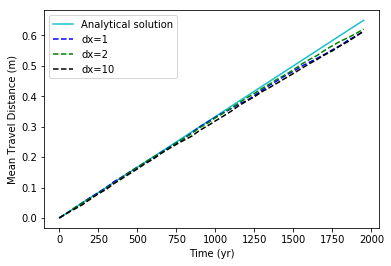

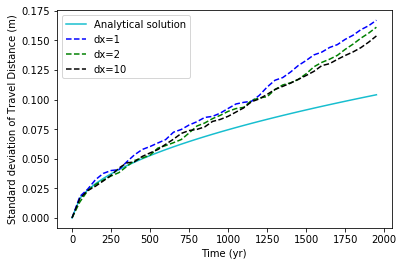

In [15]:
from datetime import datetime
startTime = datetime.now()

import numpy as np
from landlab.item_collection.clast_collection_DR import ClastCollection
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, LinearDiffuser
from landlab.plot import imshow_grid
from matplotlib.pyplot import figure, plot, xlabel, ylabel, title, legend


# Grid 1
dx = 1.
dy=1.
grid = RasterModelGrid((5, 5), (dx, dy))

S=0.3
z = grid.node_y*S
_ = grid.add_field('node', 'topographic__elevation', z)
grid.set_closed_boundaries_at_grid_edges(bottom_is_closed=False,
                                                       left_is_closed=True,
                                                       right_is_closed=True,
                                                       top_is_closed=True)

## Flow Director
fa = FlowAccumulator(grid,
                     'topographic__elevation',
                     flow_director='FlowDirectorSteepest')

## LinDif
kappa = 0.0001
ld = LinearDiffuser(grid, linear_diffusivity=kappa)

# Clasts:
nb_clast = 100
initial_rad = np.random.rand(nb_clast)

CC = ClastCollection(grid,
                     clast_x=np.ones(nb_clast)*2,
                     clast_y=np.ones(nb_clast)*2,
                     clast_elev=np.ones(nb_clast)*6,
                     clast_radius=np.ones(nb_clast)*0.5)

### RUN ##############
Si=1.2
#lambda_0=1.

# RUN
dt=50
runtime=2000

mean_trav_dist=[0]
std_trav_dist=[0]
# Analytical solution:
analytical_mean_trav_dist=[]
analytical_std_trav_dist=[]


for t in range(0,runtime,dt):
    #print(t)
    fa.run_one_step()
    ld.run_one_step(dt)
    CC.clast_solver_Exponential(dt=dt,
                                 Si=Si,
                                 kappa=kappa,
                                 uplift=None,
                                 hillslope_river__threshold=1e4,
                                 lateral_spreading='off',
                                 disturbance_fqcy=0.01,
                                 d_star=5.)

    mean_trav_dist.append(np.mean(CC['total_travelled_dist'].values))
    std_trav_dist.append(np.std(CC['total_travelled_dist'].values))

    analytical_mean_trav_dist.append(t/dt*np.mean(CC['lambda_0'].values)*(Si + S)/(Si - S))
    analytical_std_trav_dist.append(np.sqrt(t/dt)*np.mean(CC['lambda_0'].values)*(Si+S)/(Si-S))

figure(300)
plot(range(0,runtime,dt), analytical_mean_trav_dist, 'tab:cyan', label="Analytical solution")
plot(range(0,runtime,dt), mean_trav_dist[0:-1], '--b', label="dx=1")
xlabel('Time (yr)')
ylabel('Mean Travel Distance (m)')
legend(loc='upper left')
#title("slope=%s, dx=%s, kappa=%s, l_0=%.2f, l_mean=%.2f" % (S, dx, kappa, np.mean(CC['lambda_0']), np.mean(CC['lambda_mean'])))

figure(3000)
plot(range(0,runtime,dt), analytical_std_trav_dist, 'tab:cyan', label="Analytical solution")
plot(range(0,runtime,dt), std_trav_dist[0:-1], '--b', label="dx=1")
xlabel('Time (yr)')
ylabel('Standard deviation of Travel Distance (m)')
legend(loc='upper left')


##############################################################################

# Grid 2
dx = 2.
dy=2.
grid = RasterModelGrid((5, 5), (dx, dy))

S=0.3
z = grid.node_y*S
_ = grid.add_field('node', 'topographic__elevation', z)
grid.set_closed_boundaries_at_grid_edges(bottom_is_closed=False,
                                                       left_is_closed=True,
                                                       right_is_closed=True,
                                                       top_is_closed=True)

## Flow Director
fa = FlowAccumulator(grid,
                     'topographic__elevation',
                     flow_director='FlowDirectorSteepest')

## LinDif
kappa = 0.0001
ld = LinearDiffuser(grid, linear_diffusivity=kappa)


# Clasts:
nb_clast = 100
initial_rad = np.random.rand(nb_clast)

CC = ClastCollection(grid,
                     clast_x=np.ones(nb_clast)*4,
                     clast_y=np.ones(nb_clast)*4,
                     clast_elev=np.ones(nb_clast)*6,
                     clast_radius=np.ones(nb_clast)*0.5)

### RUN ##############
Si=1.2
#lambda_0=1.

# RUN
dt=50
runtime=2000

mean_trav_dist=[0]
std_trav_dist=[0]
# Analytical solution:
analytical_mean_trav_dist=[]
analytical_std_trav_dist=[]
# Analytical solution:
analytical_mean_trav_dist=[]
analytical_std_trav_dist=[]

for t in range(0,runtime,dt):
    #print(t)
    fa.run_one_step()
    ld.run_one_step(dt)
    CC.clast_solver_Exponential(dt=dt,
                                 Si=Si,
                                 kappa=kappa,
                                 uplift=None,
                                 hillslope_river__threshold=1e4,
                                 lateral_spreading='off',
                                 disturbance_fqcy=0.01,
                                 d_star=5.)

    mean_trav_dist.append(np.mean(CC['total_travelled_dist'].values))
    std_trav_dist.append(np.std(CC['total_travelled_dist'].values))
    
    analytical_mean_trav_dist.append(t/dt*np.mean(CC['lambda_0'].values)*(Si + S)/(Si - S))
    analytical_std_trav_dist.append(np.sqrt(t/dt)*np.mean(CC['lambda_0'].values)*(Si+S)/(Si-S))

figure(300)
plot(range(0,runtime,dt), mean_trav_dist[0:-1], '--g', label="dx=2")
xlabel('Time (yr)')
ylabel('Mean Travel Distance (m)')
legend(loc='upper left')

figure(3000)
plot(range(0,runtime,dt), std_trav_dist[0:-1], '--g', label="dx=2")
xlabel('Time (yr)')
ylabel('Standard deviation of Travel Distance (m)')
legend(loc='upper left')

###############################################################################

# Grid 3
dx = 10.
dy=10.
grid = RasterModelGrid((5, 5), (dx, dy))

S=0.3
z = grid.node_y*S
_ = grid.add_field('node', 'topographic__elevation', z)
grid.set_closed_boundaries_at_grid_edges(bottom_is_closed=False,
                                                       left_is_closed=True,
                                                       right_is_closed=True,
                                                       top_is_closed=True)

## Flow Director
fa = FlowAccumulator(grid,
                     'topographic__elevation',
                     flow_director='FlowDirectorSteepest')

## LinDif
kappa = 0.0001
ld = LinearDiffuser(grid, linear_diffusivity=kappa)

# Clasts:
nb_clast = 100
initial_rad = np.random.rand(nb_clast)

CC = ClastCollection(grid,
                     clast_x=np.ones(nb_clast)*20,
                     clast_y=np.ones(nb_clast)*20,
                     clast_elev=np.ones(nb_clast)*6,
                     clast_radius=np.ones(nb_clast)*0.5)

### RUN ##############
Si=1.2

# RUN
dt=50
runtime=2000

mean_trav_dist=[0]
std_trav_dist=[0]
# Analytical solution:
analytical_mean_trav_dist=[]
analytical_std_trav_dist=[]


for t in range(0,runtime,dt):
    #print(t)
    fa.run_one_step()
    ld.run_one_step(dt)
    CC.clast_solver_Exponential(dt=dt,
                                 Si=Si,
                                 kappa=kappa,
                                 uplift=None,
                                 hillslope_river__threshold=1e4,
                                 lateral_spreading='off',
                                 disturbance_fqcy=0.01,
                                 d_star=5.)

    mean_trav_dist.append(np.mean(CC['total_travelled_dist'].values))
    std_trav_dist.append(np.std(CC['total_travelled_dist'].values))
    
    analytical_mean_trav_dist.append(t/dt*np.mean(CC['lambda_0'].values)*(Si + S)/(Si - S))
    analytical_std_trav_dist.append(np.sqrt(t/dt)*np.mean(CC['lambda_0'].values)*(Si+S)/(Si-S))

figure(300)
plot(range(0,runtime,dt), mean_trav_dist[0:-1], '--k', label="dx=10")
xlabel('Time (yr)')
ylabel('Mean Travel Distance (m)')
legend(loc='upper left')

figure(3000)
plot(range(0,runtime,dt), std_trav_dist[0:-1], '--k', label="dx=10")
xlabel('Time (yr)')
ylabel('Standard deviation of Travel Distance (m)')
legend(loc='upper left')



finishTime = datetime.now() - startTime
print('time to execute:%s' %finishTime)